# Exploration of the shap values

In [48]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


In [58]:
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df_data =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df_data, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)


In [14]:
exp_backup = deepcopy(exp)

# Shap values stability analysis

## Analysis of the stability of the models through Shap values investigation 


The question is to know whether from one model to another (train with or without subject i), the shap values are significantly different or not. If training is ribust, it should not! 

In [635]:
# This graph shows that when ASD are reoved, the expected value of the model is lower i.e. the probability of being NT increase.

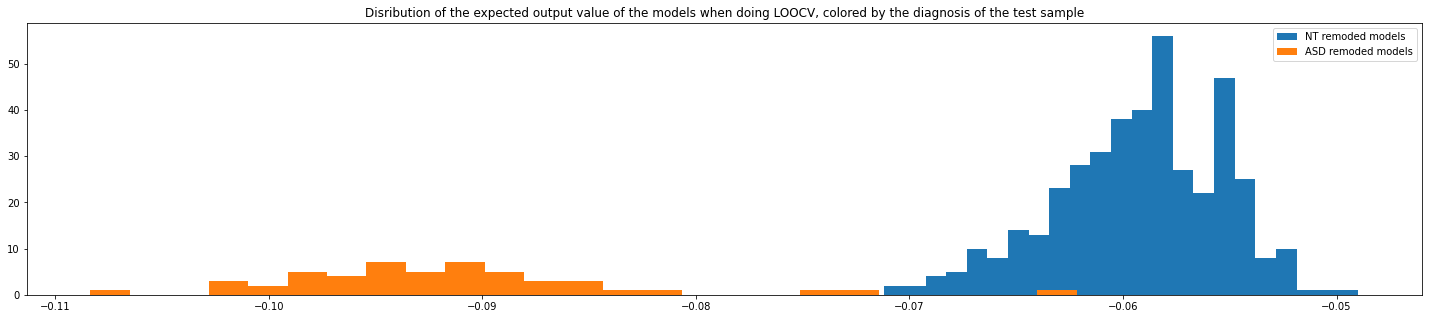

In [12]:
fi(25, 5)
plt.title("Disribution of the expected output value of the models when doing LOOCV, colored by the diagnosis of the test sample")
plt.hist(exp.models_expected_value[np.array(exp.dataset.df[exp.dataset.df['diagnosis']==0].index)], color='tab:blue', bins=25, label='NT remoded models')
plt.hist(exp.models_expected_value[np.array(exp.dataset.df[exp.dataset.df['diagnosis']==1].index)], color='tab:orange', bins=25, label='ASD remoded models')
_ = plt.legend()

In [26]:
# Unique case on the right:
np.argsort(exp.models_expected_value[np.array(exp.dataset.df[exp.dataset.df['diagnosis']==1].index)])
print(np.array(exp.dataset.df[exp.dataset.df['diagnosis']==1].index)[31])
exp.predictions_df[366:367]

mean_gaze_percent_right  gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay  S_postural_sway  NS_postural_sway  S_postural_sway_derivative  NS_postural_sway_derivative  S_postural_sway_complexity  NS_postural_sway_complexity  S_facing_forward  NS_facing_forward  S_eyebrows_complexity  NS_eyebrows_complexity  S_mouth_complexity  NS_mouth_complexity  std_error  number_of_touches  number_of_target  average_error  Z_PlayingWithBlocks  Z_FunAtThePark  Z_BlowingBubbles  Z_RhymesAndToys  y_true    y_pred  TN  TP  FP  FN pred_class  sample_weight
366                      NaN                    NaN                                NaN                        0.617283              NaN          1.990688                         NaN                     0.010127                         NaN                          0.0               NaN          57.655955                    NaN               31.046416                 NaN            28.464212        NaN                0.0               0.0            NaN                  1.0             1.0               1.0              1.0     1.0  0.456584   0   1   0   0         TP       0.102222

**We first differentiate the shap values associated with the present features from the missing features, to disambiguate the contribution of missing features and actual features values.**

In [221]:
n_models, n_participants, n_features = exp.shap_values.shape


extended_shap_values = np.zeros((n_models, n_participants, 2*n_features))
for idx_model in range(n_models):
    
    shap_value_models = exp.shap_values[idx_model, :, :]
    
    mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
    shap_present = np.multiply(shap_value_models, mask_shap_present)
    shap_missing = np.multiply(shap_value_models, (mask_shap_present==0).astype(int))
    
    # Normalized shap value separating real variables and when there are missing.
    general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)
    shap_present_normalized = shap_present / np.abs(shap_present).sum(axis=1)[:, np.newaxis]
    general_shap_values_normalized  = general_shap_values / np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]
    extended_shap_values[idx_model, :, :] = general_shap_values_normalized
    
labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]                  


In [189]:
import shap

# Compute the shap values with the model fit with all the data
explainer = shap.TreeExplainer(exp.model)
expected_value_fit = explainer.expected_value
shap_values_fit  = explainer.shap_values(exp.dataset.X_train)

# Disambuguate present and missing variables 
mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_fit, mask_shap_present)
shap_missing = np.multiply(shap_values_fit, (mask_shap_present==0).astype(int))

# Normalized shap value separating real variables and when there are missing.
general_shap_values_fit = np.concatenate([shap_present, shap_missing], axis=1)
shap_present_fit_normalized = shap_present / np.abs(shap_present).sum(axis=1)[:, np.newaxis]
shap_values_fit_normalized  = general_shap_values_fit / np.abs(general_shap_values_fit).sum(axis=1)[:, np.newaxis]

# Compute the Shap Values for indiviuals through the cross validation

shap_values = np.zeros(extended_shap_values.shape)
for i in range(exp.dataset.num_samples):
    shap_values[i, :] = extended_shap_values[i, i, :]
    
shap_values_normalized = shap_values / np.abs(shap_values).sum(axis=1)[:, np.newaxis]


In [2]:
0.9 * 0.32 +  0.6 * 0.28 + 1 * 0.17 + 1 * 0.14 + 0.9 * 0.09 

0.8470000000000001

The Following two graphs show the features comtribution for all the participants in two cases:

- Using the normalized sShap values recorded for each participants when doing the cross-validation: those are the actual true Shap value that explain the final prediction. 
- When fitting the model with all the training data (not removing the hold-out test participant). 

Providing that the traning is robust and that the model does not overfit on the training data, these Shap values shoul be very close. 
At first sight it seems relatively close, but there are some changes in the ordering of the features for instance, which might change the conclusion, so we need to dive deeper and quantify these Sahp values variations. 




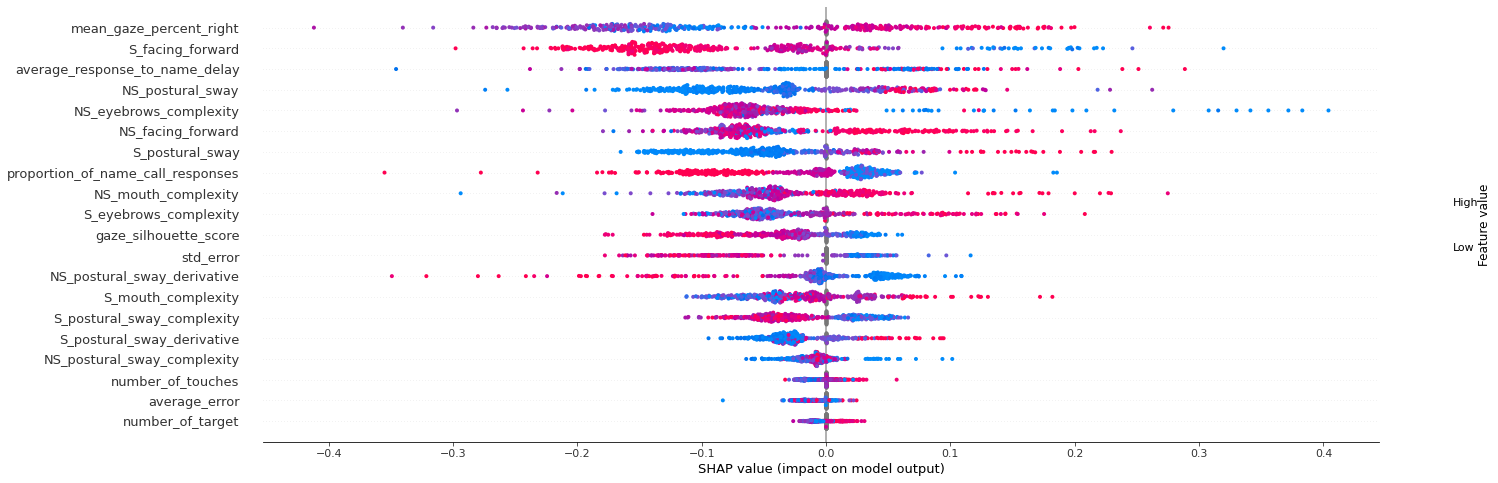

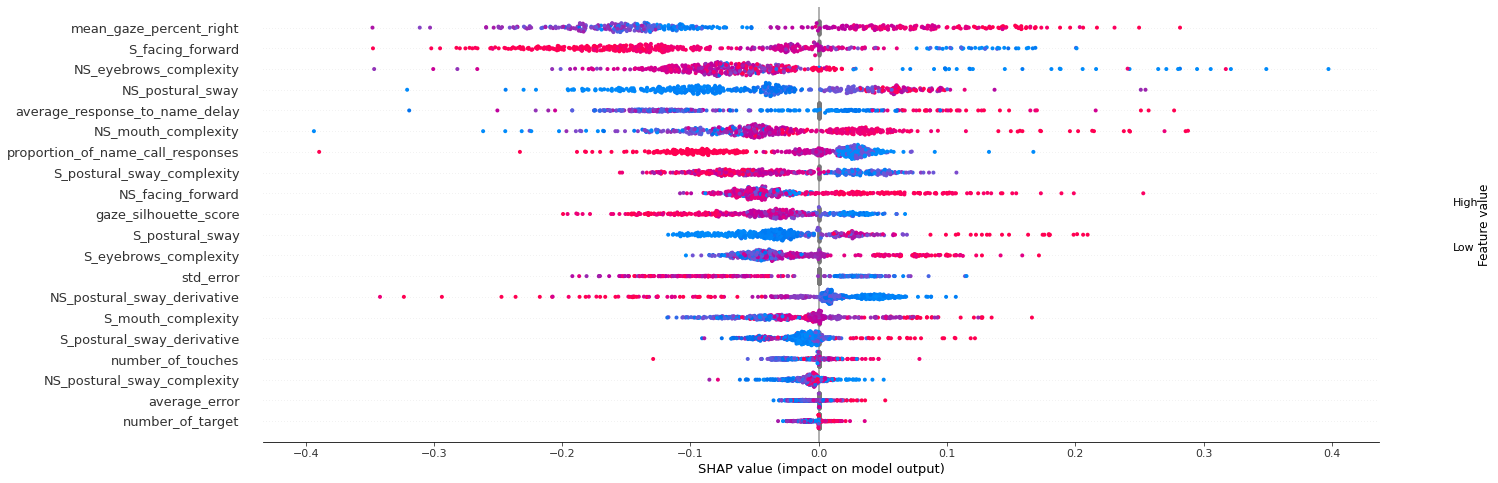

In [208]:
shap.summary_plot(shap_present_normalized, exp.dataset._X_train, feature_names=exp.features_name, plot_size=(25, 8), title="Shap Values with CV")
shap.summary_plot(shap_present_fit_normalized, exp.dataset._X_train, feature_names=exp.features_name, plot_size=(25, 8), title="Shap Values fitting all the model")

In order to quantify the fluctuations of the Shap Values due to different traning data being used, let's look at: 
- Local variation: for each of the participants, what is the variance of their Shap value over different tranining ? 
- Global variation: Over the different traning, what is the variance of the contribution of each features ? 

Subject:419


id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking        age timestamp       date   time study stimuli_version sex            ethnicity             race  primary_education  asd_yn  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay valid_name_calls  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  \
419  850897        1.0  English         2.1  <Subject.S2KSubject object at 0x7fea92a0f990>  <Administration.S2KAdministration object at 0x...                   1              1  20.360656    Admin1 2020-02-11  00:00   ARC       Preschool   M  Not Hispanic/Latino  White/Caucasian                8.0     NaN       30.0       29.0       20.0       30.0            51.0         8.0      10.0      7.0               NaN                          NaN                           NaN                 3.0             5.0          6.0          4.0           1.0                0.58159                  0.486084              0.529963                 0.655589                     0.49031                  0.666716                                0.0                             NaN        [1, 1, 1]          2.033254                      0.01525            0.165608                       0.000211              0.191543                         0.000405          0.166645                     0.000285   

     MP_postural_sway  MP_postural_sway_derivative  PB_postural_sway  PB_postural_sway_derivative  BB_postural_sway  BB_postural_sway_derivative  RT_postural_sway  RT_postural_sway_derivative  MML_postural_sway  MML_postural_sway_derivative  PWB_postural_sway  PWB_postural_sway_derivative  FP_postural_sway  FP_postural_sway_derivative  number_of_touches  average_length  std_length  average_error  std_error  number_of_target  pop_rate  average_touch_duration  std_touch_duration  average_delay_to_pop  std_delay_to_pop  repeat_percentage  repeat_percentage_naive  double_tap  mean_velocity  std_velocity  average_force_applied  std_force_applied  average_accuracy_variation  accuracy_consistency  average_touches_per_target  std_touches_per_target  average_time_spent  std_time_spent  exploratory_percentage  validity_available  completed  StateOfTheChild  SiblingsInTheRoom ShotsVaccines  Distractions  FamilyMemberDistract  PetDistract  PetNoiseDistract  DoorbellPhoneDistract  TVOnDistract  \
419          1.985771                     0.013921               NaN                          NaN          0.334831                     0.001559          0.551756                     0.003079           0.724744                      0.005122           0.922212                      0.005056          2.827383                      0.01626               15.0       14.609402   17.555556      12.246151   6.028955               8.0  0.533333                  0.4468             0.47746              3.178714           1.01723               0.25                 0.666667    0.142857         0.4468       0.47746               0.057852           0.060961                    0.131664              0.382404                        1.25                0.661438               1.646             0.0               55.555556                   1        0.0              3.0                NaN           NaN           0.0                   0.0          0.0               0.0                    0.0           0.0   

     OtherDistract  SittingUp  Hu

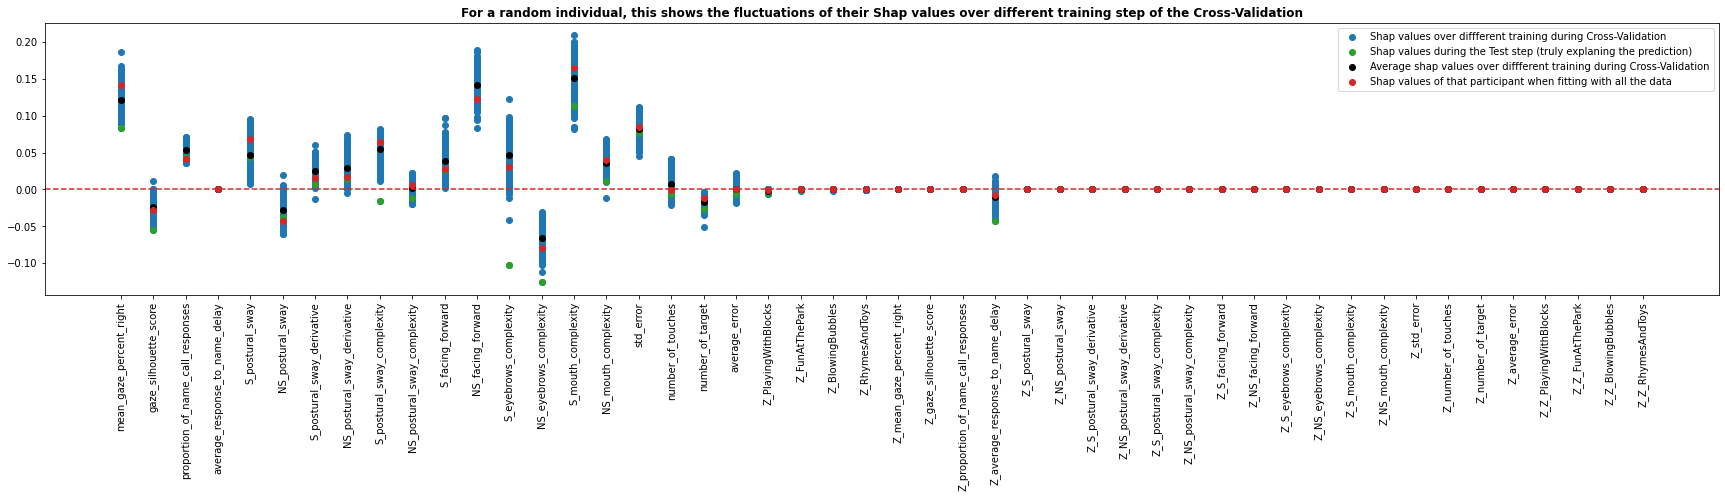

In [237]:
subject_of_interest = np.random.randint(467)
print("Subject:{}".format(subject_of_interest))
display(exp.dataset.df.iloc[subject_of_interest:subject_of_interest+1])

fi(30, 5)
n_model = exp.shap_values.shape[0]
plt.title("For a random individual, this shows the fluctuations of their Shap values over different training step of the Cross-Validation", weight='bold')
for i, feature_name  in enumerate(labels):
    plt.scatter([i]*n_model, extended_shap_values[:, subject_of_interest, i], color='tab:blue', label="Shap values over diffferent training during Cross-Validation" if i==0 else None)
    plt.scatter([i], extended_shap_values[subject_of_interest, subject_of_interest, i], color='tab:green', label="Shap values during the Test step (truly explaning the prediction)" if i==0 else None)
    plt.scatter([i], extended_shap_values.mean(axis=0)[subject_of_interest, i], color='k', label="Average shap values over diffferent training during Cross-Validation" if i==0 else None)
    plt.scatter([i], shap_values_fit_normalized[subject_of_interest, i], color='tab:red', label="Shap values of that participant when fitting with all the data" if i==0 else None)

plt.axhline(0, linestyle='--', color='tab:red')
plt.legend()


_  = plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.show()

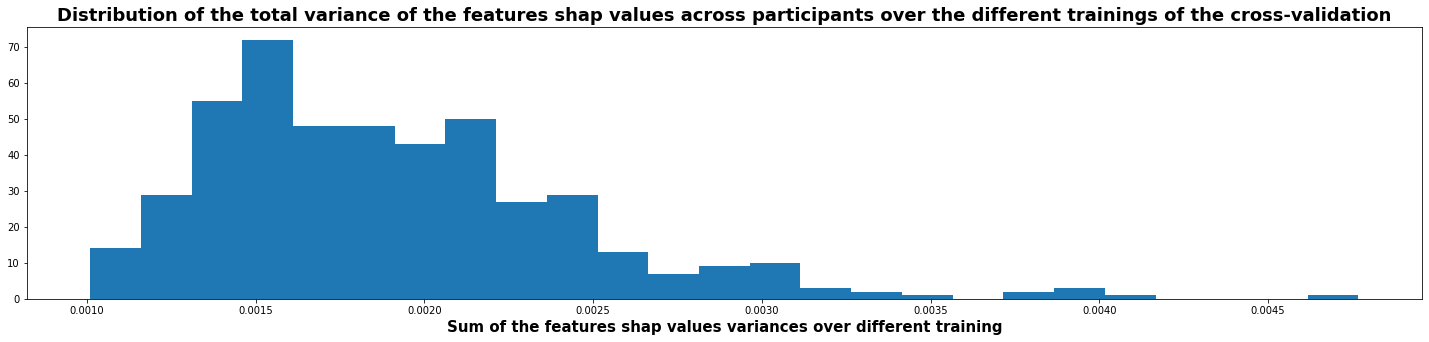

In [226]:
var_list = []
for subject_of_interest in range(467):
    var = 0
    for i, feature_name  in enumerate(labels):
        var+=np.var(extended_shap_values[:, subject_of_interest, i])
    var_list.append(var)
    
    
fi(25, 5)
plt.title("Distribution of the total variance of the features shap values across participants over the different trainings of the cross-validation", weight='bold', fontsize=18)
plt.hist(var_list, bins=25)
_ = plt.xlabel("Sum of the features shap values variances over different training", weight='bold', fontsize=15)


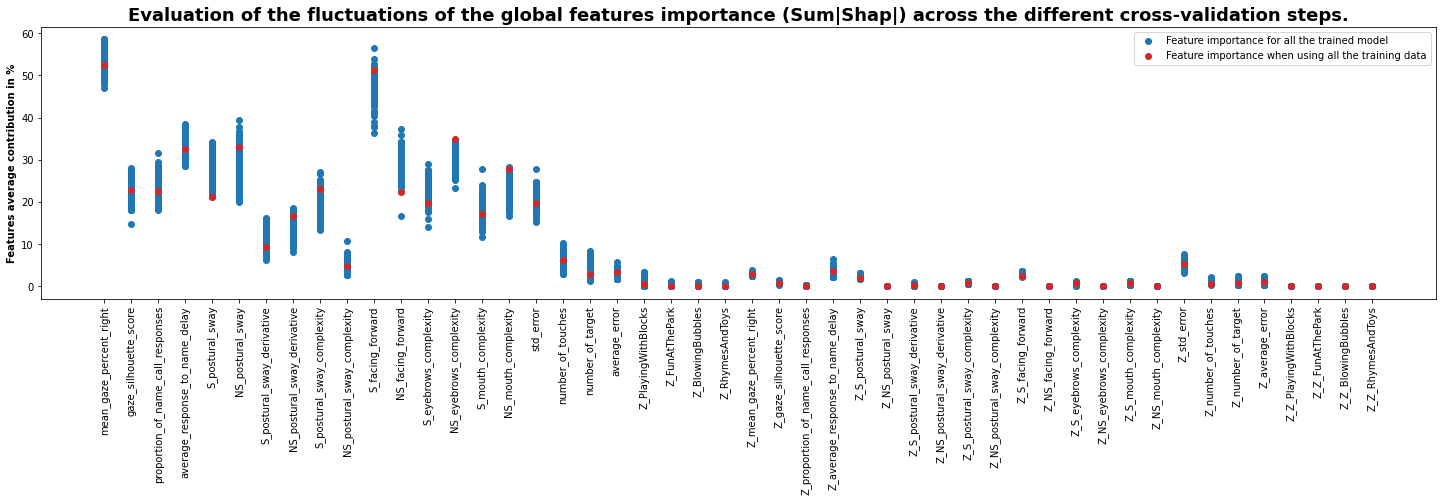

In [228]:
# Compute the global feature importance for each of the trained model and features, by summing over the rows of each @d Matrix shap values
features_importance_all_models_cv = np.abs(extended_shap_values).sum(axis=1)

# Plot the features importance of a few models
fi(25, 5)
plt.title("Evaluation of the fluctuations of the global features importance (Sum|Shap|) across the different cross-validation steps.", weight='bold', fontsize=18)
for idx_model in range(extended_shap_values.shape[0]):
    feature_importance = features_importance_all_models_cv[idx_model]#.std(axis=0)
    plt.scatter(np.arange(feature_importance.shape[0]), feature_importance, color='tab:blue', label = "Feature importance for all the trained model" if idx_model==0 else None)
    
plt.scatter(np.arange(feature_importance.shape[0]), np.abs(shap_values_fit_normalized).sum(axis=0), color='tab:red', label = "Feature importance when using all the training data")
plt.legend(); plt.ylabel("Features average contribution in %", weight='bold')
_ = plt.xticks(np.arange(feature_importance.shape[0]), labels, rotation=90)

# Interaction effects


This section aims at studying the effect of the interactions between app features in the contributions of each app variables to the model and to the predictions.

1) We first train the model and store the Shap variables
2) We compute the Shap interaction effects, whicgh takes the form of a matrix of sixe N x K x K. For a sample, the sum of the matrix equal the prediction, 
   and the sum over rows (or columns) equal the shap value of that each features.
3) We study the average normalized contributions of principal and interaction effects across the dataset, by averaging all matrices across the dataset
4) We then take a few cases and draw their Shap matrix.

In order to assess which features interact the more and justify reporting them in the paper, we also add at step 3) and 4) a summary dataframe showing the most important information for each features:
- Its total principal contribution
- The sum of their interaction contribution 
- The feature having thr most interaction


In [565]:
def display_interaction_summary(matrix_shap):
    
    principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
    interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

    dict_shap = {}
    for i, feat in enumerate(exp.features_name):

        main_effect = np.abs(matrix_shap)[i,i]
        interaction_effect = np.abs(matrix_shap)[i].sum() - main_effect

        row_shap = deepcopy(np.abs(matrix_shap)[i])
        row_shap[i] = 0
        first_interaction = np.max(row_shap)
        first_interaction_name = exp.features_name[np.argmax(row_shap)]

        dict_shap[feat] = {'total': main_effect+interaction_effect, 'main': main_effect, 'interaction': interaction_effect, 'first_interaction': first_interaction, 'first_interaction_name': first_interaction_name}
    final_interactions_summary = pd.DataFrame(dict_shap).transpose().sort_values('total', ascending=False)
    final_interactions_summary.append(pd.DataFrame([[100, principal_effect_sum, interaction_effect_sum, '', '']], index=['SUM'], columns = final_interactions_summary.columns))

    return final_interactions_summary

## SHAP Summary Plot¶


The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of being autistic for the trained XGBoost model. 

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk.

# Closer look at the Misclassified samples

In [39]:
import shap
explainer = shap.TreeExplainer(exp.model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: [0.11800709]


In [ ]:
for name in ['TP','FN', 'TN', 'FP']:


    index  = np.array(list(exp.predictions_df[exp.predictions_df[name]==1].index))
    features = exp.predictions_df[exp.features_name]

    shap_values = explainer.shap_values(features)[index]
    shap_interaction_values = explainer.shap_interaction_values(features)
    hap_interaction_values = shap_interaction_values[index]
    shap.decision_plot(expected_value, shap_values, features, title="Shap Values of {} predictions".format(name))

# Paper: Plot SHAP fitures individual effects

In [16]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)




377 administrations left.


id
diagnosis     
0.0        328
1.0         49

**Compute Shap Values using the experiment that were run with all features, in the `paper_uncertianinty` notebook**

In [49]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/multimodal_paper_final/SenseToKnow/'

    
json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))

i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")

shap_interactions = np.concatenate(shap_interactions_all_cv)

# Normalize the Shap Values for each sample so that there are comparables. 
shap_interactions_normalized = shap_interactions / np.abs(shap_interactions).sum(axis=3).sum(axis=2)[:, :, np.newaxis, np.newaxis]

# Average the Shap values over the different experiments 
averaged_shap_interactions = shap_interactions_normalized.mean(axis=0)

# Re-normalize the Shap values
averaged_shap_interactions_normalized  = averaged_shap_interactions/np.abs(averaged_shap_interactions).sum(axis=2).sum(axis=1)[:, np.newaxis, np.newaxis]

In [60]:
averaged_shap_interactions_normalized.shape

(377, 23, 23)

In [50]:
principal_effect_sum = np.mean([np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])
principal_effect_sum_std = np.std([np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])

interaction_effect_sum = np.mean([np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])
interaction_effect_sum_std = np.std([np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])

print("Principal contribution of each features: {:.3f} (+/- {:.3f}), and interaction effect: {:.3f} (+- {:.3f}%)".format(principal_effect_sum, principal_effect_sum_std, interaction_effect_sum, interaction_effect_sum_std ))

Principal contribution of each features: 0.646 (+/- 0.034), and interaction effect: 0.354 (+- 0.034%)


In [51]:
df_shap_interaction_importance#.nlargest(2)
df_shap_interaction_importance.loc[feature_name].nlargest(2).values

val = []
name = []
feats = []

for i, feat in enumerate(exp.features_name):
    
    feature_name = feature_name_mapping[feat]
    
    feats.append(feature_name)
    name.append(df_shap_interaction_importance.loc[feature_name].nlargest(2).index[1])
    val.append(df_shap_interaction_importance.loc[feature_name].nlargest(2).values[1]*100)
    

best_interaction = pd.DataFrame({'Best interacting':name, 'Value': val} , index = feats).round(2)
best_interaction

Best interacting  Value
Gaze Percent Social                                        Facing Forward during Non-social movies   0.54
Gaze Silhouette Score                                                          Gaze Percent Social   0.13
Attention to Speech                                 Head Movements Complexity during Social movies   0.12
Response to Name Proportion                              Mouth Complexity during Non-social movies   0.52
Response to Name Delay [s]                                 Facing Forward during Non-social movies   0.35
Head Movements during Social movies                                            Gaze Percent Social   0.37
Head Movements during Non-social movies                        Facing Forward during Social movies   0.14
Head Movements Acceleration during Social movies                               Gaze Percent Social   0.23
Head Movements Acceleration during on-social mo...         Head Movements during Non-social movies   0.12
Head Movements Complexity during Social movies                         Response to Name Proportion   0.36
Head Movements Complexity during Non-social movies                             Gaze Percent Social   0.11
Blink Rate during Social                                                       Gaze Percent Social   0.31
Blink Rate during Non-social                                                   Gaze Percent Social   0.12
Facing Forward during Social movies                                            Gaze Percent Social   0.32
Facing Forward during Non-social movies                                        Gaze Percent Social   0.54
Eyebrows Complexity during Social movies                       Facing Forward during Social movies   0.28
Eyebrows Complexity during Non-social movies                   Pop The Bubbles Accuracy Variations   0.22
Mouth Complexity during Social movies                                   Response to Name Delay [s]   0.15
Mouth Complexity during Non-social movies                              Response to Name Proportion   0.52
Pop The Bubbles Popping Rate                             Mouth Complexity during Non-social movies   0.07
Pop The Bubbles Accuracy Variations                      Mouth Complexity during Non-social movies   0.34
Pop The Bubbles Average Touch Length                     Mouth Complexity during Non-social movies   0.08
Pop The Bubbles Average Force Applied                          Pop The Bubbles Accuracy Variations   0.05

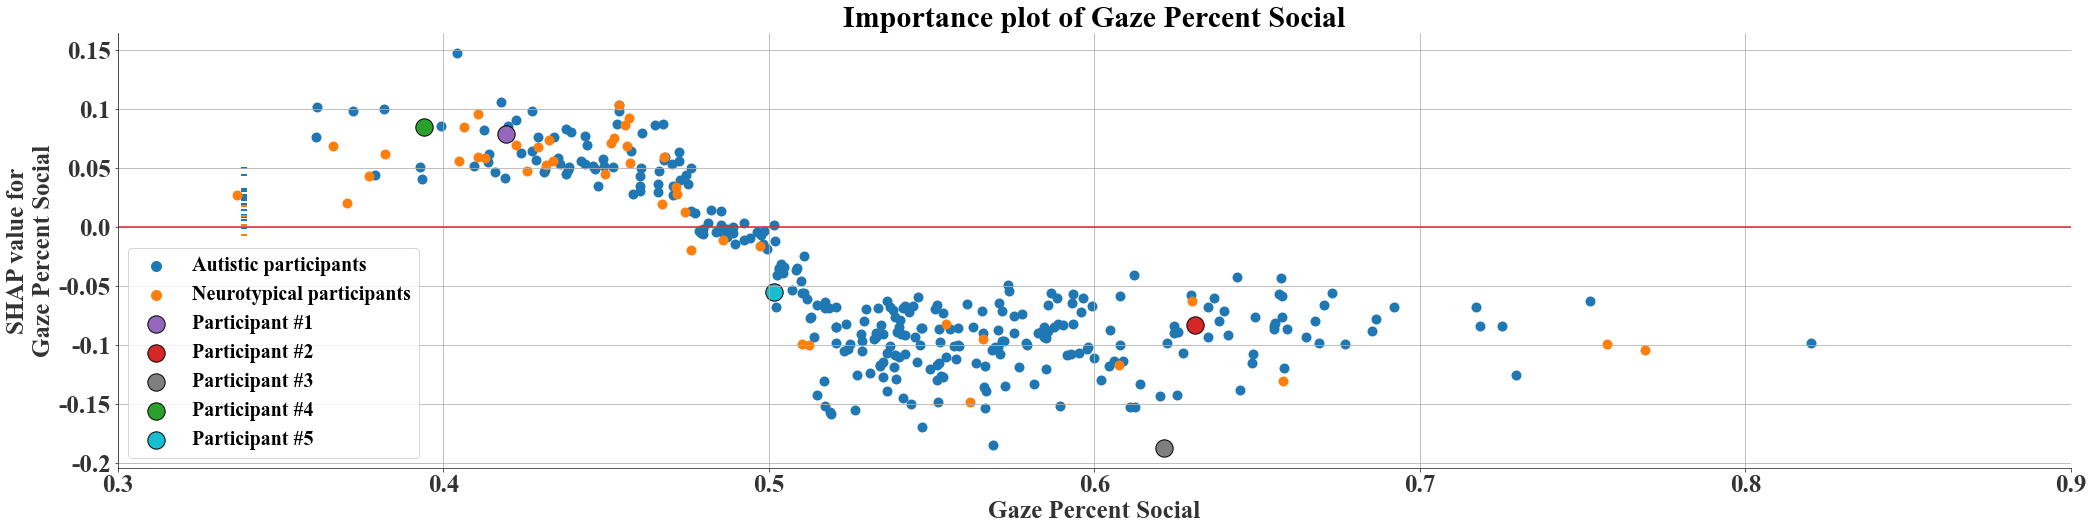

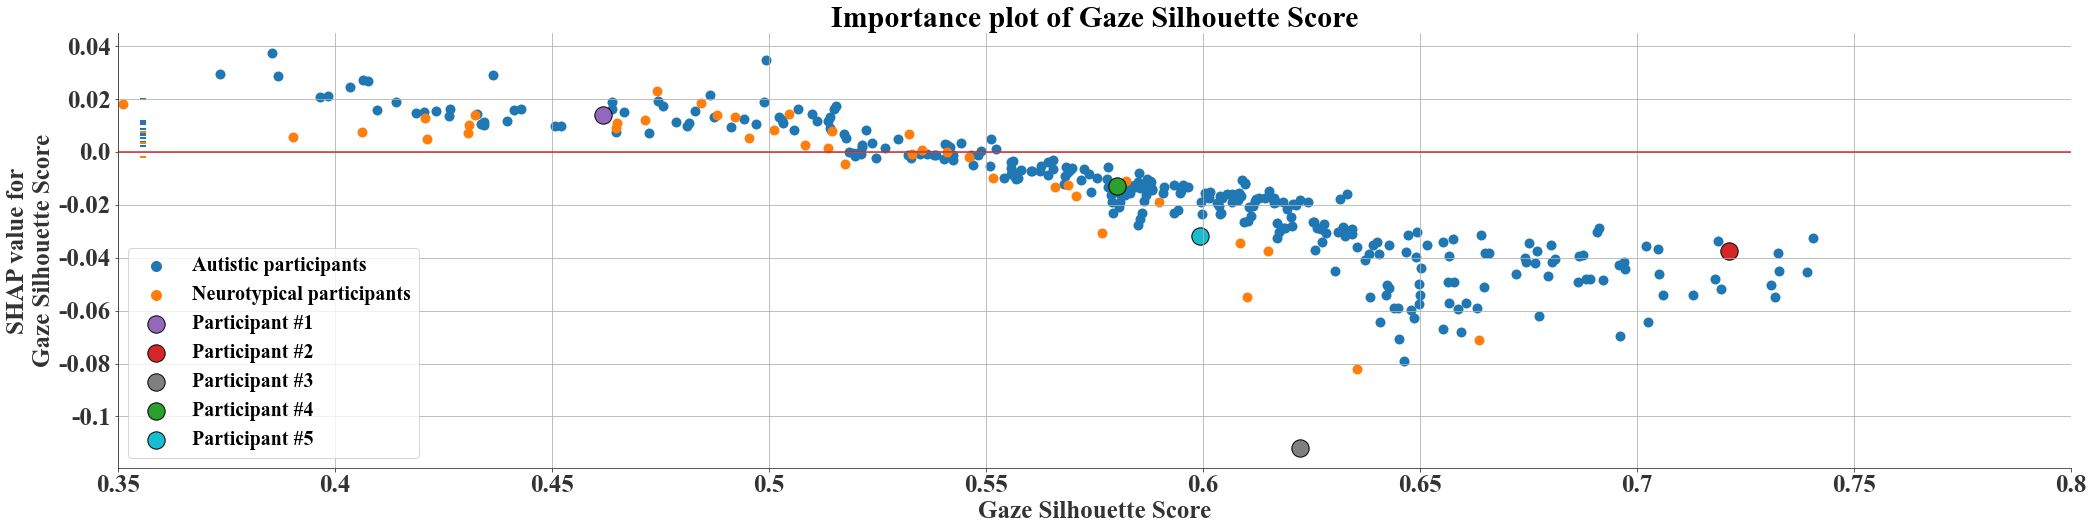

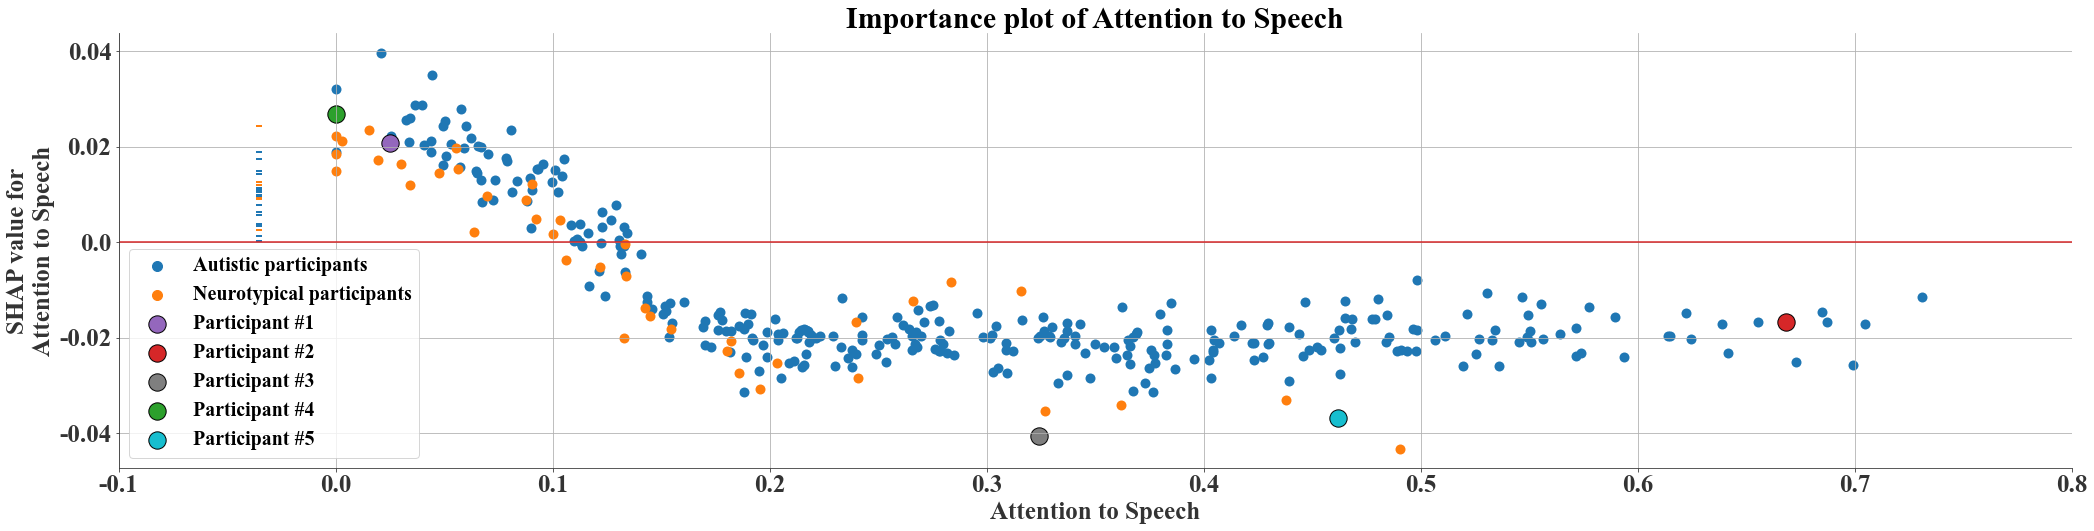

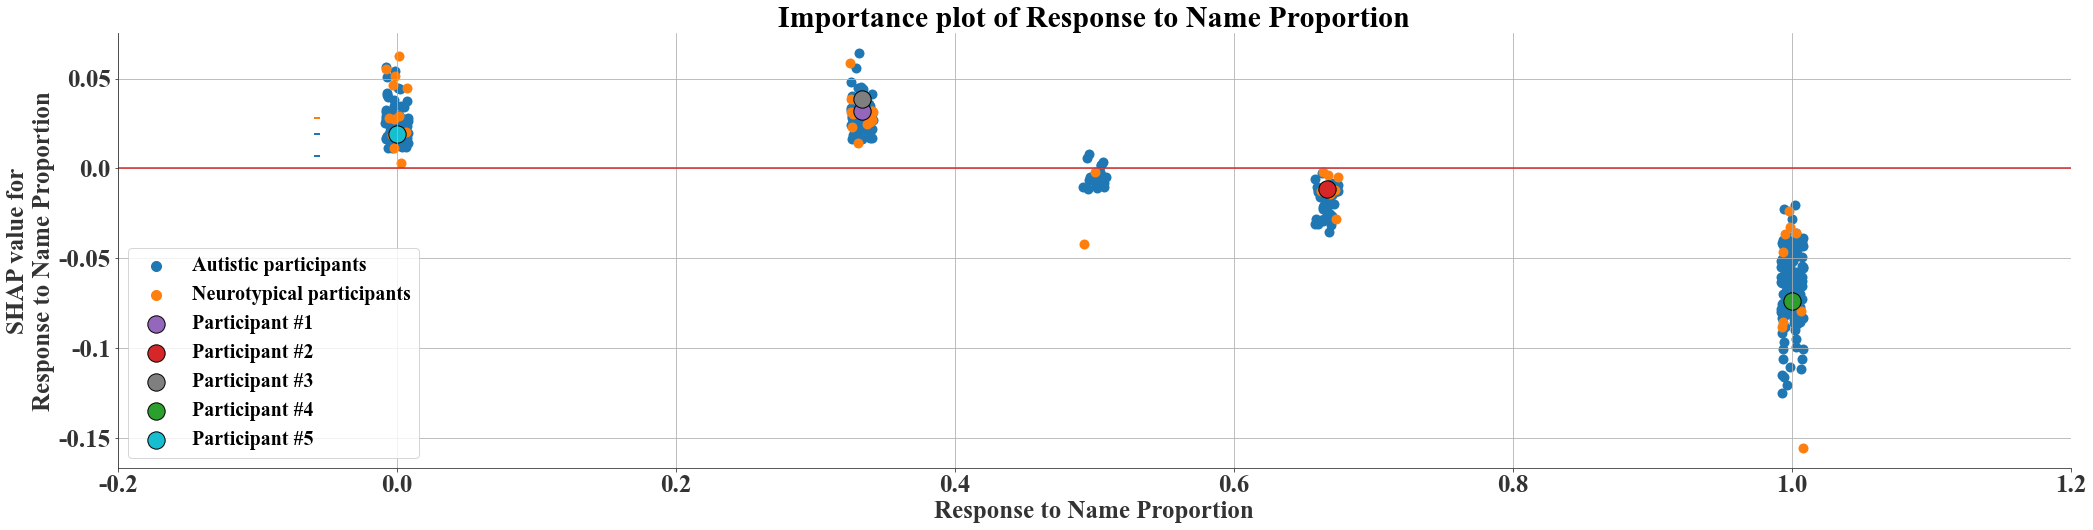

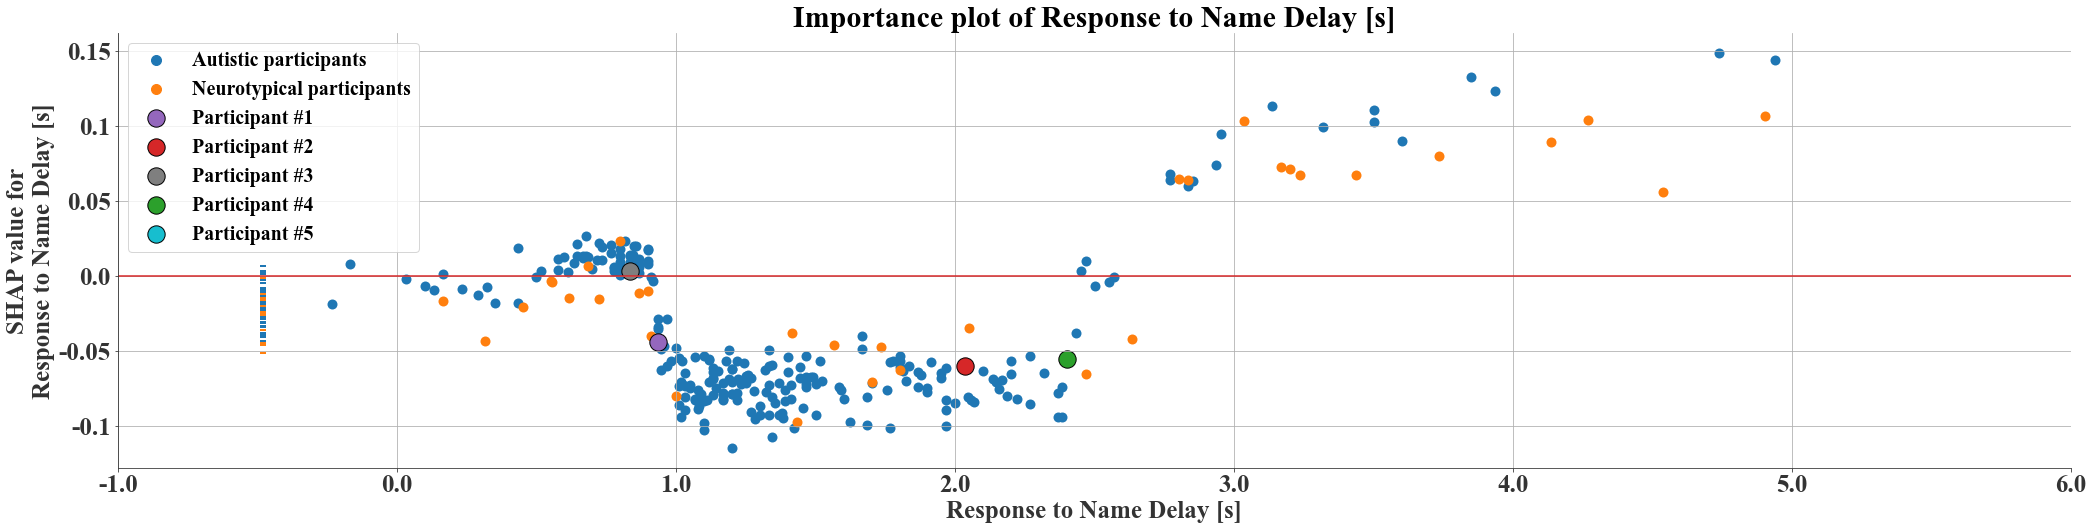

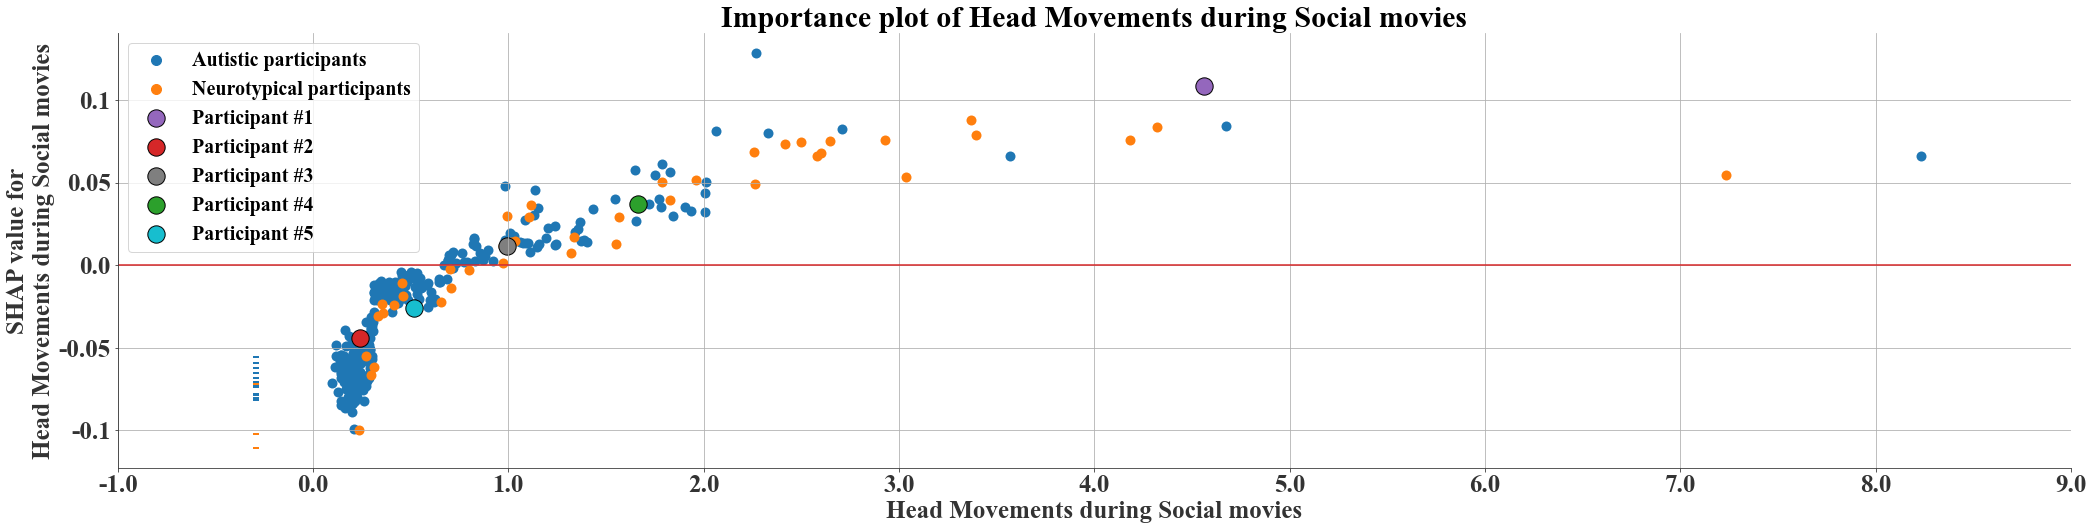

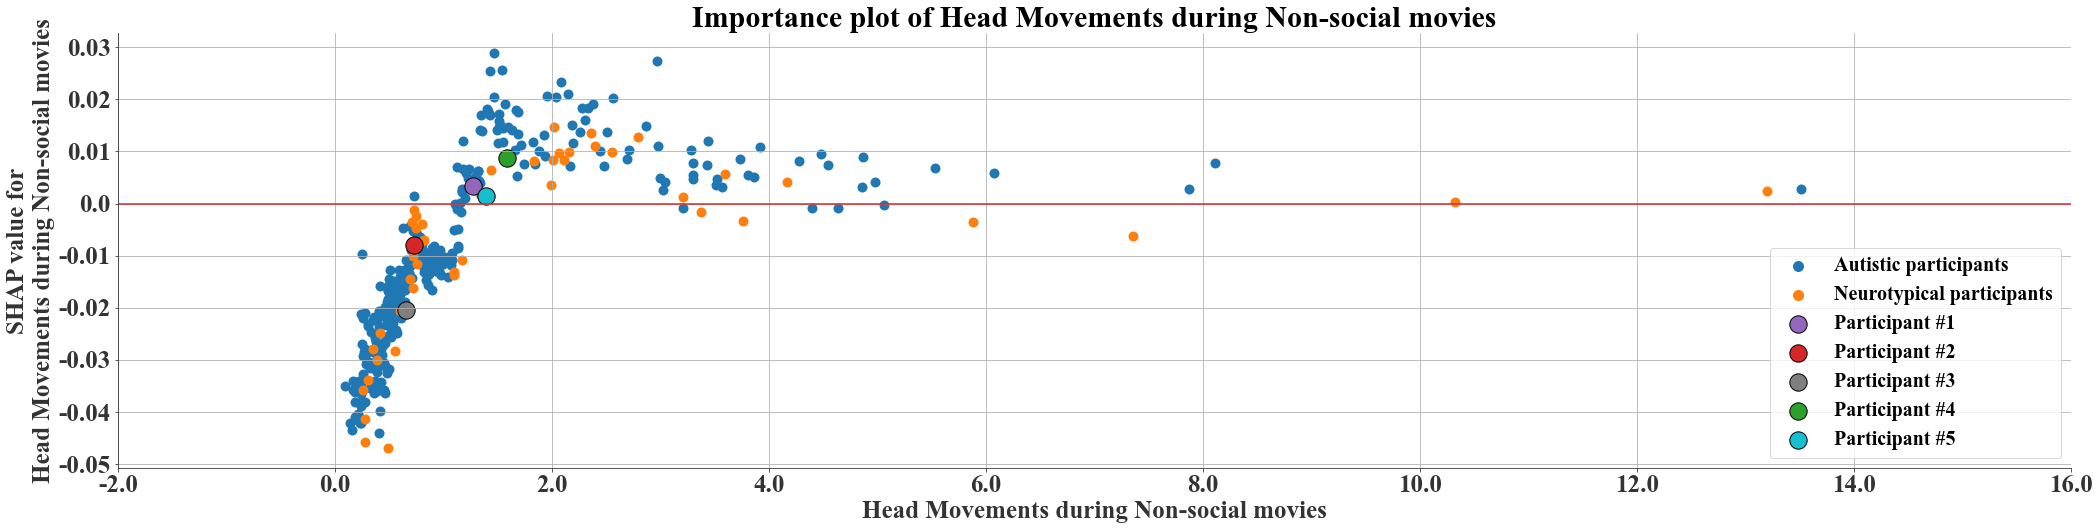

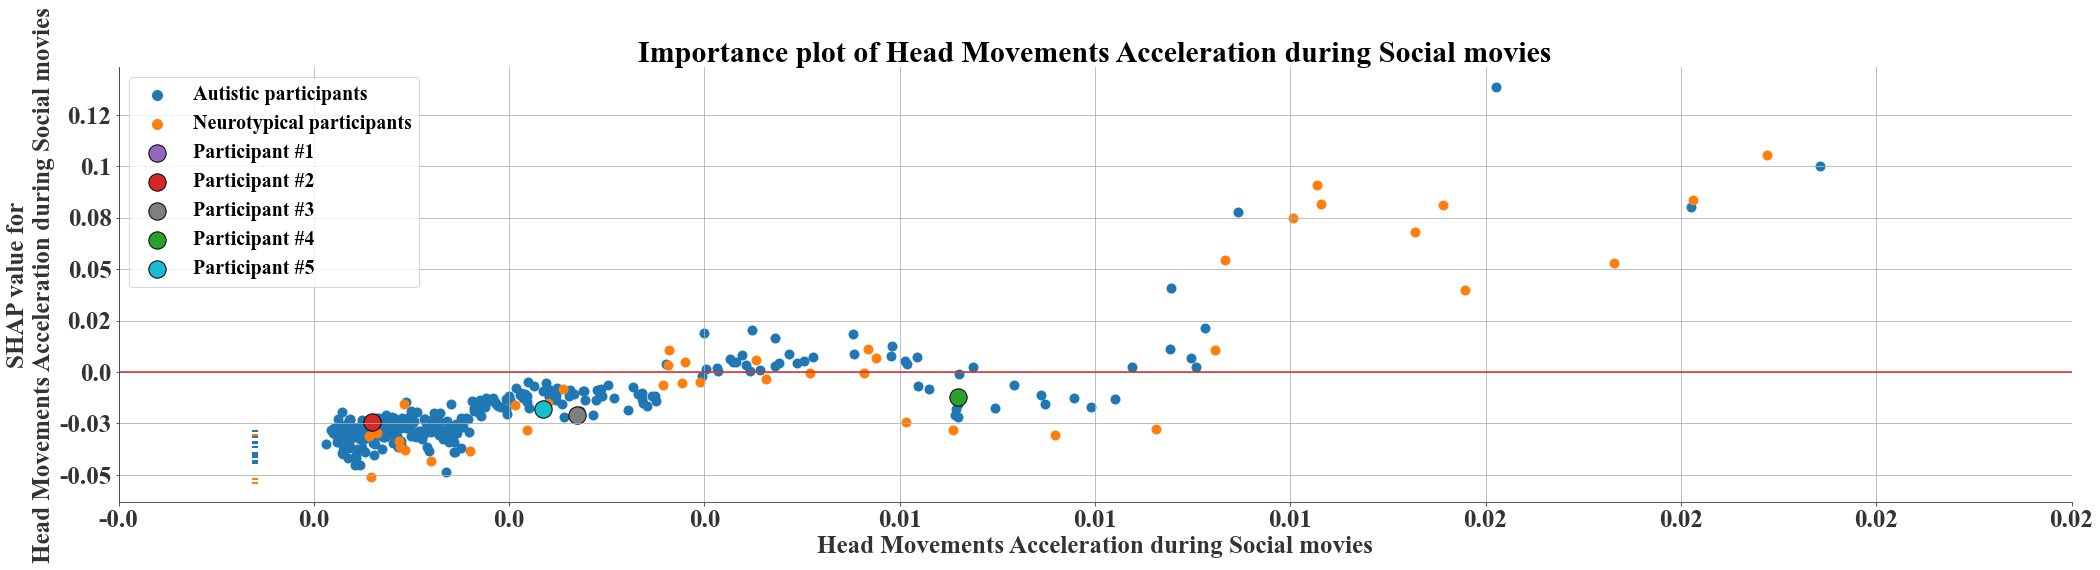

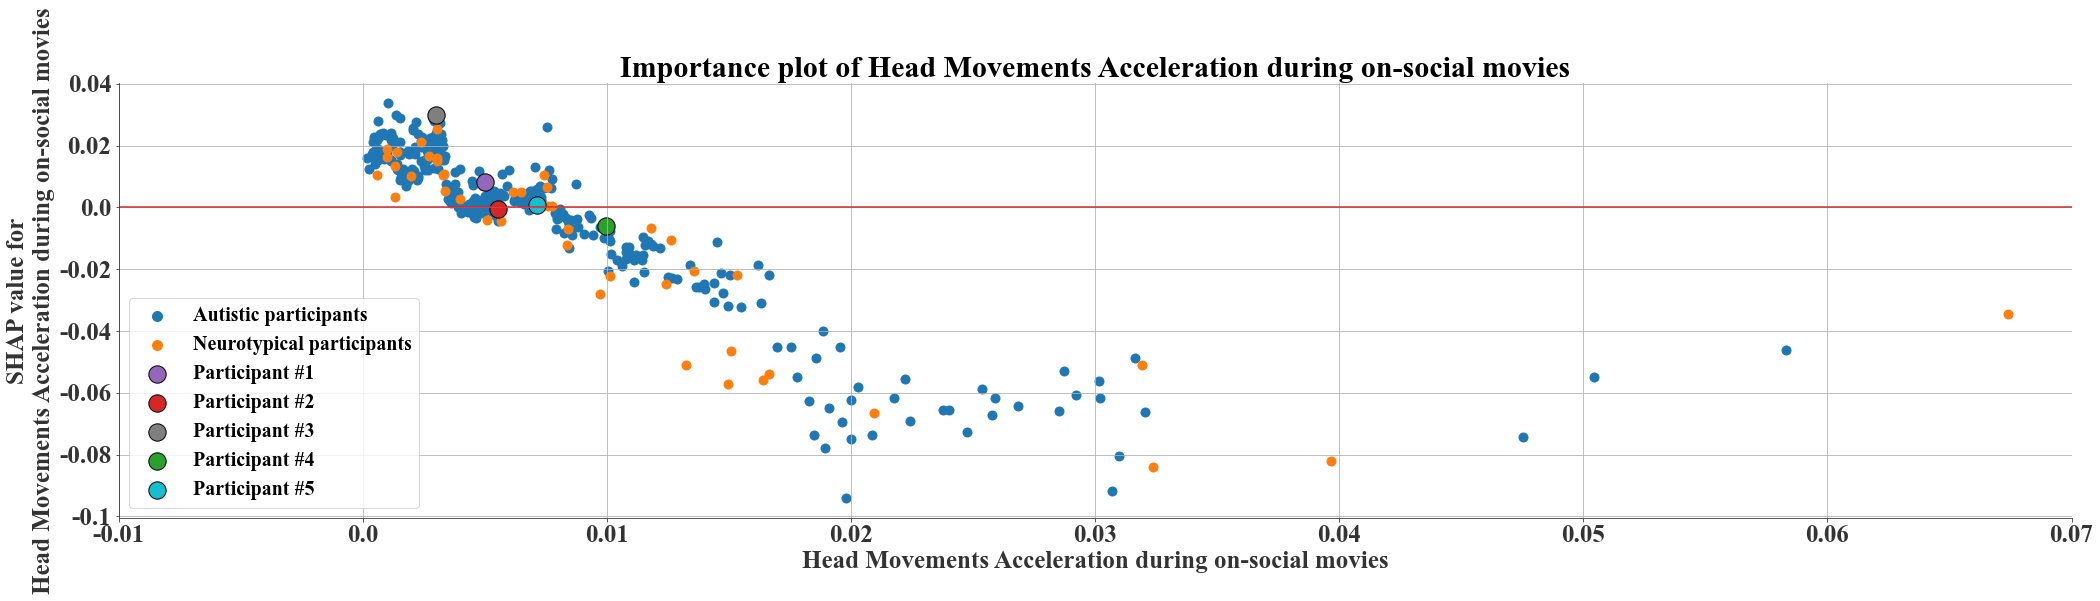

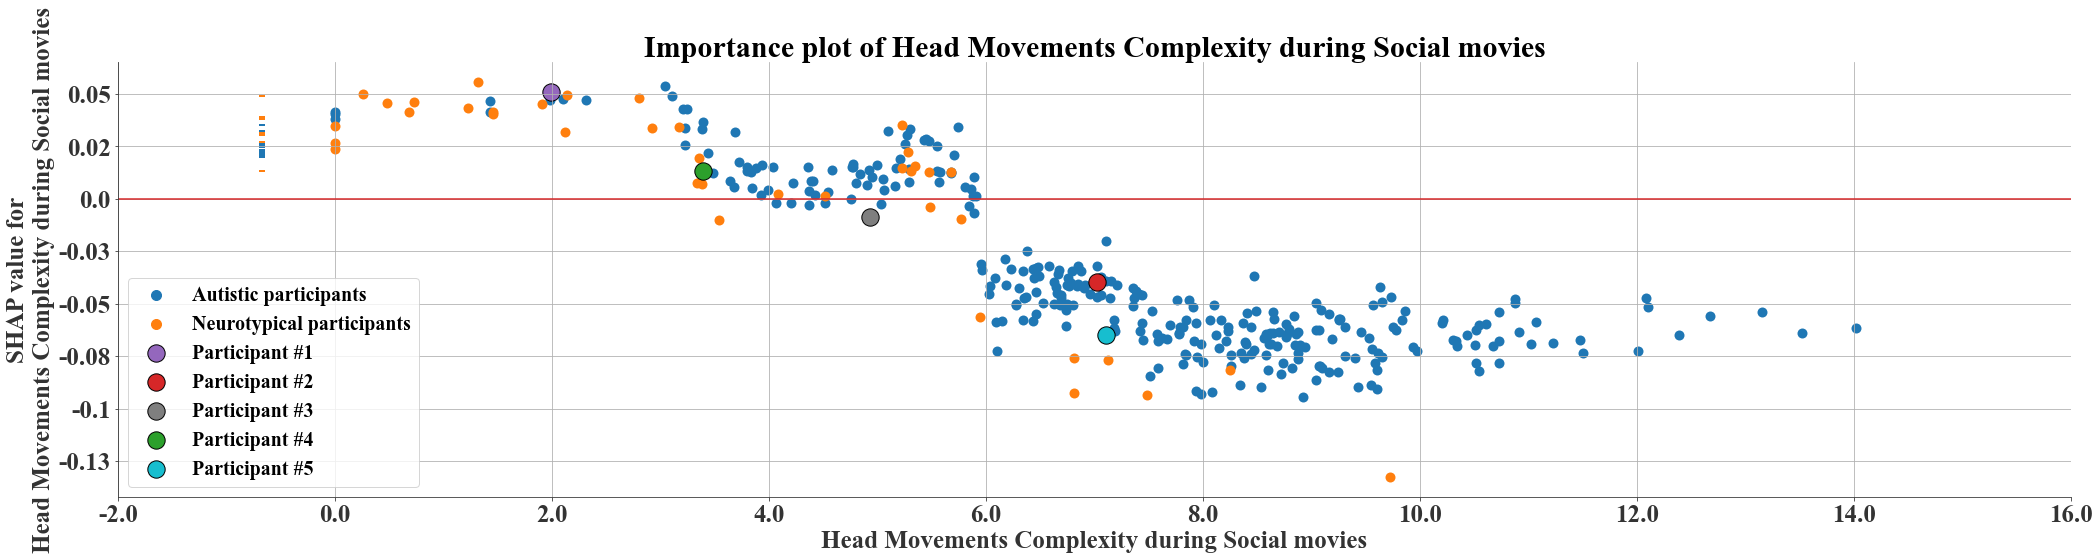

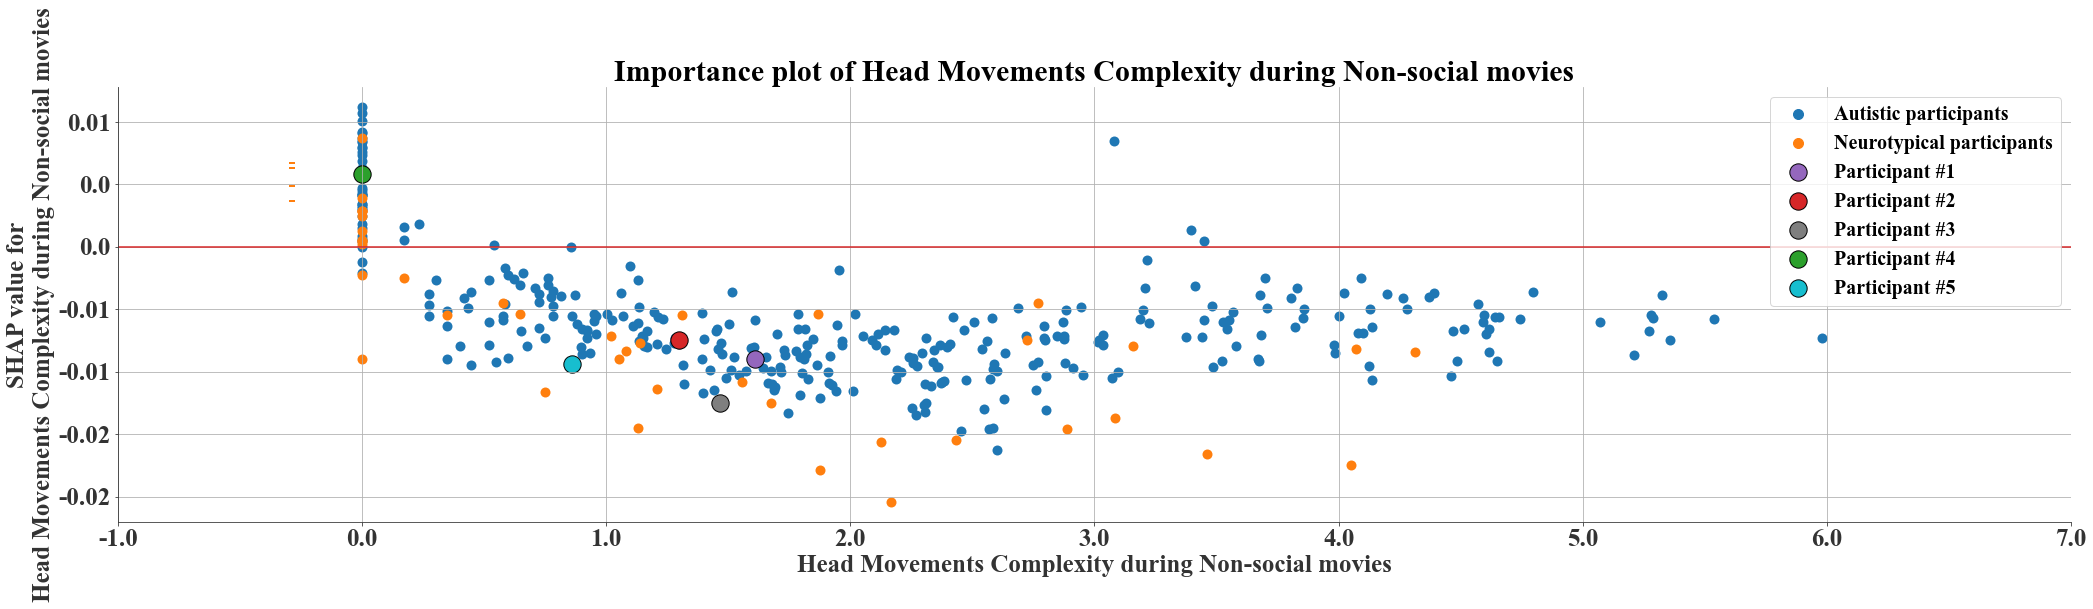

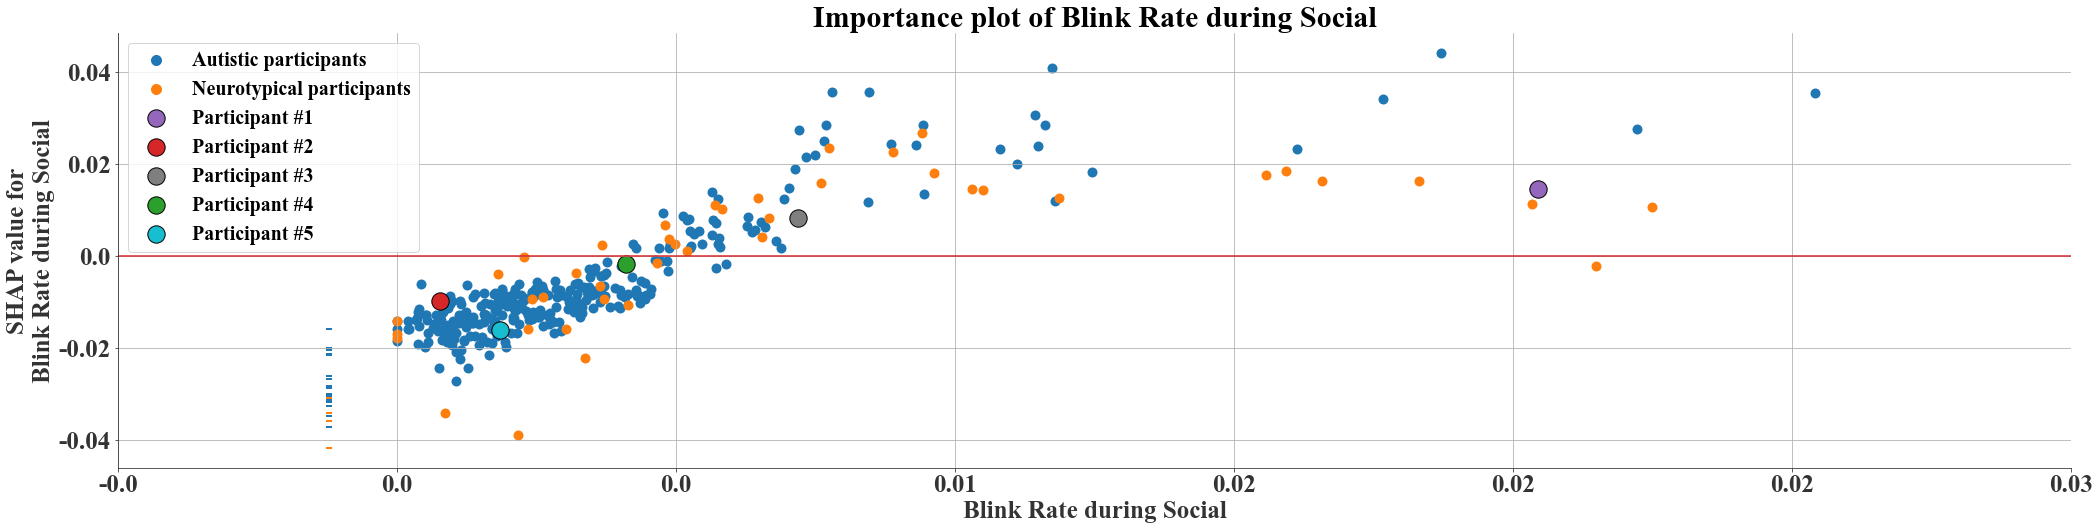

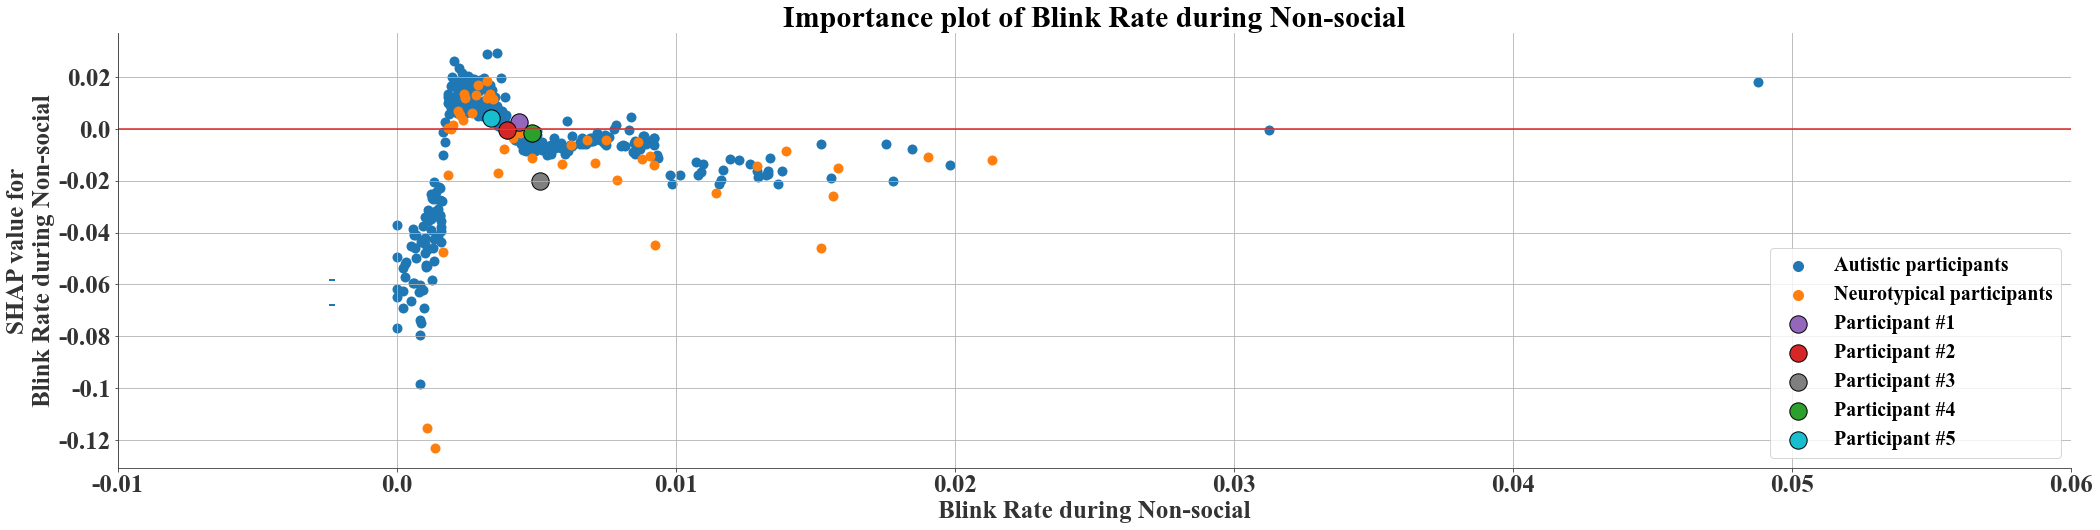

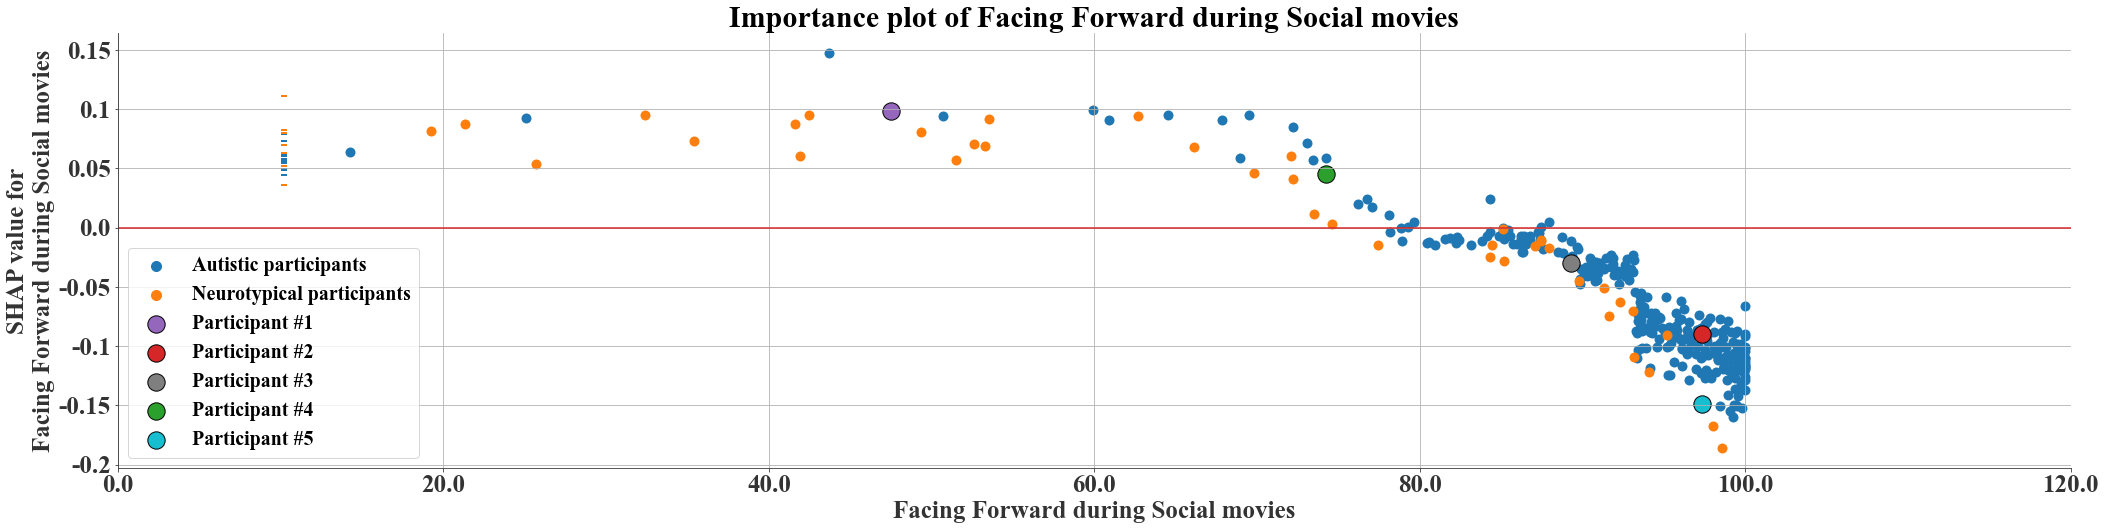

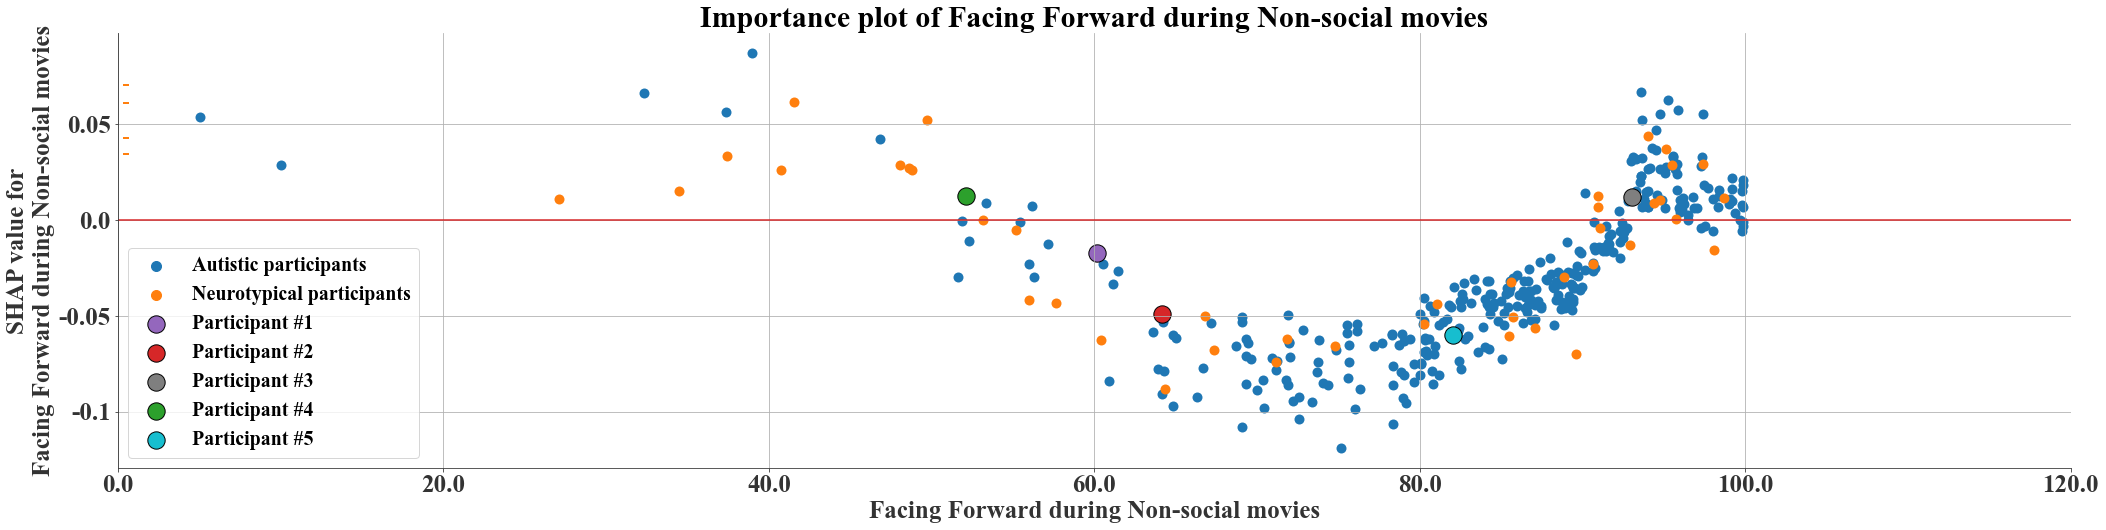

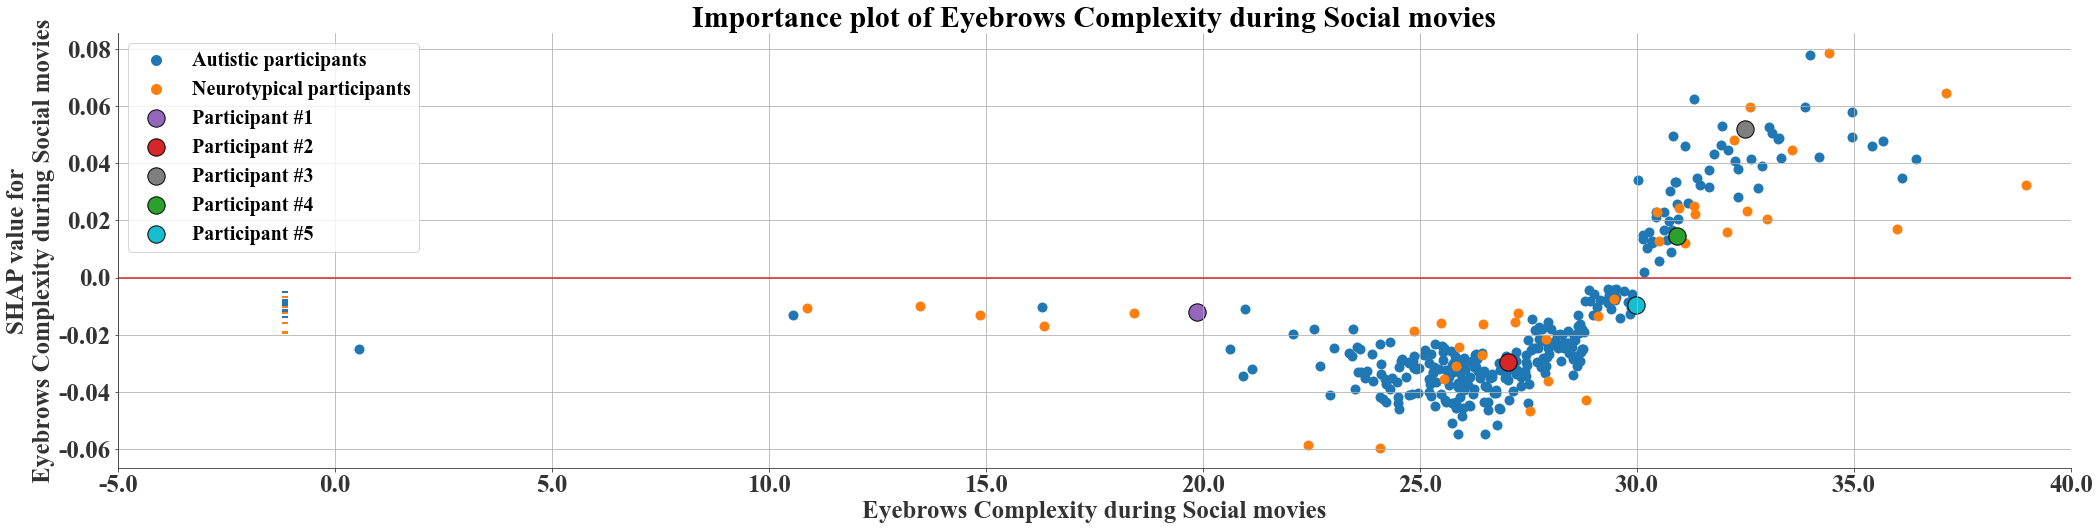

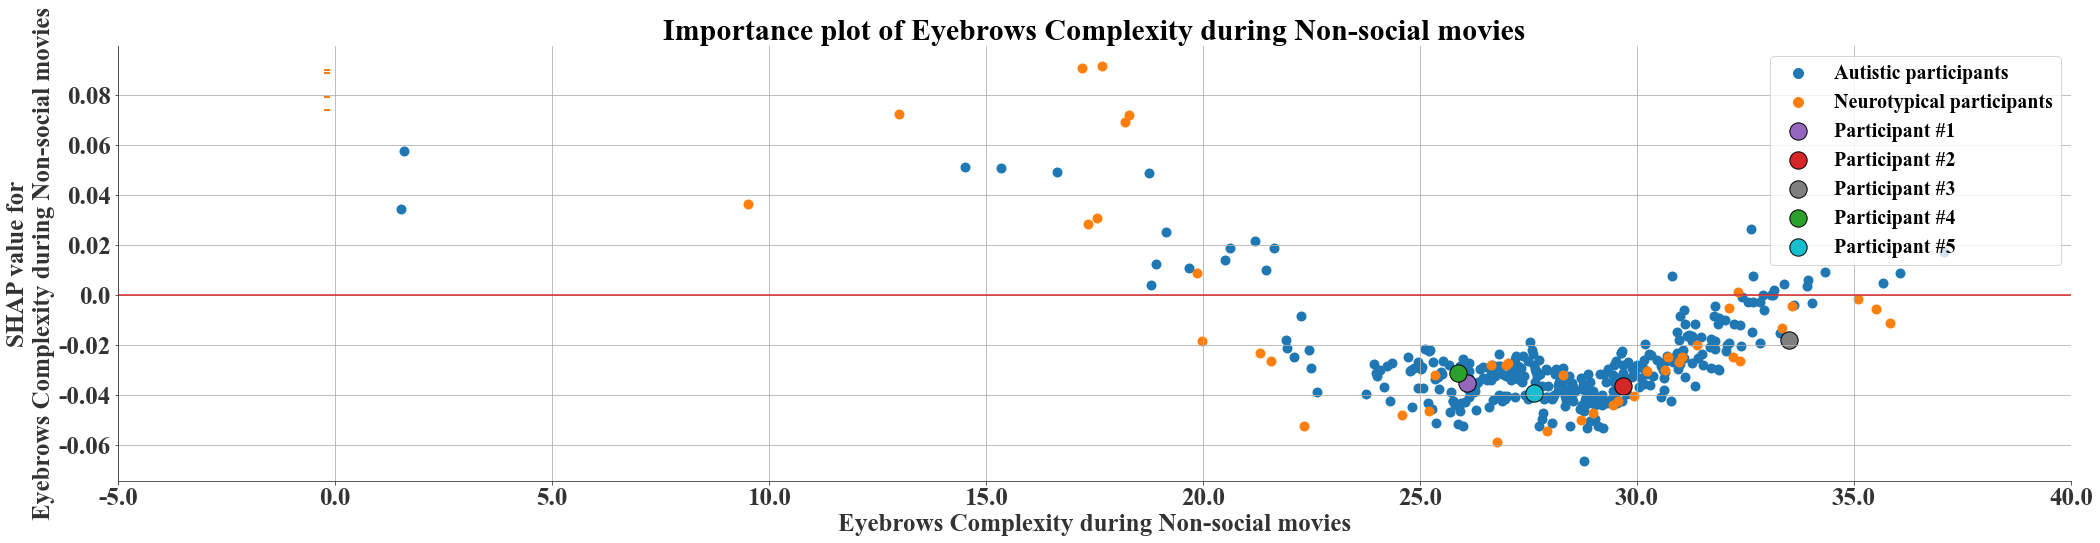

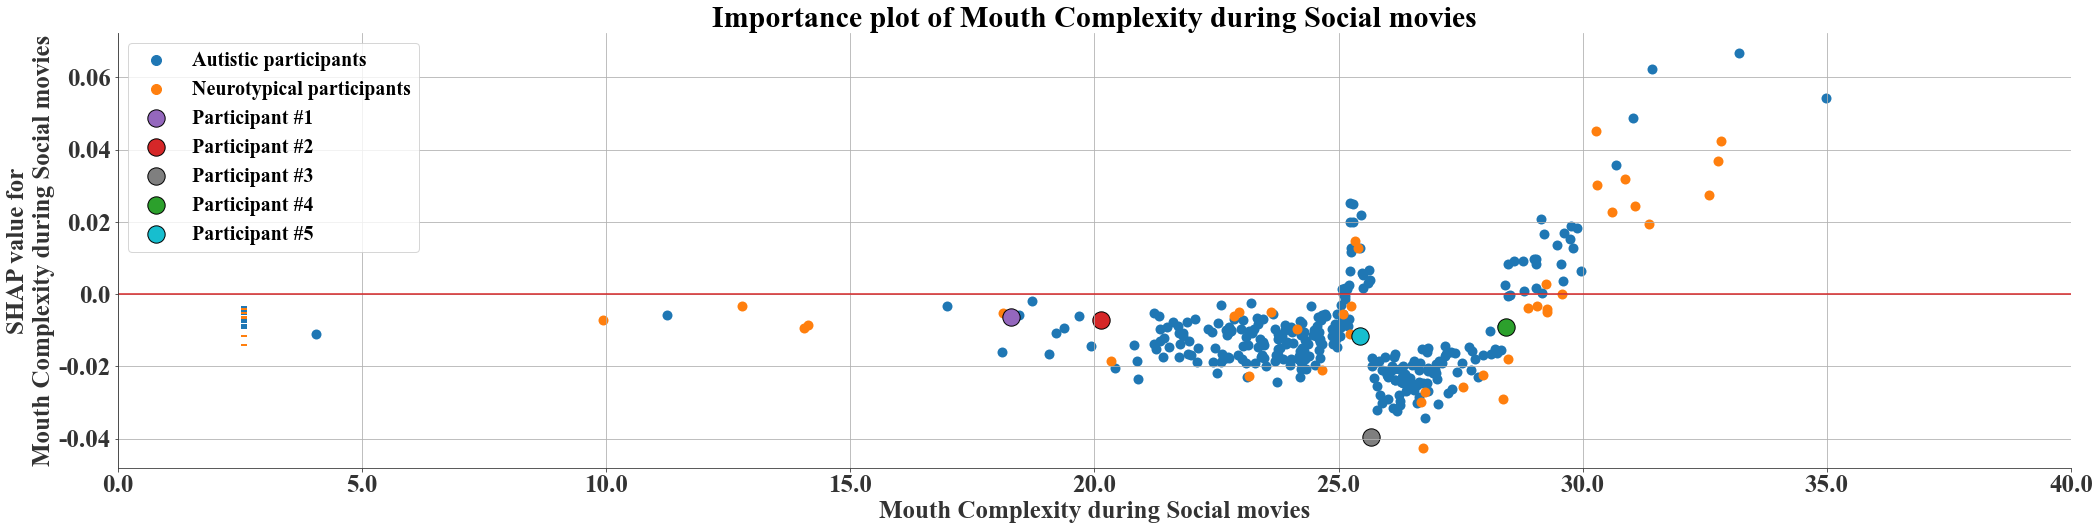

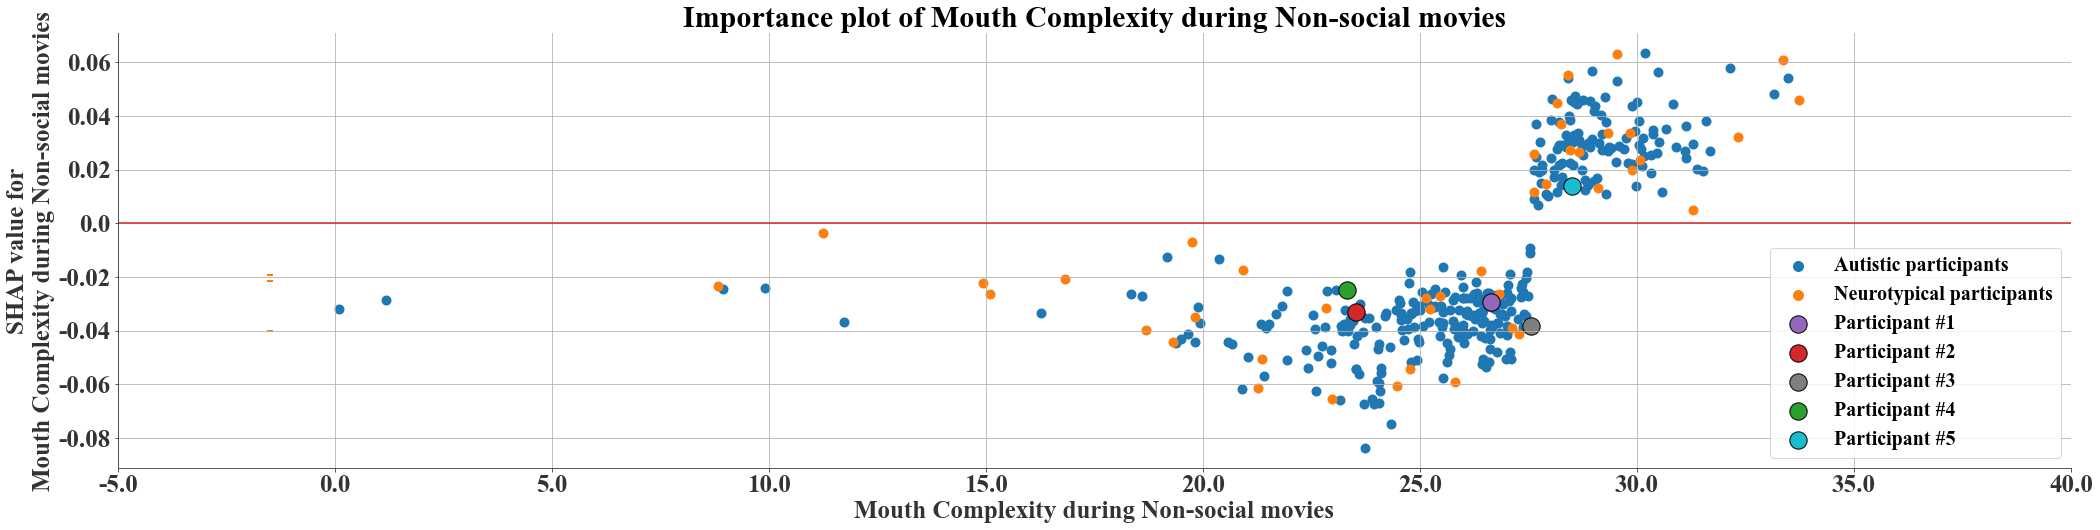

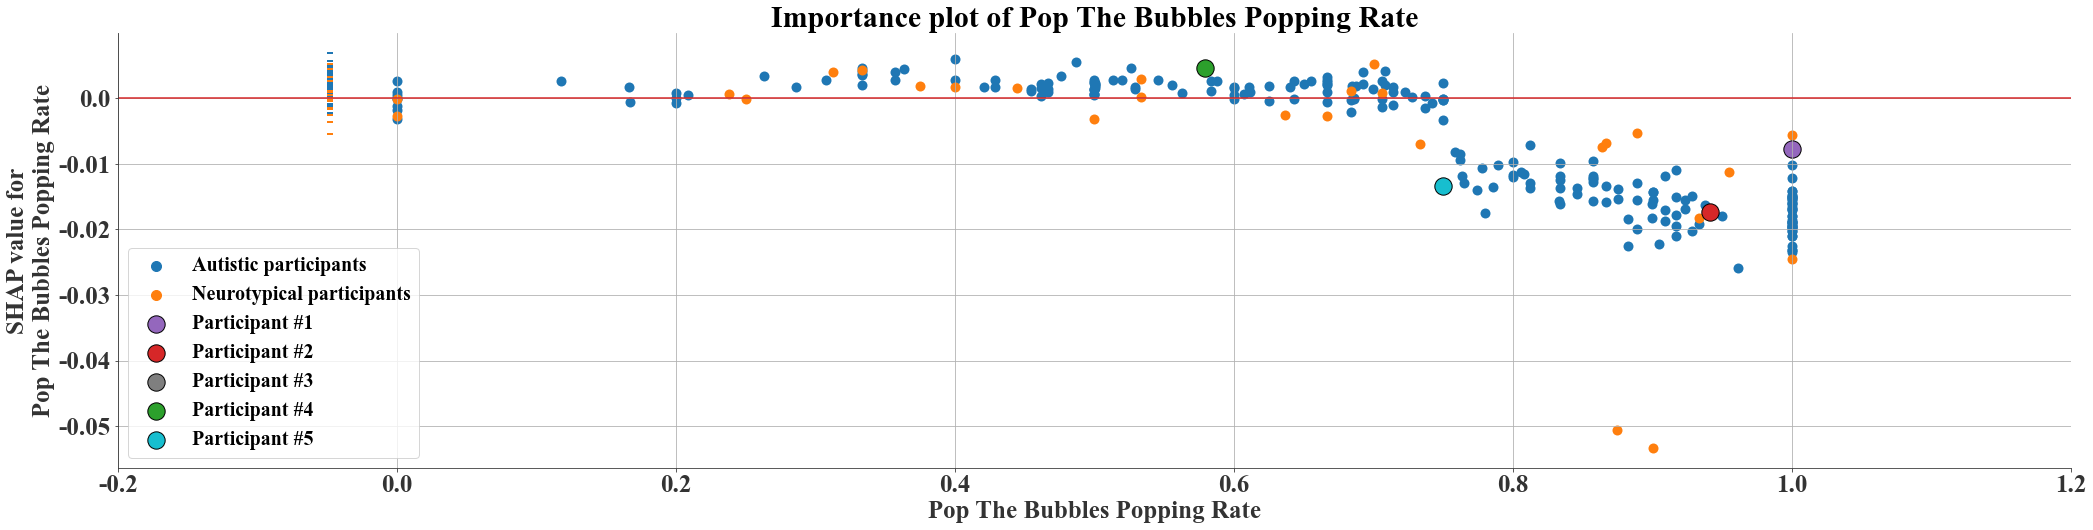

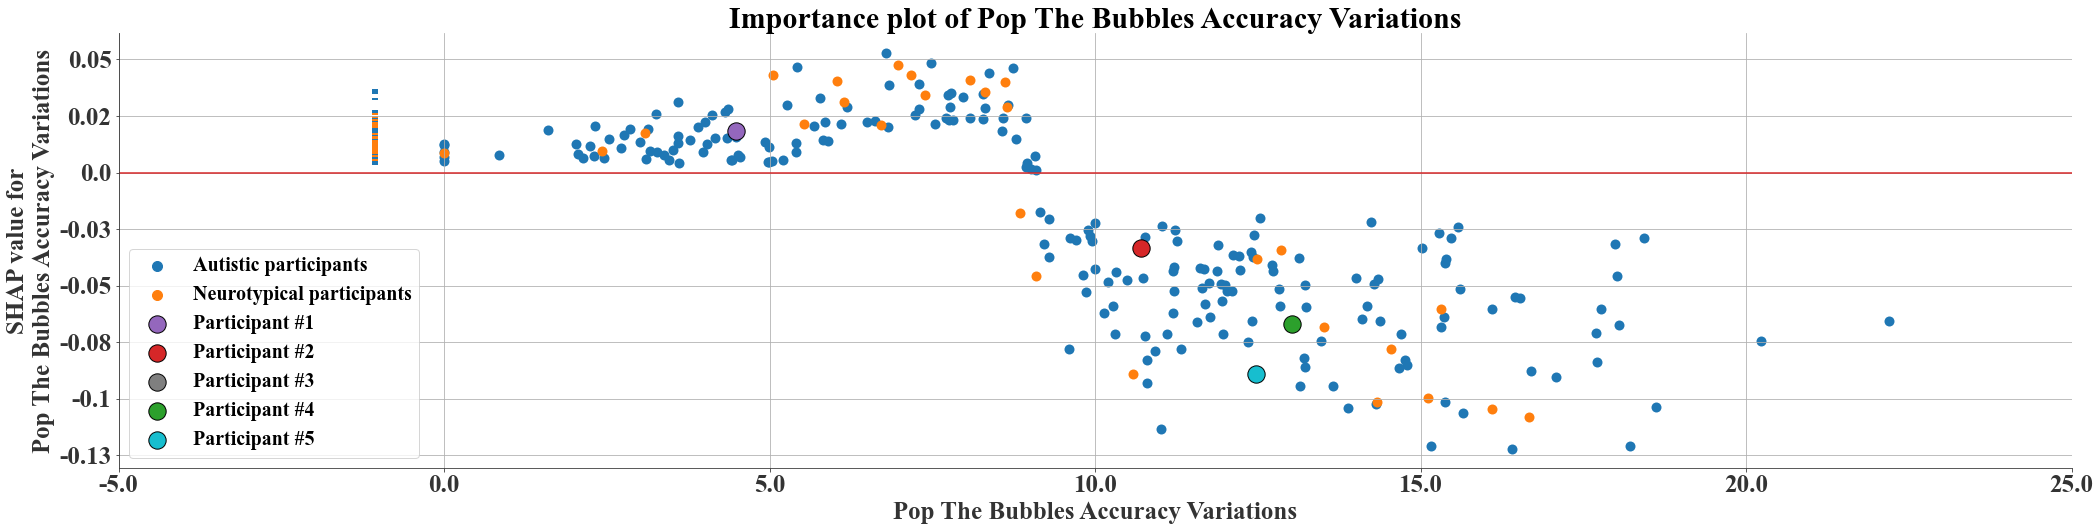

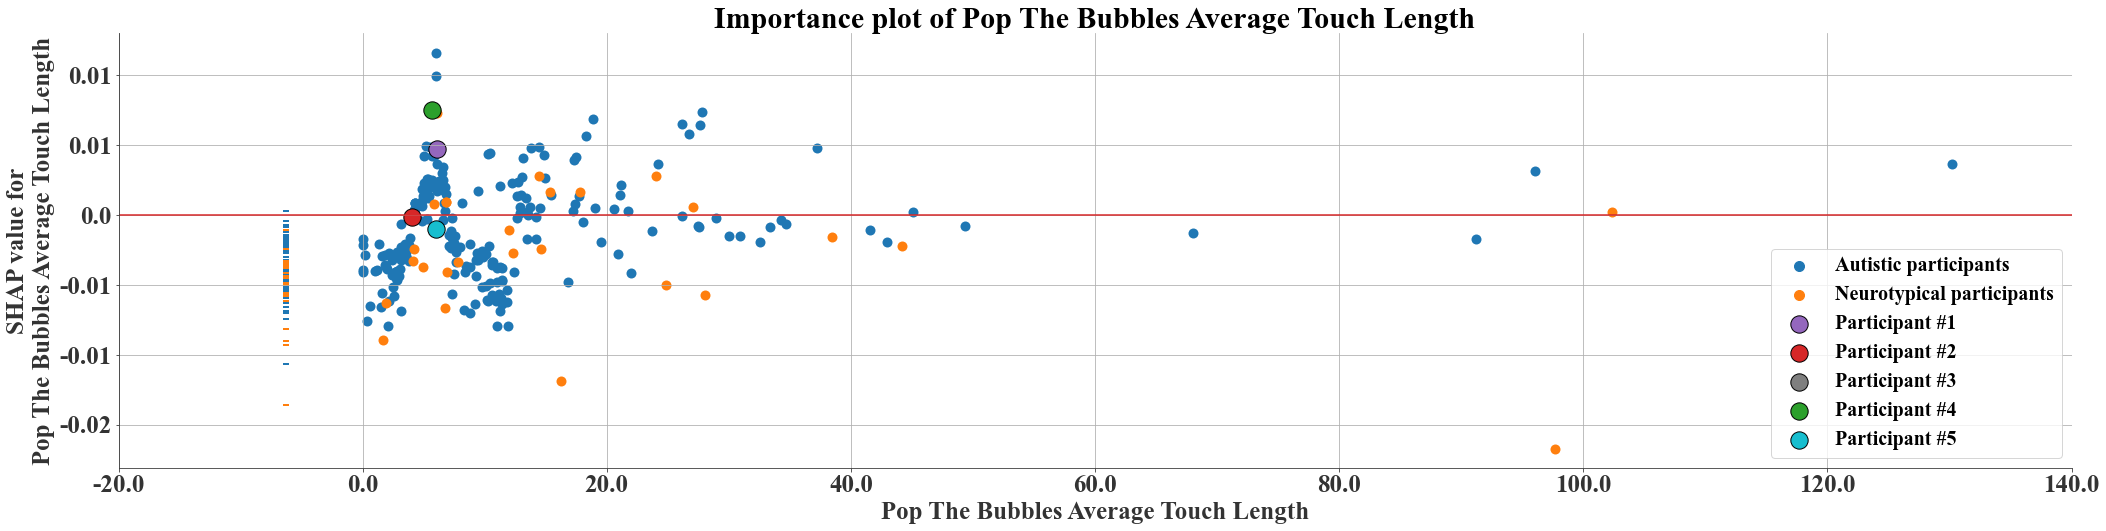

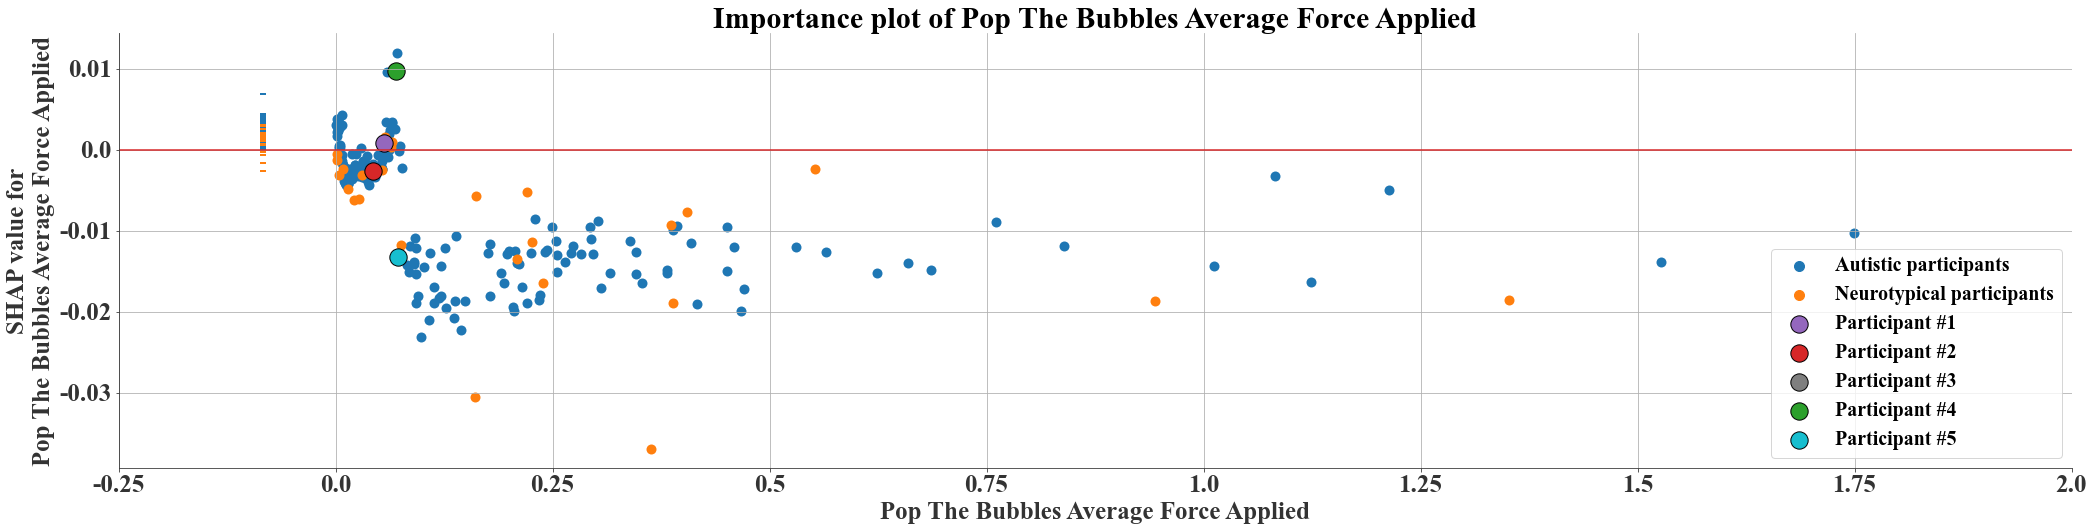

In [59]:
import matplotlib
csfont = {'fontname': 'Times New Roman'}
# Draw a random smaple and plot the shap matrix
averaged_shap_normalized = averaged_shap_interactions_normalized.sum(axis=1)

df_shap_interaction_importance = pd.DataFrame(np.abs(averaged_shap_interactions_normalized).mean(axis=0), columns=[feature_name_mapping[f] for f in exp.features_name], index=[feature_name_mapping[f] for f in exp.features_name])

idx_nt = np.array(data.df[data.df['diagnosis']==0].index)
idx_asd = np.array(data.df[data.df['diagnosis']==1].index)

X = pd.DataFrame(exp.dataset._X_train, columns=exp.features_name)
X.rename(columns=feature_name_mapping, inplace=True)
import shap
index_samples = [66, 165, 47, 107, 272]
from matplotlib.pylab import pcolor, colorbar


for i, feat in enumerate(exp.features_name):
    
    feature_name = feature_name_mapping[feat]
    
    most_interacting_feature  = df_shap_interaction_importance.loc[feature_name].nlargest(2).index[1]
    
    fig, ax = plt.subplots(1, 1, figsize=(35, 8))
    ax.axhline(0, color='tab:red')
    ax.set_title("Importance plot of {}".format(feature_name), weight='bold', fontsize=18)
    
    fig = shap.dependence_plot(feature_name, averaged_shap_normalized[idx_nt, :], X.iloc[idx_nt], [feature_name_mapping[f] for f in exp.features_name], x_jitter=0.1, dot_size=100, interaction_index=None, color='tab:blue', ax=ax, show=False)
    fig = shap.dependence_plot(feature_name, averaged_shap_normalized[idx_asd, :], X.iloc[idx_asd], [feature_name_mapping[f] for f in exp.features_name], x_jitter=0.1, dot_size=100, interaction_index=None, color='tab:orange', ax=ax, show=False)
    
    plt.gca().set_title(plt.gca().get_title(), weight='bold', fontsize=30, **csfont)
    plt.gca().set_xlabel(plt.gca().get_xlabel(), weight='bold', fontsize=25, **csfont)
    plt.gca().set_ylabel(plt.gca().get_ylabel(), weight='bold', fontsize=25, **csfont)
    plt.gca().grid()
    plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=25, **csfont)
    plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=25, **csfont)
    plt.gca().scatter([X.to_numpy()[index_samples[0], i]], [averaged_shap_normalized[index_samples[0], i]], s=100, color='tab:blue', label='Autistic participants')
    plt.gca().scatter([X.to_numpy()[index_samples[0], i]], [averaged_shap_normalized[index_samples[0], i]], s=100, color='tab:orange', label='Neurotypical participants')
    
    plt.gca().scatter([X.to_numpy()[index_samples[0], i]], [averaged_shap_normalized[index_samples[0], i]], s=300, color='#9467bd', edgecolors='k',  label='Participant #1')
    plt.gca().scatter([X.to_numpy()[index_samples[1], i]], [averaged_shap_normalized[index_samples[1], i]], s=300, color='#d62728', edgecolors='k', label='Participant #2')
    plt.gca().scatter([X.to_numpy()[index_samples[2], i]], [averaged_shap_normalized[index_samples[2], i]], s=300, color='#7f7f7f', edgecolors='k', label='Participant #3')
    plt.gca().scatter([X.to_numpy()[index_samples[3], i]], [averaged_shap_normalized[index_samples[3], i]], s=300, color='#2ca02c', edgecolors='k', label='Participant #4')
    plt.gca().scatter([X.to_numpy()[index_samples[4], i]], [averaged_shap_normalized[index_samples[4], i]], s=300, color='#17becf', edgecolors='k', label='Participant #5')
    
    plt.gca().legend(prop={'size':20, 'family':'times new roman', 'weight':'bold'})
    os.makedirs(os.path.join(ROOT_DIR, 'figures_final'), exist_ok=True)
    plt.savefig(os.path.join(ROOT_DIR, 'figures_final', 'dependence_{}.png'.format(feature_name)), dpi=200, bbox_inches = 'tight')
    plt.show()


0.77


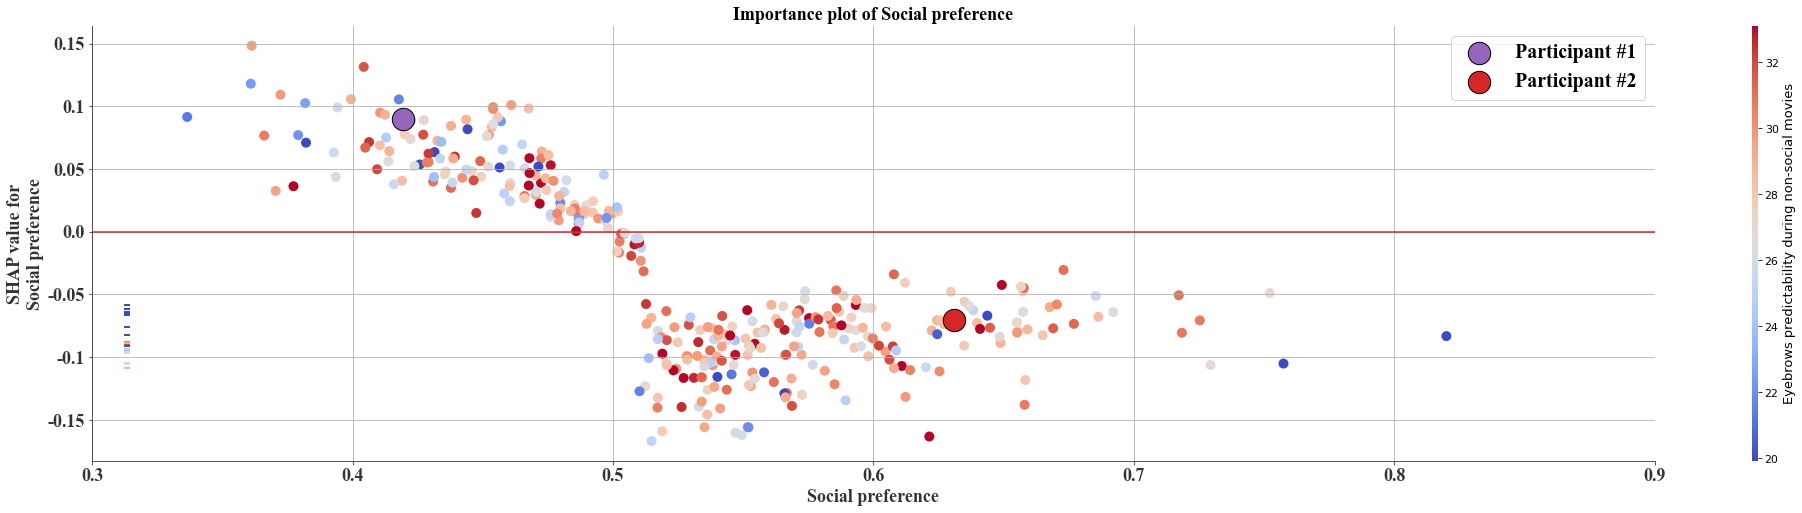

0.38


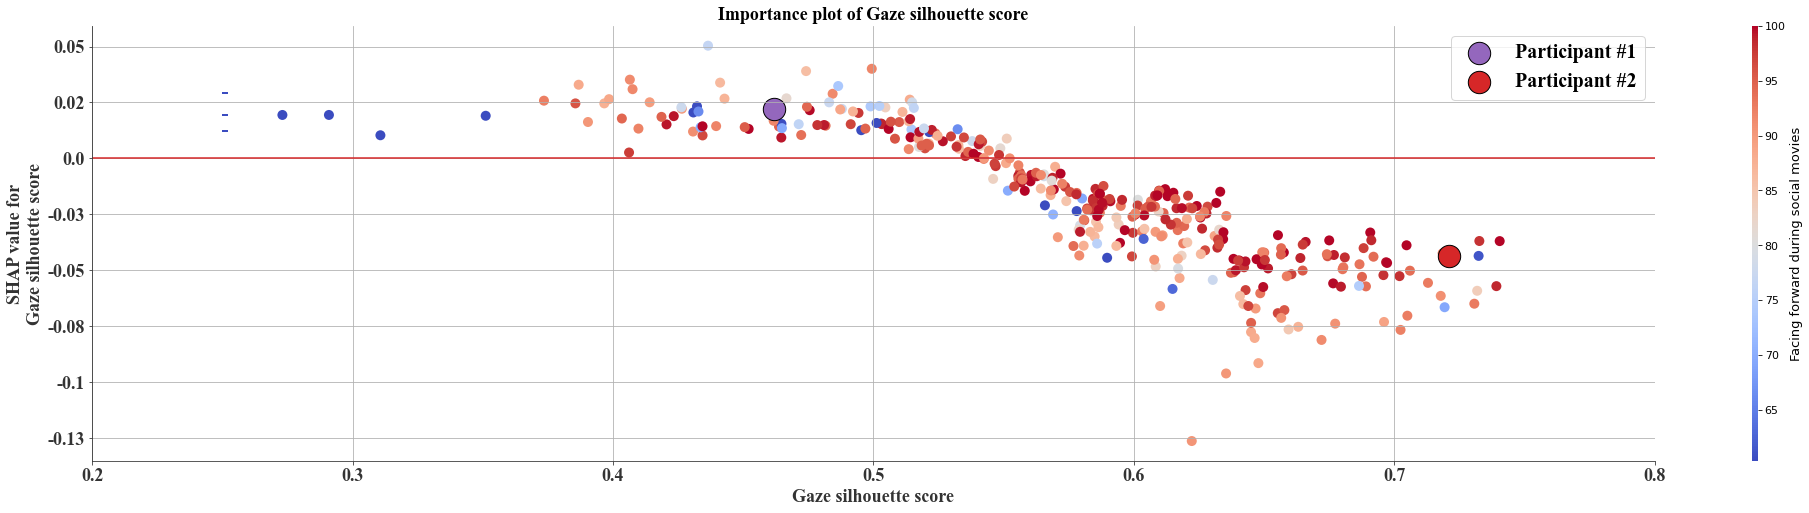

0.23


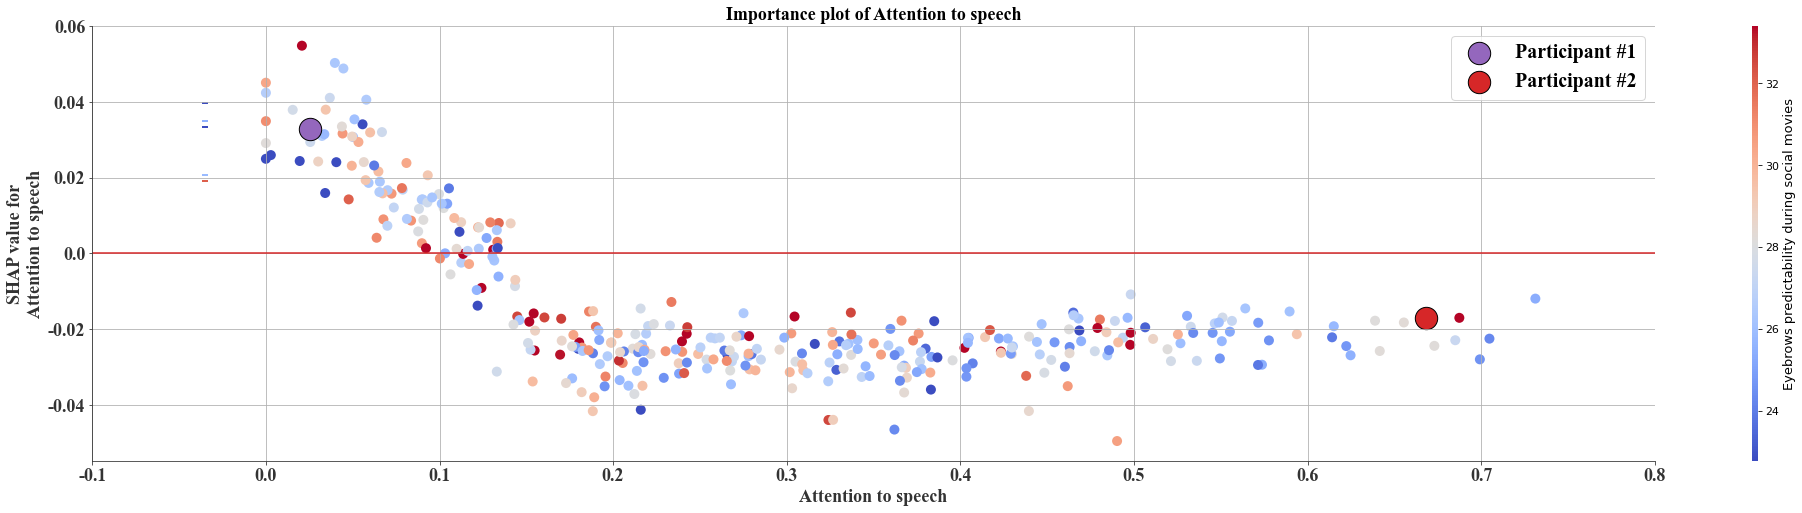

0.35


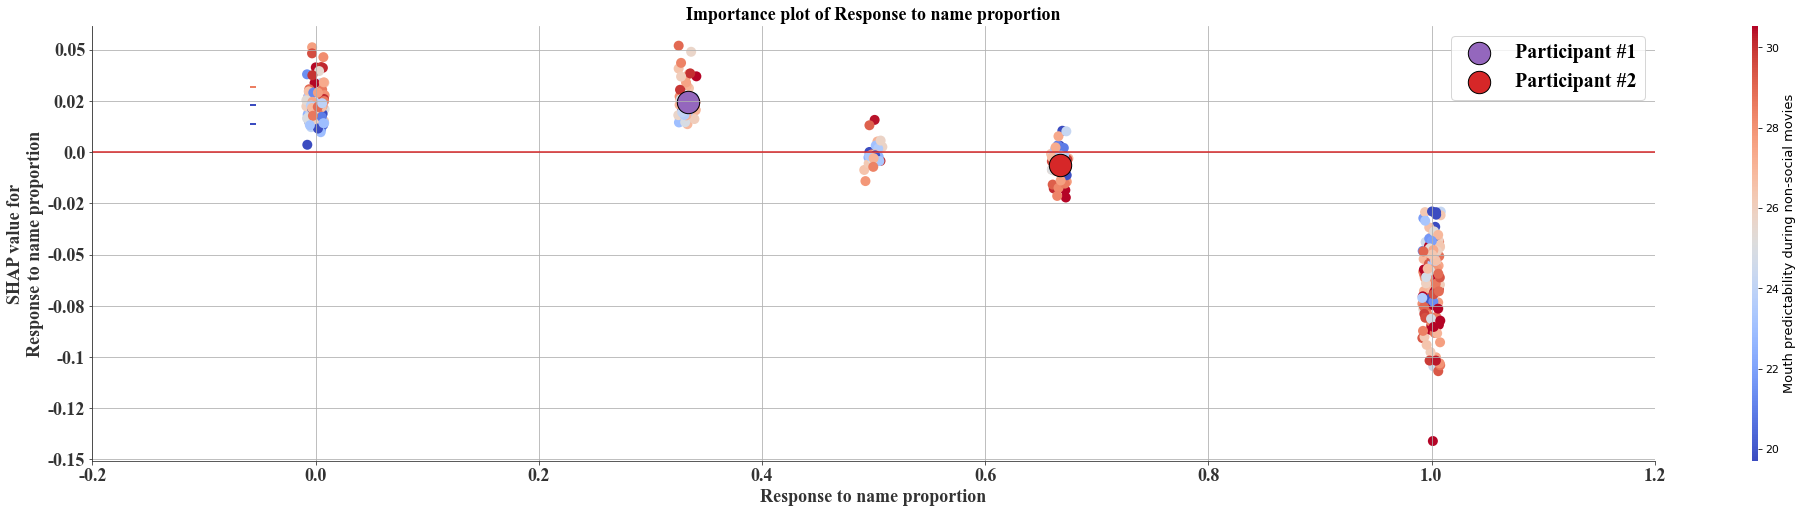

0.43


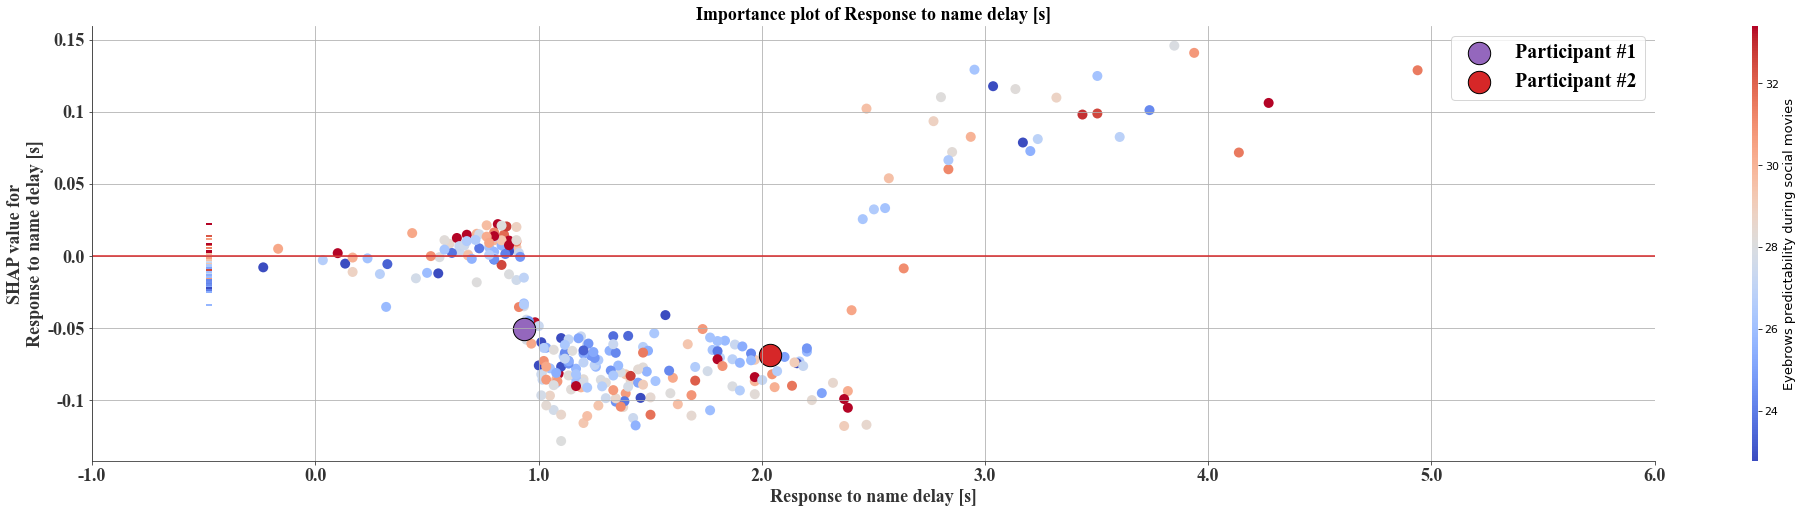

0.27


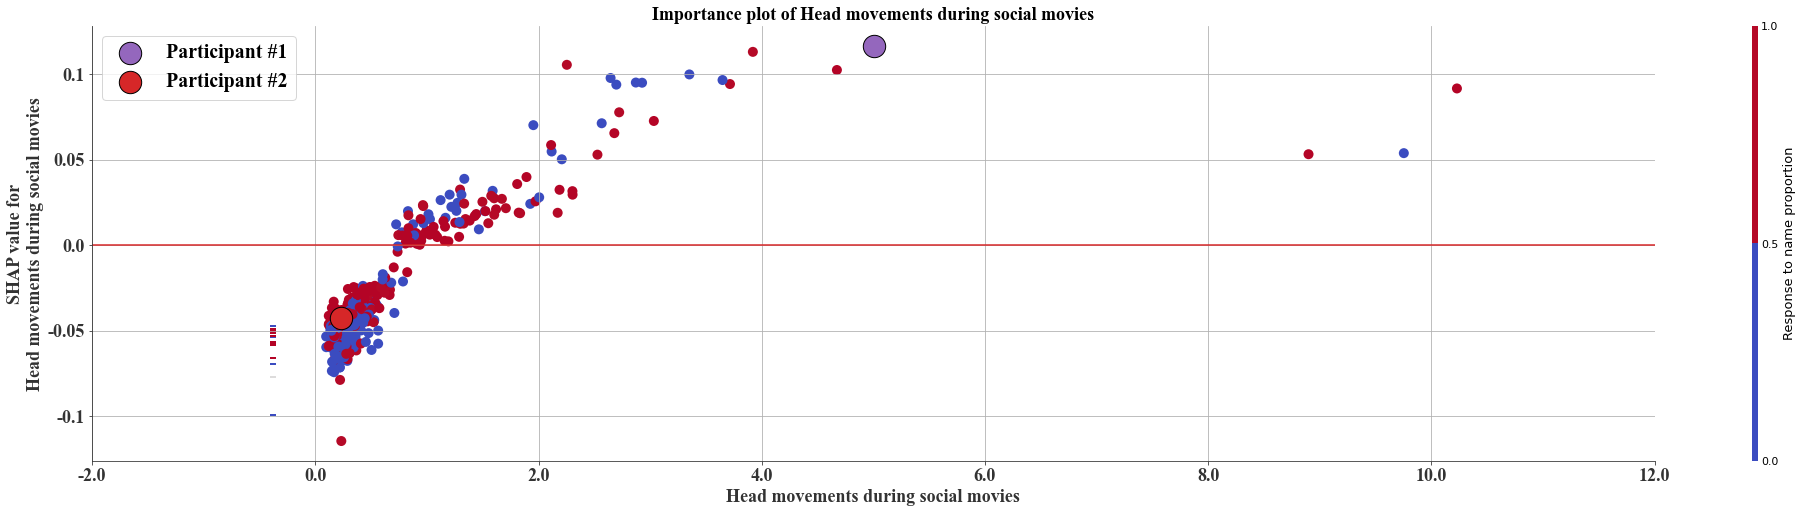

0.39


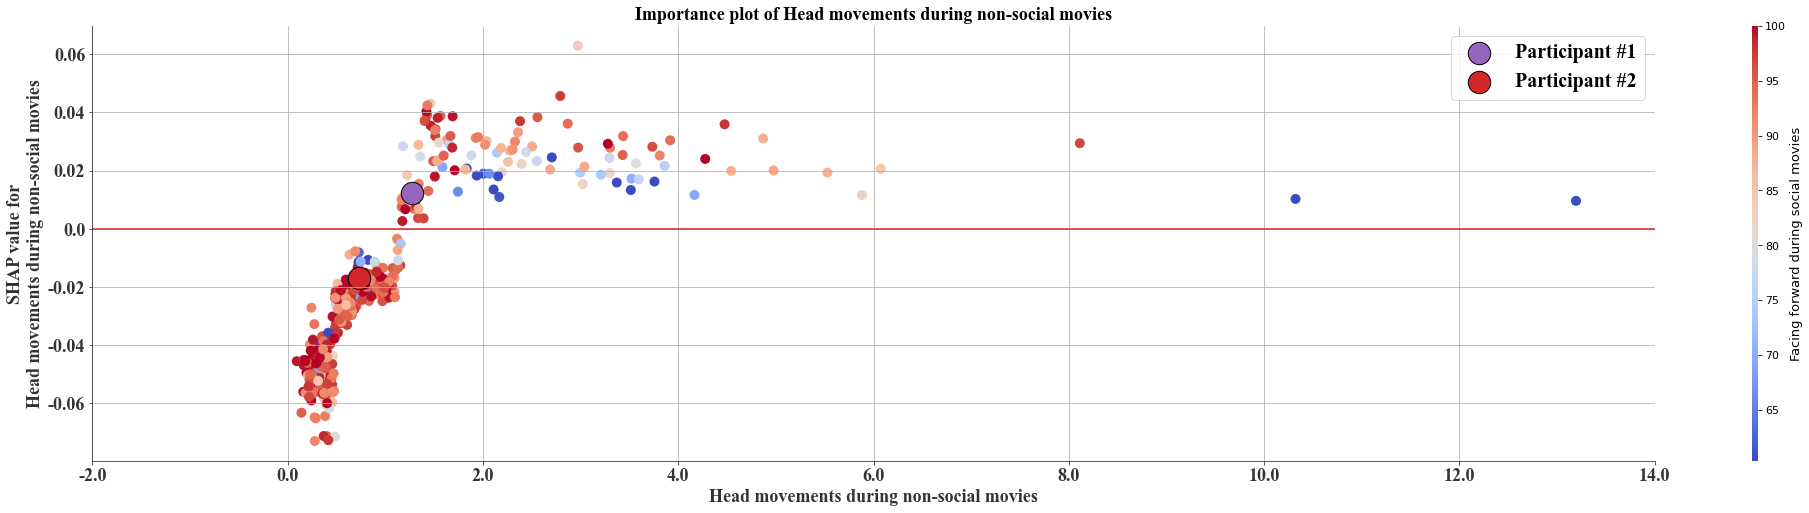

0.1


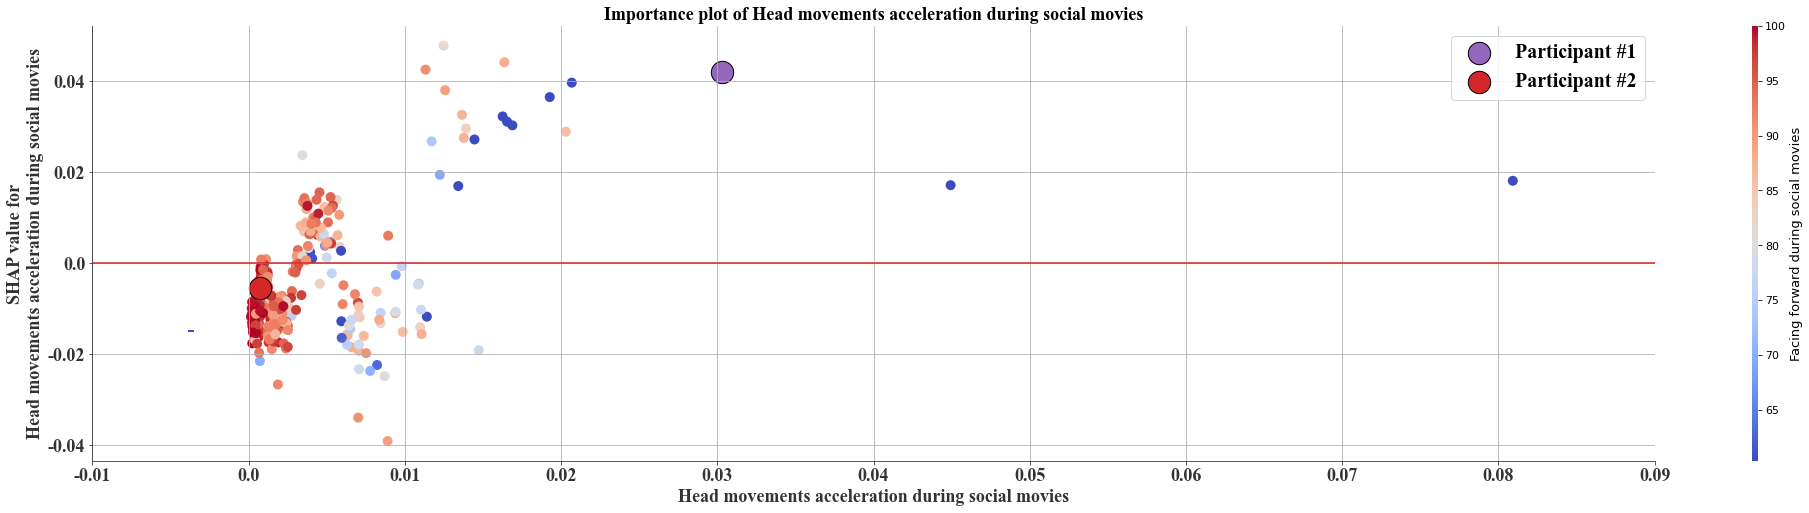

0.23


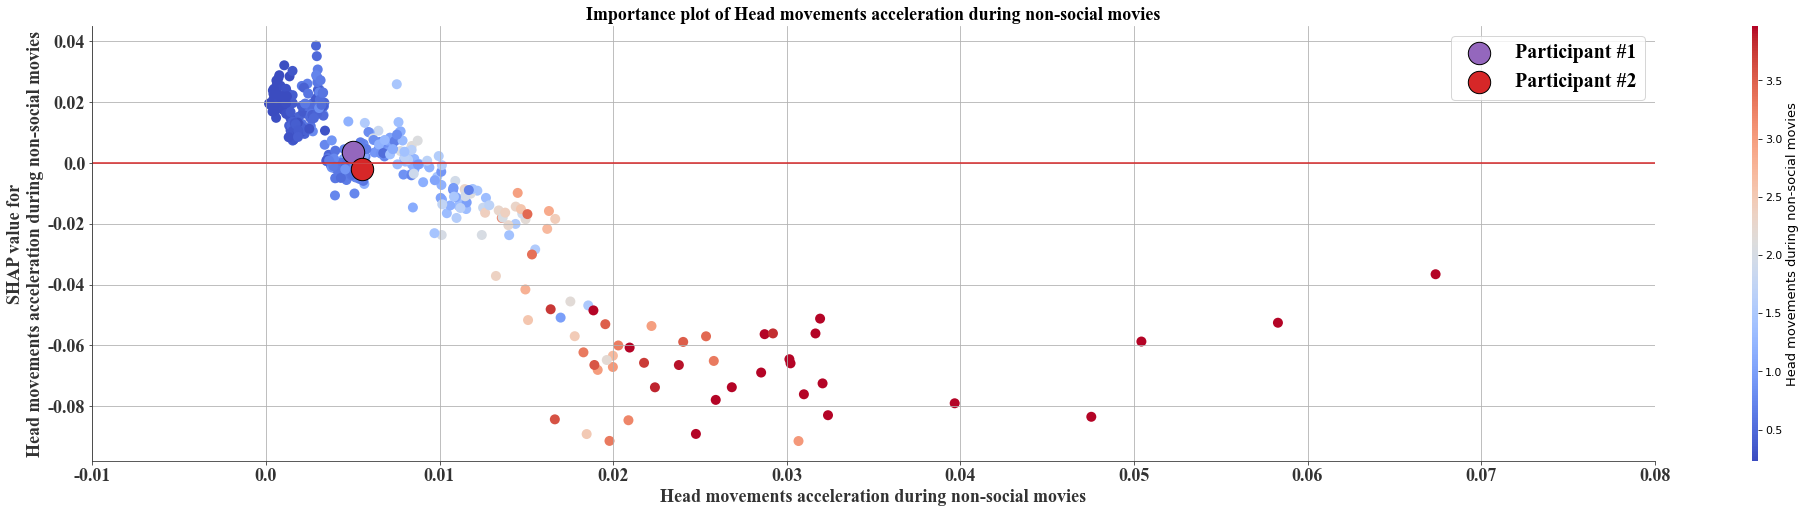

0.26


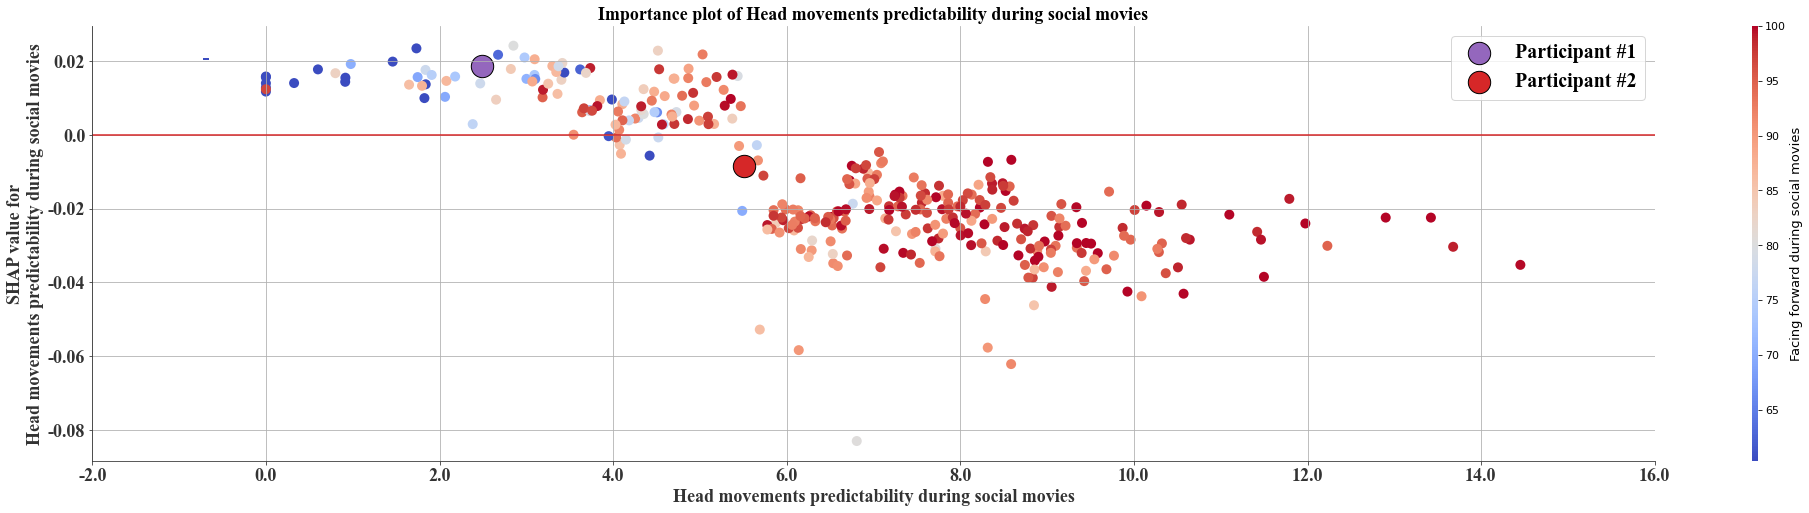

0.21


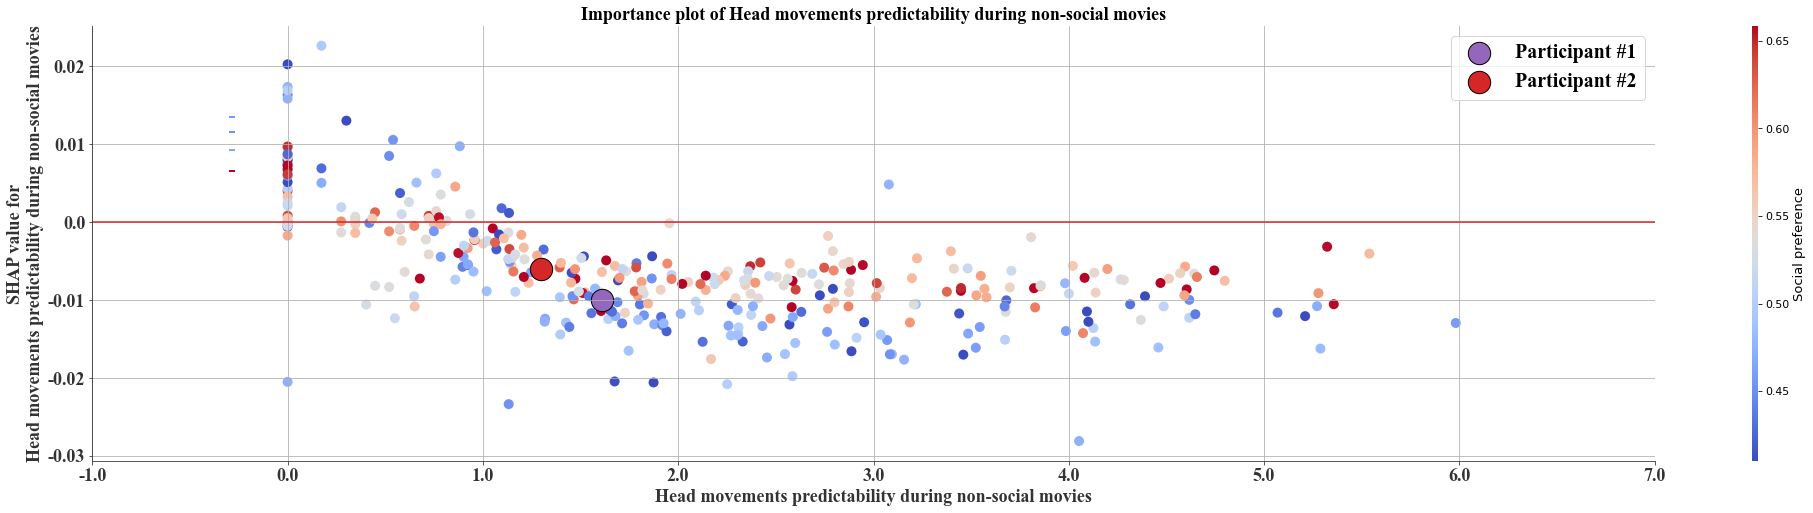

0.66


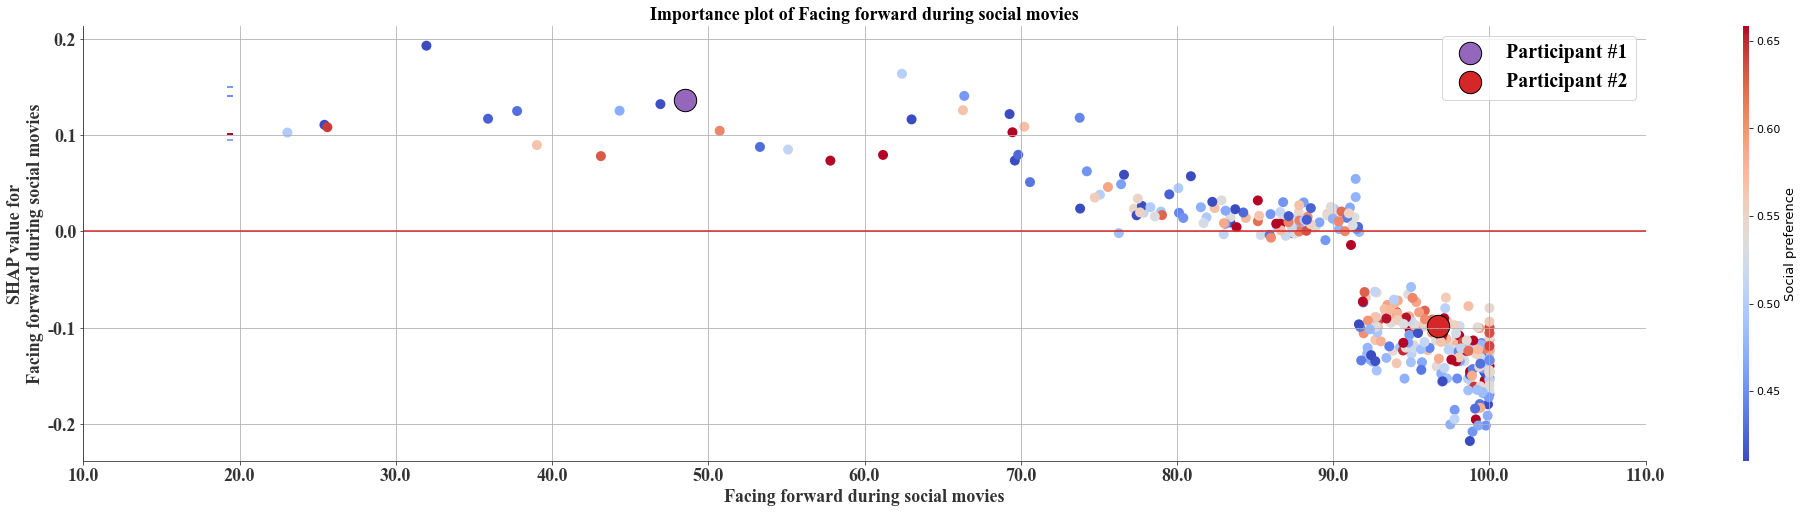

0.51


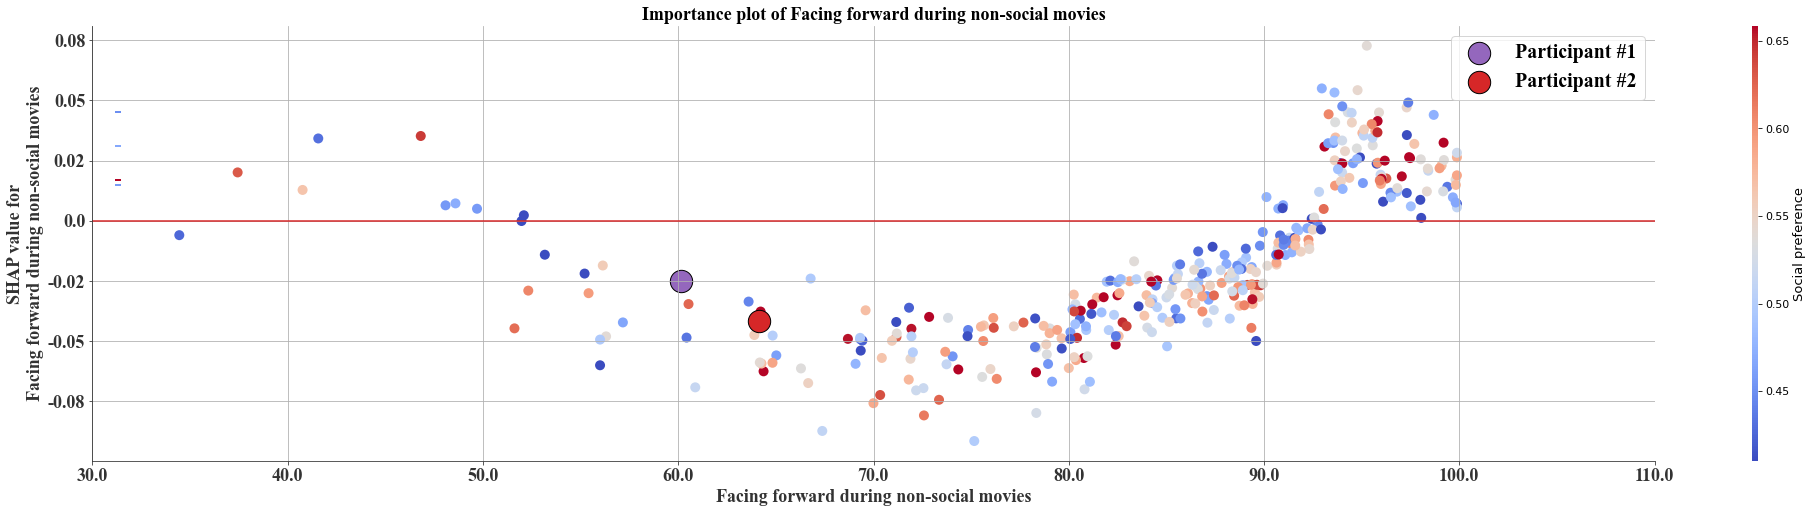

0.43


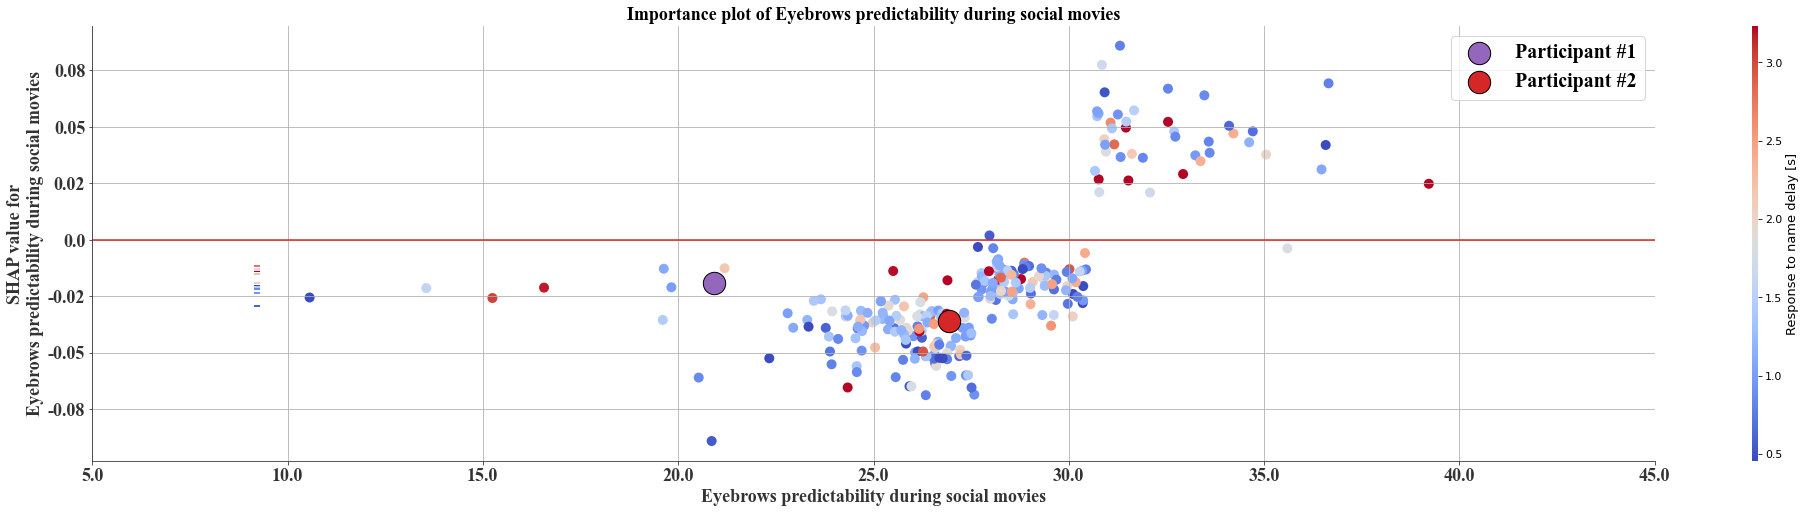

0.77


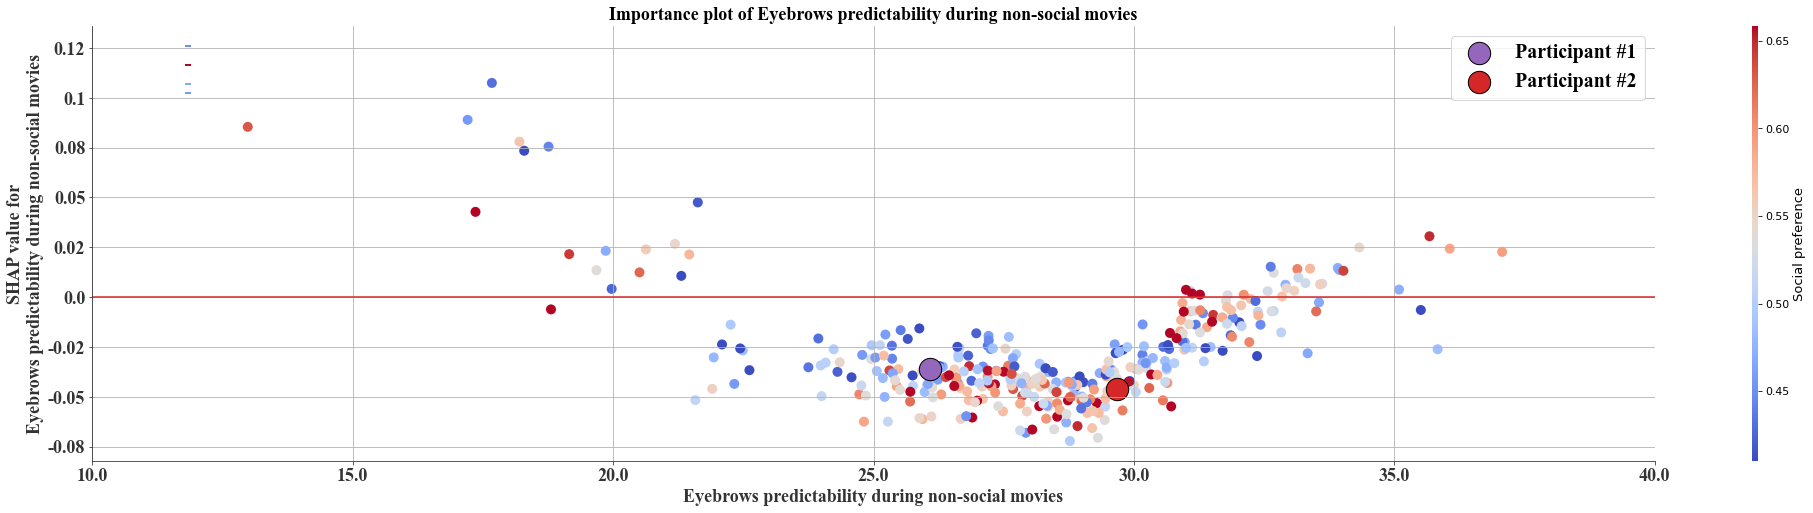

0.34


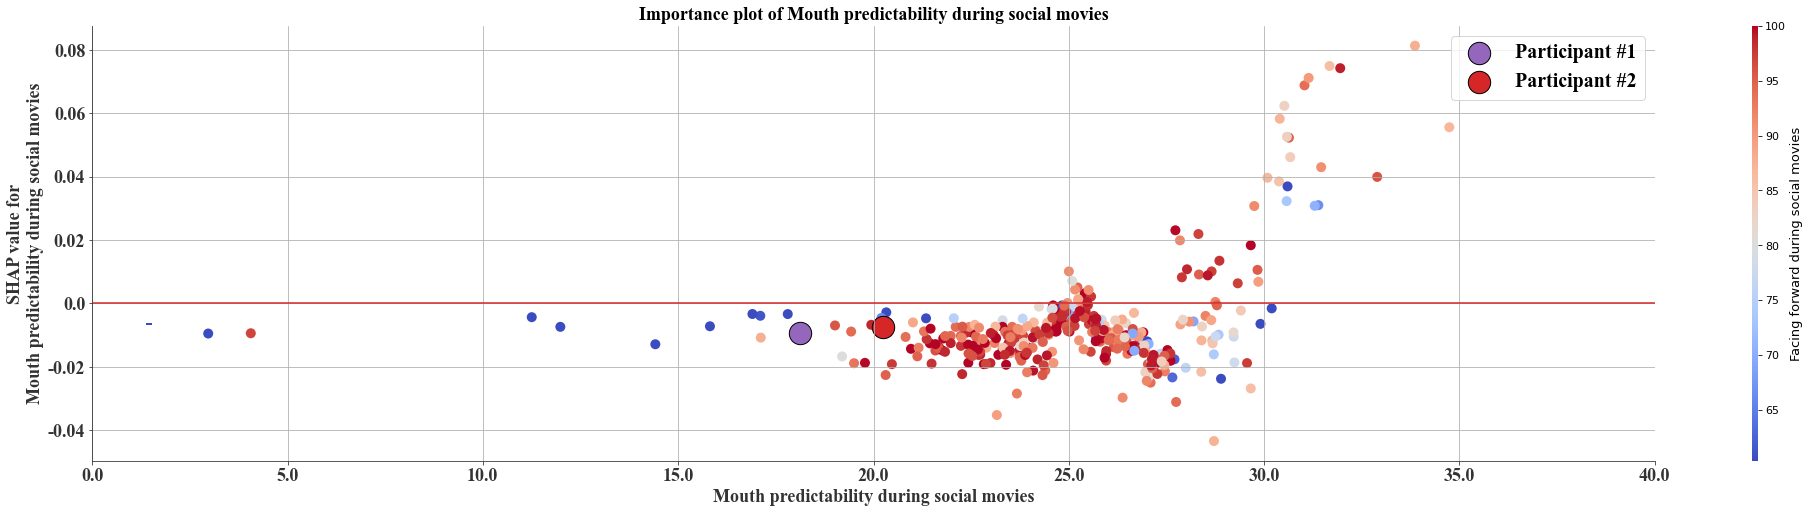

0.35


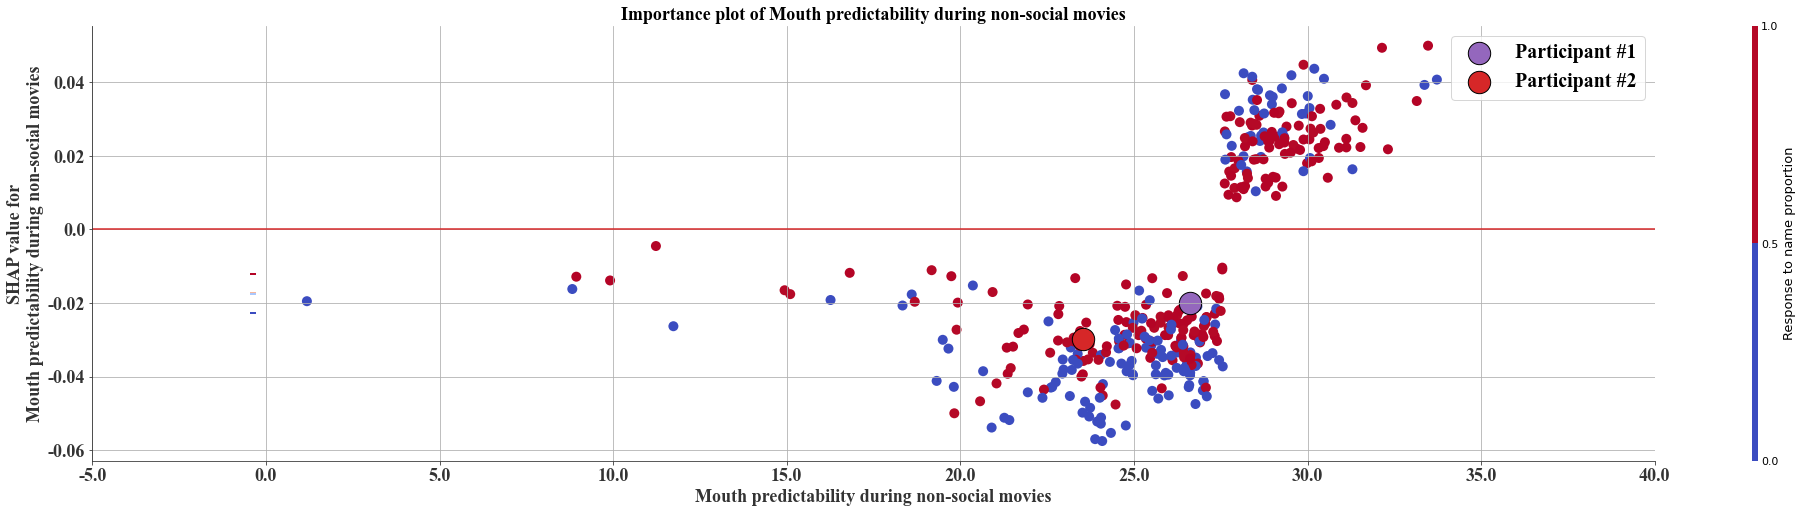

0.13


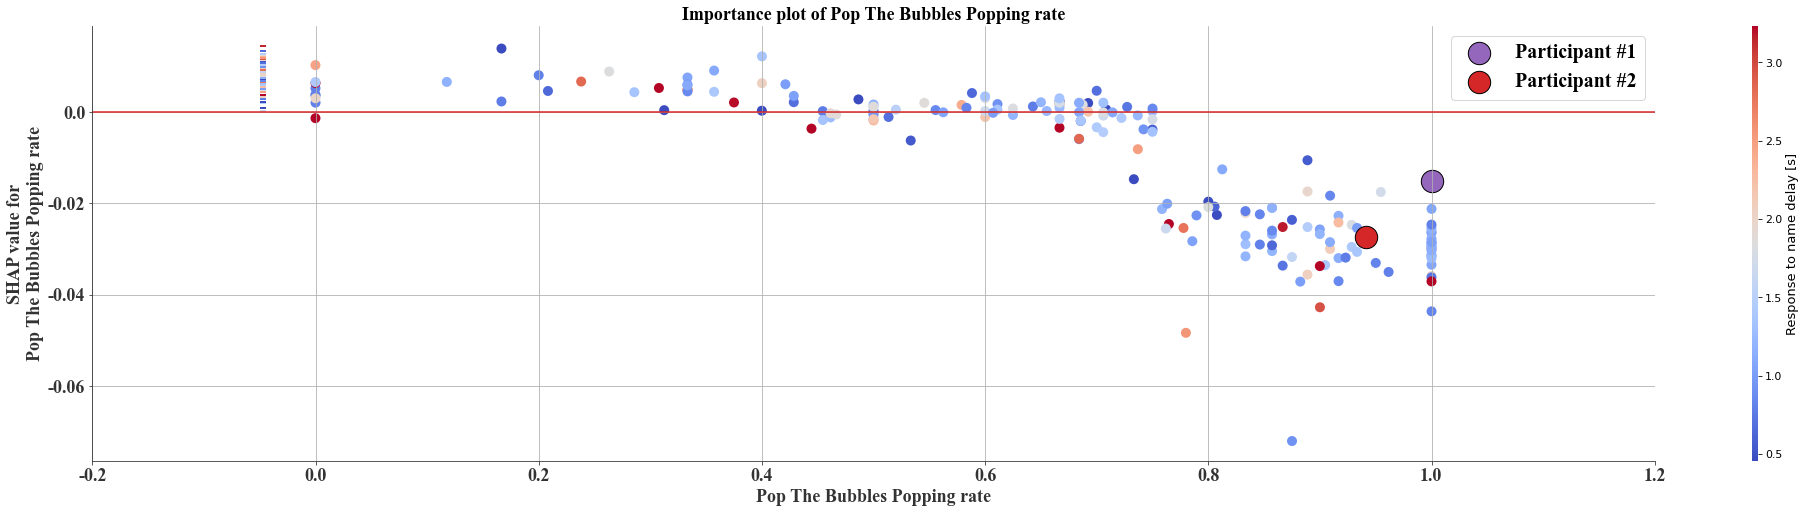

0.39


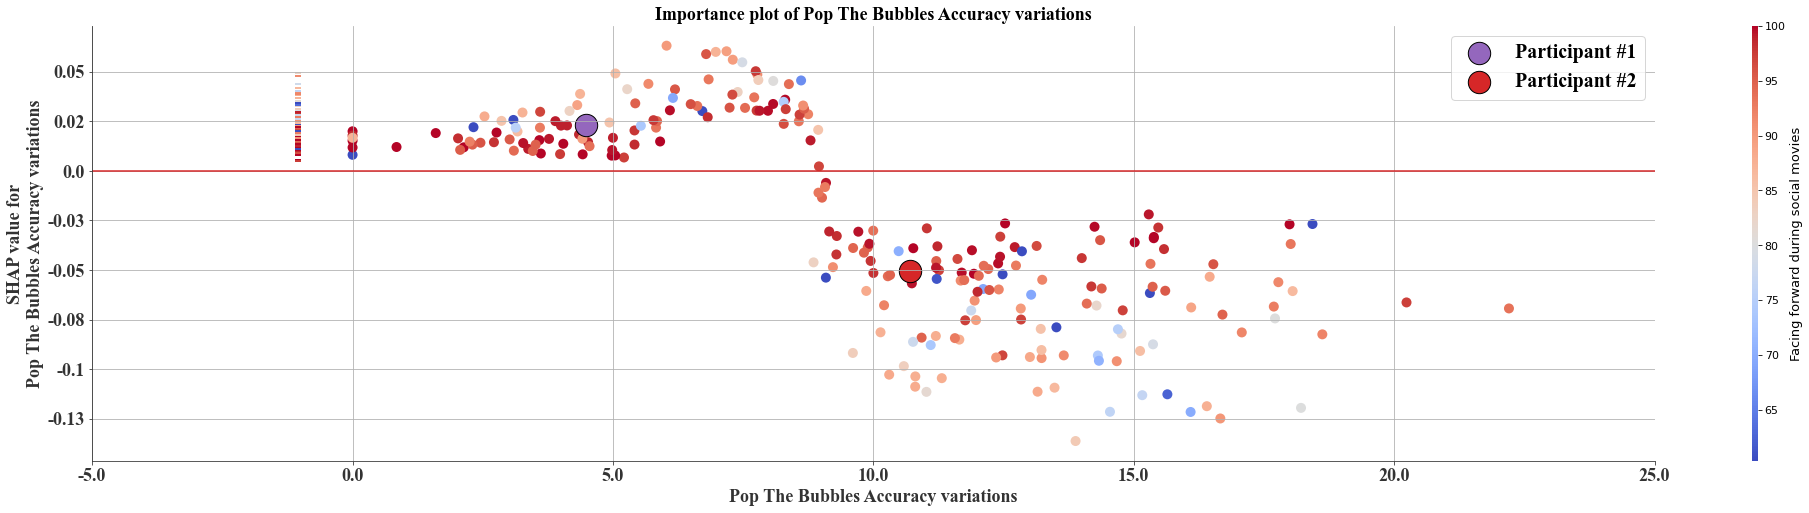

0.07


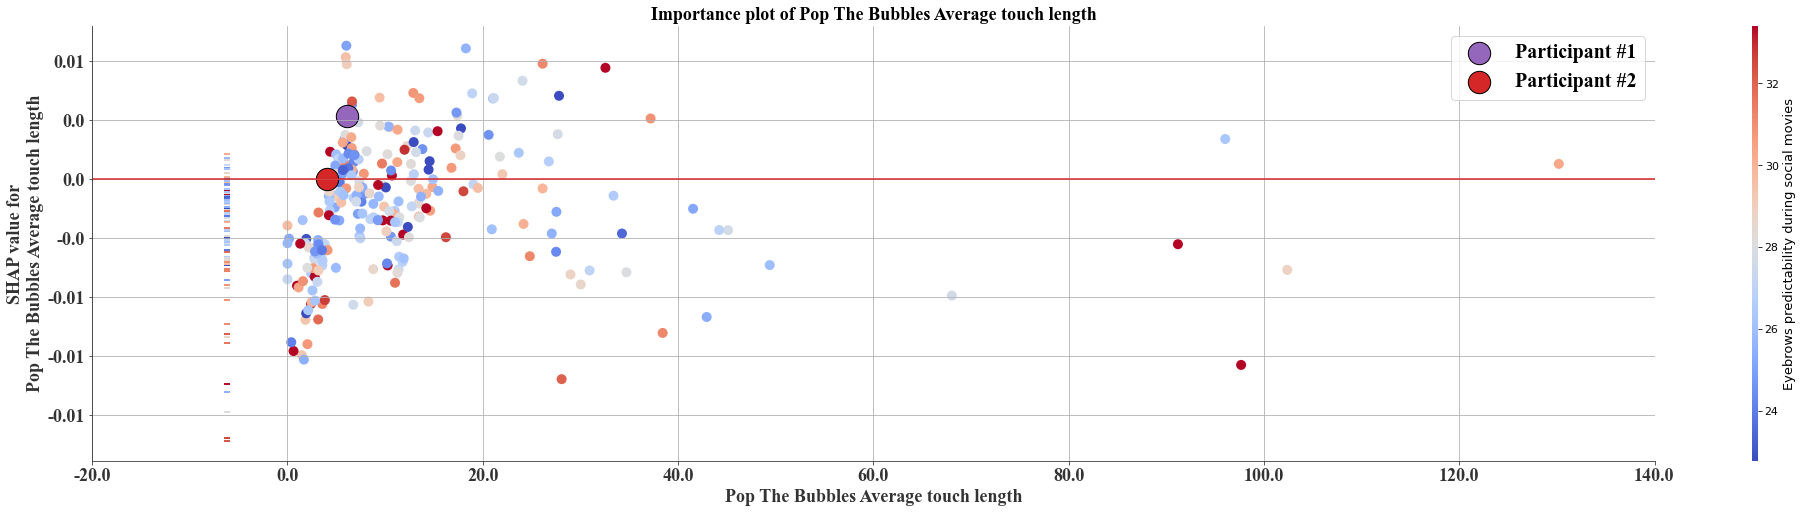

0.14


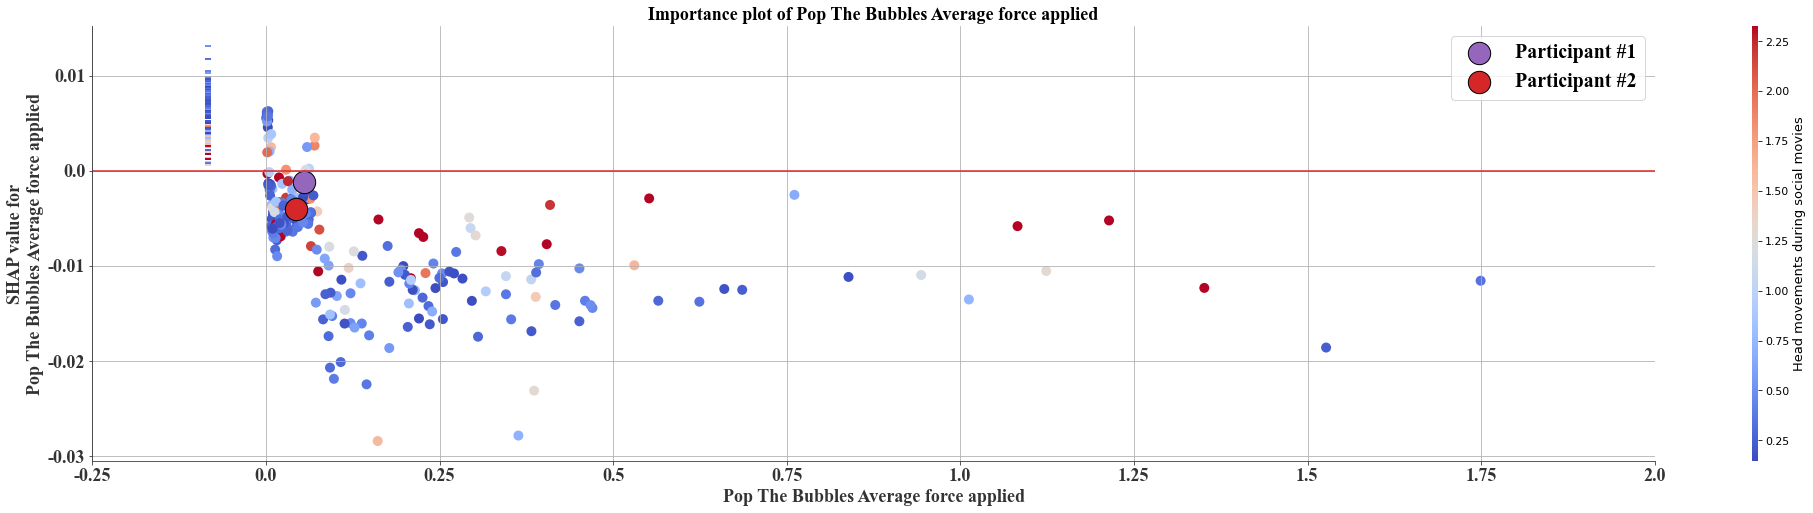

In [126]:
import matplotlib
csfont = {'fontname': 'Times New Roman'}
# Draw a random smaple and plot the shap matrix
averaged_shap_normalized = averaged_shap_interactions_normalized.sum(axis=1)

df_shap_interaction_importance = pd.DataFrame(np.abs(averaged_shap_interactions_normalized).mean(axis=0), columns=[feature_name_mapping[f] for f in exp.features_name], index=[feature_name_mapping[f] for f in exp.features_name])


X = pd.DataFrame(exp.dataset._X_train, columns=exp.features_name)
X.rename(columns=feature_name_mapping, inplace=True)
import shap
index_samples = [66, 165]
from matplotlib.pylab import pcolor, colorbar


for i, feat in enumerate(exp.features_name):
    
    feature_name = feature_name_mapping[feat]
    
    most_interacting_feature  = df_shap_interaction_importance.loc[feature_name].nlargest(2).index[1]
    
    fig, ax = plt.subplots(1, 1, figsize=(35, 8))
    ax.axhline(0, color='tab:red')
    ax.set_title("Importance plot of {}".format(feature_name), weight='bold', fontsize=18)
    
    fig = shap.dependence_plot(feature_name, averaged_shap_normalized, X, [feature_name_mapping[f] for f in exp.features_name], x_jitter=0.1, dot_size=100, interaction_index=most_interacting_feature, cmap=matplotlib.cm.coolwarm, ax=ax, show=False)
    
    
    plt.gca().set_title(plt.gca().get_title(), weight='bold', fontsize=18, **csfont)
    plt.gca().set_xlabel(plt.gca().get_xlabel(), weight='bold', fontsize=18, **csfont)
    plt.gca().set_ylabel(plt.gca().get_ylabel(), weight='bold', fontsize=18, **csfont)
    plt.gca().grid()
    plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
    plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
    
    plt.gca().scatter([X.to_numpy()[index_samples[0], i]], [averaged_shap_normalized[index_samples[0], i]], s=500, color='#9467bd', edgecolors='k',  label='Participant #1')
    plt.gca().scatter([X.to_numpy()[index_samples[1], i]], [averaged_shap_normalized[index_samples[1], i]], s=500, color='#d62728', edgecolors='k', label='Participant #2')
    plt.gca().legend(prop={'size':20, 'family':'times new roman', 'weight':'bold'})
    print(best_interaction.loc[feature_name]['Value'])
    plt.show()
    #plt.savefig(os.path.join(ROOT_DIR, 'figures', '{}_dependence.png'.format(feature_name)), dpi=200, bbox_inches = 'tight')



# Global app features importance 

In [213]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/multimodal_paper_final/SenseToKnow/'

json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)
shap_interactions = 

(100, 377, 23, 23)

**Computation of the feature impotance by summing over the interactions effect**

In [64]:
shap_values = shap_interactions.sum(axis=2)
shap_values.shape

(1000, 377, 23)

**Normalization of the Shap values for each individuals so that the Shap values are comparable, given that they come from differet models being trained.**

In [65]:
shap_values_n = shap_values / np.abs(shap_values).sum(axis=2)[:, :, np.newaxis]

np.abs(shap_values_n[0, 0]).sum()

1.0

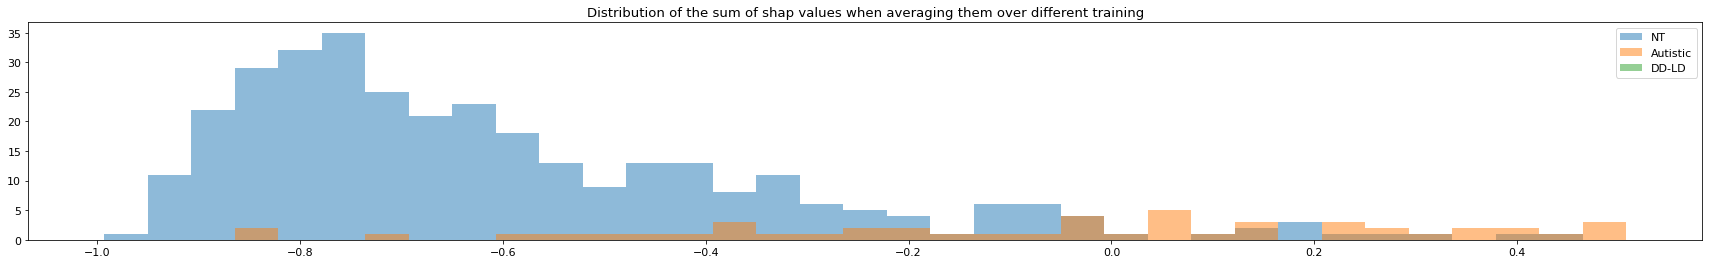

In [219]:
shap_values_averaged = shap_values_n.mean(axis=0)

fi(30, 4)
plt.title("Distribution of the sum of shap values when averaging them over different training")
_, _, _ = plt.hist(shap_values_averaged[i_nt].sum(axis=1), bins=bins, label='NT',alpha=.5, color='tab:blue')
_, _, _ = plt.hist(shap_values_averaged[i_asd].sum(axis=1), bins=bins,  label='Autistic',alpha=.5, color='tab:orange')
_, _, _ = plt.hist(shap_values_averaged[i_ddld].sum(axis=1), bins=bins,  label='DD-LD',alpha=.5, color='tab:green')


_  = plt.legend()

**Note that the Shap values of the samples are no longer normalized because of the averaging over different training, see here the average sum of absolute shap values:**

In [67]:
np.abs(shap_values_averaged).sum(axis=1).mean()

0.916618276799578

**We therefore renormalize them**

In [68]:
shap_values_averaged_n = shap_values_averaged / np.abs(shap_values_averaged).sum(axis=1)[:, np.newaxis]
np.abs(shap_values_averaged_n).sum(axis=1).mean()

1.0

**We now check that the final Shap values for 5 random samples are consistent with what we can observe during a random taining for a sample**

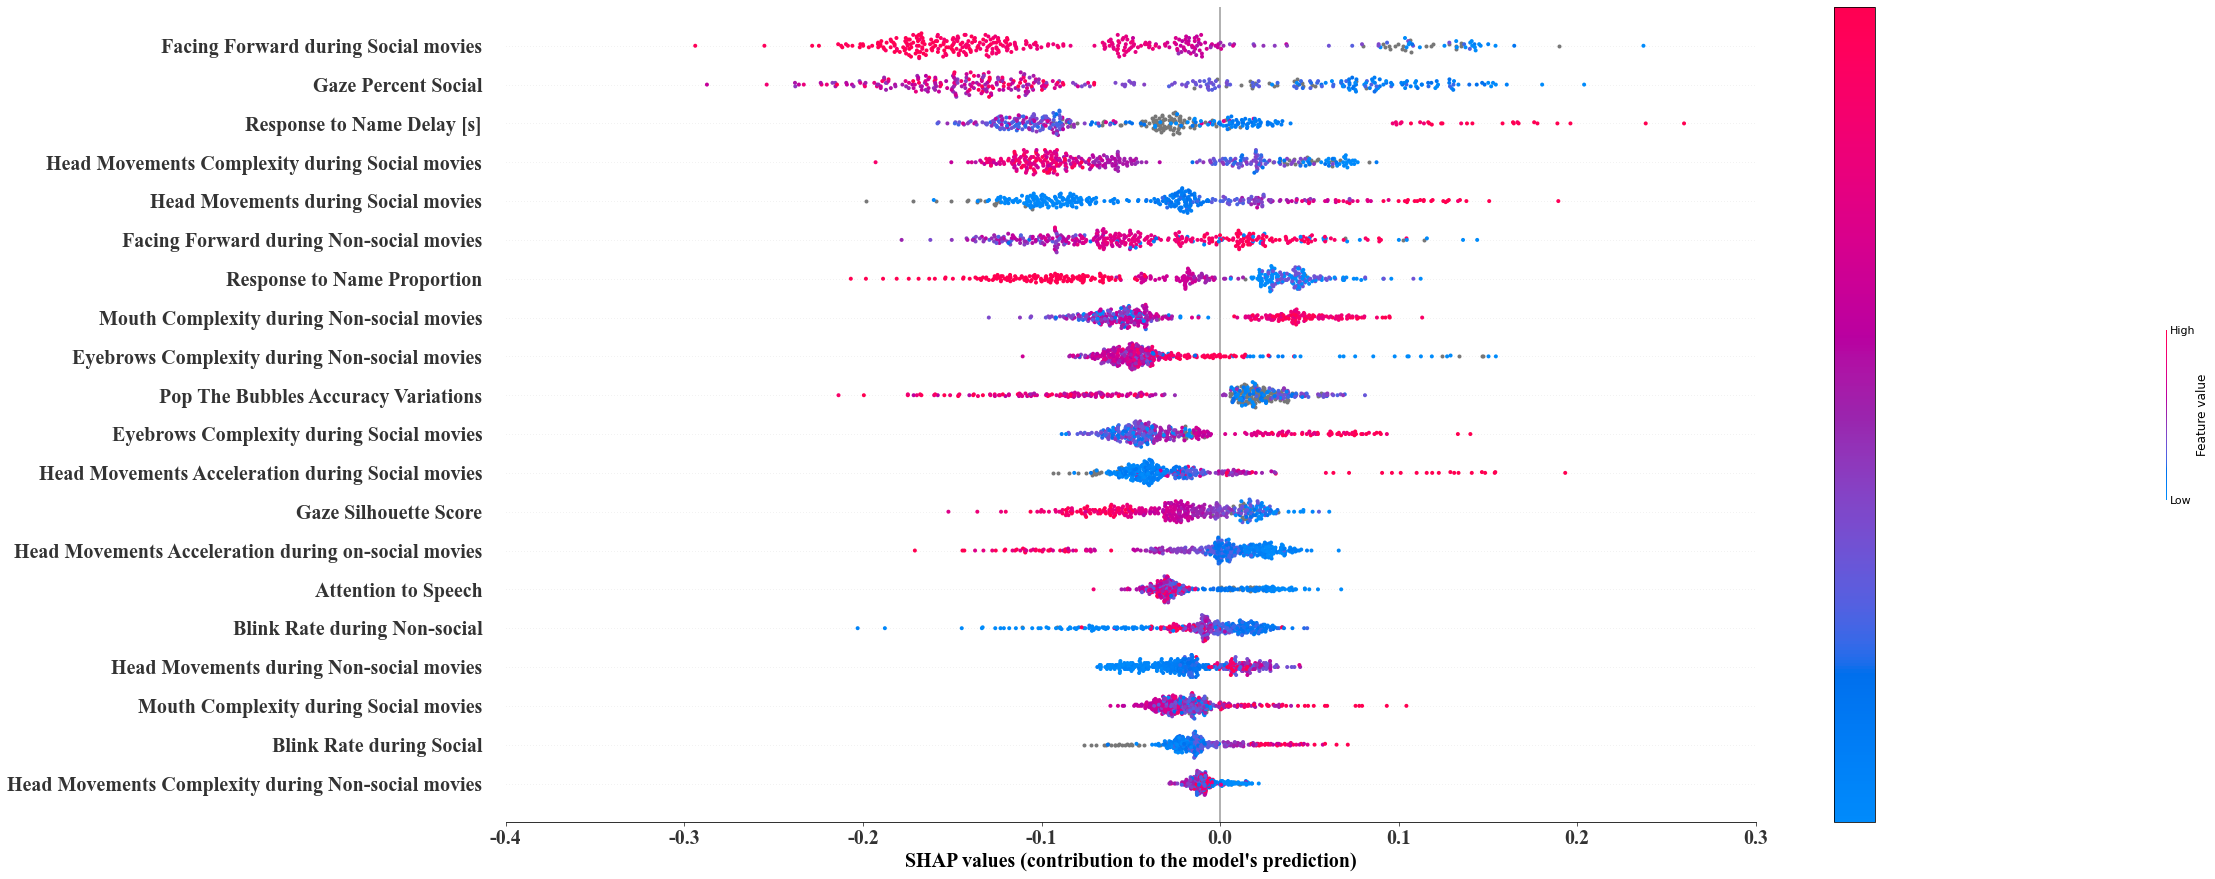

In [71]:
import shap
fig = shap.summary_plot(shap_values_averaged_n, exp.dataset._X_train, feature_names = [feature_name_mapping[f] for f in exp.features_name], plot_size=(35, 15), show=False)# plot_type='bar')

ax= plt.gca()
list_labels = [l._text for l in  ax.get_yticklabels()]
ax.set_yticks(ax.get_yticks(), list_labels, weight='bold', fontsize=20, **csfont)
ax.set_xticks(ax.get_xticks(), np.round(ax.get_xticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)
ax.set_xlabel("SHAP values (contribution to the model's prediction)", weight='bold', fontsize=20, **csfont)

ax.set_facecolor('white')
plt.gcf().patch.set_facecolor('white')
plt.colorbar(ticks=range(6), label='')

plt.savefig(os.path.join(ROOT_DIR, 'figures_final', 'features_importance.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')

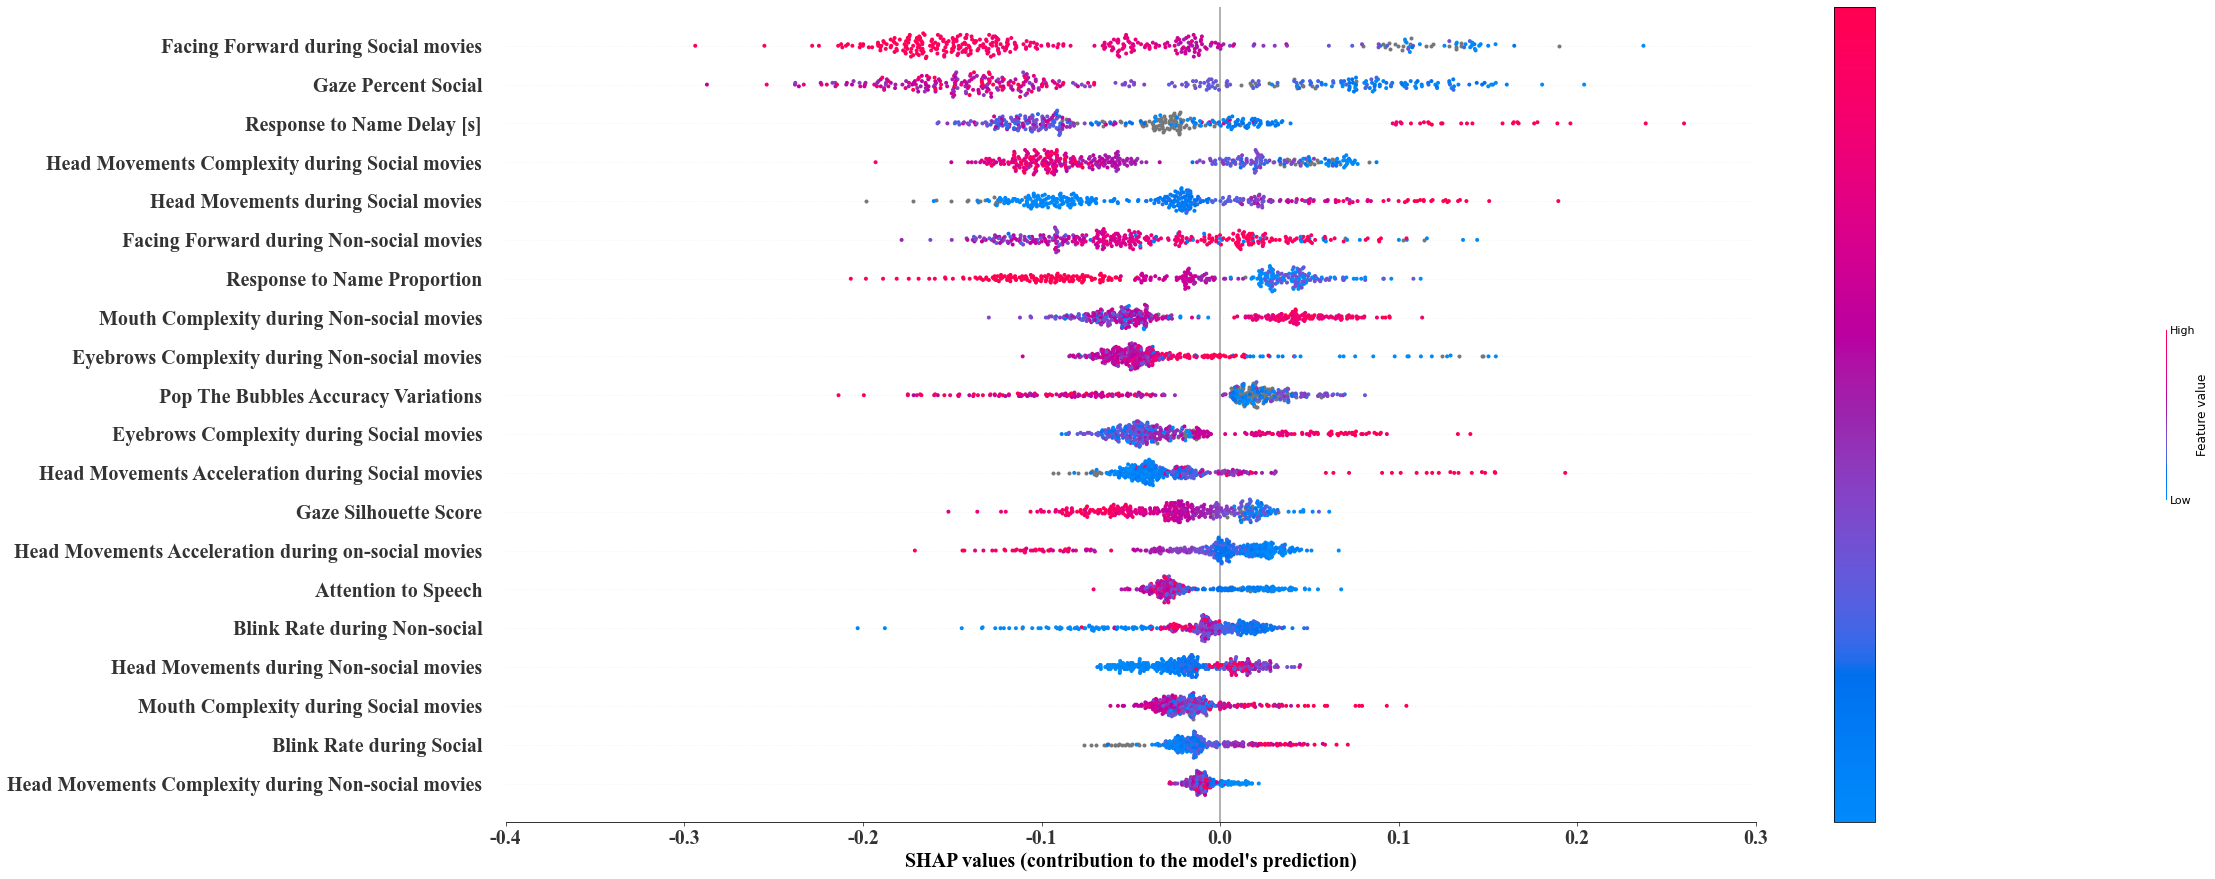

In [112]:
import shap

fig = shap.summary_plot(shap_values_averaged_n, exp.dataset._X_train, feature_names = [feature_name_mapping[f] for f in exp.features_name], 
                        plot_size=(35, 15), show=False)# plot_type='bar')

ax= plt.gca()
list_labels = [l._text for l in  ax.get_yticklabels()]
ax.set_yticks(ax.get_yticks(), list_labels, weight='bold', fontsize=20, **csfont)
ax.set_xticks(ax.get_xticks(), np.round(ax.get_xticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)
ax.set_xlabel("SHAP values (contribution to the model's prediction)", weight='bold', fontsize=20, **csfont)

ax.set_facecolor('white')
plt.gcf().patch.set_facecolor('white')
plt.colorbar(ticks=range(6), label='')

#plt.savefig(os.path.join(ROOT_DIR, 'figures_final', 'features_importance.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [114]:
[(feat, val, std) for feat, val, std in zip(exp.features_name, np.round(np.abs(shap_values_averaged_n).mean(axis=0)*100, 2), np.round(np.abs(shap_values_averaged_n).std(axis=0)*100, 2))]

[('mean_gaze_percent_right', 11.09, 5.65),
 ('gaze_silhouette_score', 3.31, 2.65),
 ('FP_gaze_speech_correlation', 2.75, 1.1),
 ('proportion_of_name_call_responses', 5.98, 4.03),
 ('average_response_to_name_delay', 7.09, 4.89),
 ('S_postural_sway', 6.34, 4.27),
 ('NS_postural_sway', 2.58, 1.67),
 ('S_postural_sway_derivative', 3.94, 2.65),
 ('NS_postural_sway_derivative', 2.83, 3.14),
 ('S_postural_sway_complexity', 7.0, 3.64),
 ('NS_postural_sway_complexity', 1.09, 0.5),
 ('S_blink_rate', 2.08, 1.38),
 ('NS_blink_rate', 2.67, 3.04),
 ('S_facing_forward', 11.16, 6.0),
 ('NS_facing_forward', 6.17, 3.86),
 ('S_eyebrows_complexity', 4.29, 2.01),
 ('NS_eyebrows_complexity', 4.85, 2.35),
 ('S_mouth_complexity', 2.32, 1.41),
 ('NS_mouth_complexity', 5.31, 1.94),
 ('pop_rate', 0.97, 1.12),
 ('std_error', 4.79, 4.07),
 ('average_length', 0.52, 0.35),
 ('average_force_applied', 0.88, 0.93)]

In [104]:
features_name = []
means = []
stds = []

for feat, val, std in zip(exp.features_name, np.round(np.abs(shap_values_averaged_n).mean(axis=0)*100, 2), np.round(np.abs(shap_values_averaged_n).std(axis=0)*100, 2)):
    
    features_name.append(feat)
    means.append(val)
    stds.append(std)

features_name = np.array(features_name)
means = np.array(means)
stds = np.array(std)

In [105]:
means[np.argsort(means)]

array([ 0.52,  0.88,  0.97,  1.09,  2.08,  2.32,  2.58,  2.67,  2.75,
        2.83,  3.31,  3.94,  4.29,  4.79,  4.85,  5.31,  5.98,  6.17,
        6.34,  7.  ,  7.09, 11.09, 11.16])

In [108]:
features_name[list(reversed(np.argsort(means)))]

array(['S_facing_forward', 'mean_gaze_percent_right',
       'average_response_to_name_delay', 'S_postural_sway_complexity',
       'S_postural_sway', 'NS_facing_forward',
       'proportion_of_name_call_responses', 'NS_mouth_complexity',
       'NS_eyebrows_complexity', 'std_error', 'S_eyebrows_complexity',
       'S_postural_sway_derivative', 'gaze_silhouette_score',
       'NS_postural_sway_derivative', 'FP_gaze_speech_correlation',
       'NS_blink_rate', 'NS_postural_sway', 'S_mouth_complexity',
       'S_blink_rate', 'NS_postural_sway_complexity', 'pop_rate',
       'average_force_applied', 'average_length'], dtype='<U33')

In [115]:
for i in list(reversed(np.argsort(means))):
    print(features_name[i], means[i])

S_facing_forward 11.16
mean_gaze_percent_right 11.09
average_response_to_name_delay 7.09
S_postural_sway_complexity 7.0
S_postural_sway 6.34
NS_facing_forward 6.17
proportion_of_name_call_responses 5.98
NS_mouth_complexity 5.31
NS_eyebrows_complexity 4.85
std_error 4.79
S_eyebrows_complexity 4.29
S_postural_sway_derivative 3.94
gaze_silhouette_score 3.31
NS_postural_sway_derivative 2.83
FP_gaze_speech_correlation 2.75
NS_blink_rate 2.67
NS_postural_sway 2.58
S_mouth_complexity 2.32
S_blink_rate 2.08
NS_postural_sway_complexity 1.09
pop_rate 0.97
average_force_applied 0.88
average_length 0.52


**We now disembiguate the missing and present shap valeus for each samples using masking**

In [73]:
mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_averaged_n, mask_shap_present)
shap_missing = np.multiply(shap_values_averaged_n, (mask_shap_present==0).astype(int))

**Concatenate shap value separating real variables and when there are missing. Note that we did not lost the normalization**

In [74]:
general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)

np.abs(general_shap_values).sum(axis=1).mean()

1.0

**We now normalize the absolute Shap values over samples, and average them, to have the Final features importances per variables + per missingness.**

In [75]:
general_shap_values_normalized = np.abs(general_shap_values)/ np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]


In [76]:
features_importances_extended = general_shap_values_normalized.sum(axis=0)/general_shap_values_normalized.sum()
np.abs(features_importances_extended).sum(axis=0)

1.0000000000000002

**We now visualize the features contribution of the present variables and the contributions of the missing ones**

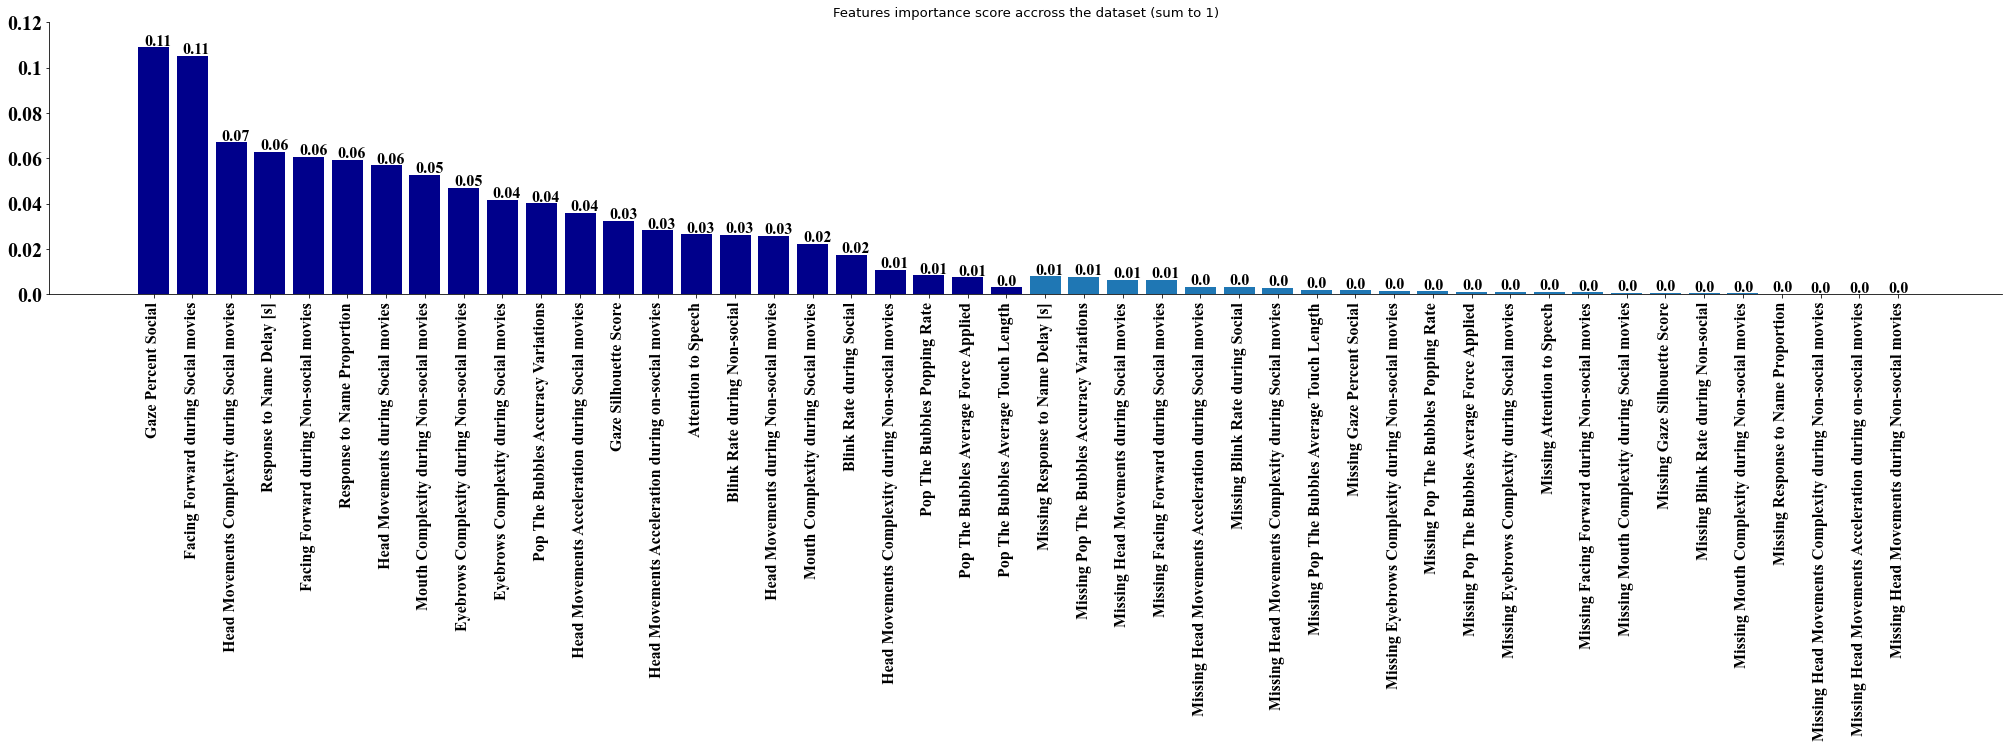

In [78]:
labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]       
n_features = len(exp.features_name)

#We first plot the present ones
idx_sorting_present = list(reversed(np.argsort(features_importances_extended[:n_features])))
offset=0.001
fi(35, 5)
plt.title("Features importance score accross the dataset (sum to 1)")
for i, feat in enumerate(np.array(exp.features_name)[idx_sorting_present]):
    plt.bar(i, features_importances_extended[idx_sorting_present][i], color='darkblue')
    plt.annotate(str(np.round(features_importances_extended[idx_sorting_present][i], 2)), (i-.25, features_importances_extended[idx_sorting_present][i] + offset), weight='bold', fontsize=16, **csfont)
    
    
idx_sorting_missing = list(reversed(np.argsort(features_importances_extended[n_features:])))
idx_sorting_missing = list(np.array(idx_sorting_missing) + n_features)
#And then the missing ones
for i, feat in enumerate(np.array(labels)[idx_sorting_missing]):
    j = i + n_features
    plt.bar(j, features_importances_extended[idx_sorting_missing][i], color='tab:blue')
    plt.annotate(str(np.round(features_importances_extended[idx_sorting_missing][i], 2)), (j-.25, features_importances_extended[idx_sorting_missing][i] + offset), weight='bold', fontsize=16, **csfont)
    
idx_sorting = idx_sorting_present + idx_sorting_missing
plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels= [feature_name_mapping[f] if f[0] != 'Z' else "Missing " + feature_name_mapping[f[2:]] for f in np.array(labels)[idx_sorting]], rotation =90, weight='bold', fontsize=16, **csfont)
#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)
plt.savefig(os.path.join(ROOT_DIR, 'figures_final', 'features_importance_present_missing.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')


#percent_missing_importance_mean = (1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).mean()*100
#percent_missing_importance_std =(1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).std()*100

#print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

In [93]:
general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).std()

0.1318726222001015

**What is the global contribution to the missing variables to the model ?**

In [94]:
percent_missing_importance_mean = general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).mean()*100
percent_missing_importance_std = general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).std()*100

print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

The average (std) contribution of the variables being missing are: 5.18% (+/- 13.19%)


**Which feature missingness is the most important overall ?**

In [81]:
general_shap_values_normalized[:, len(exp.features_name):].mean(axis=0)

array([1.79155979e-03, 7.27231589e-04, 1.01939733e-03, 2.50134040e-04,
       7.95874825e-03, 6.48854609e-03, 0.00000000e+00, 3.40274142e-03,
       0.00000000e+00, 2.94723034e-03, 9.54244576e-05, 3.35566871e-03,
       5.36100668e-04, 6.30521423e-03, 9.17889510e-04, 1.17217651e-03,
       1.46325803e-03, 7.64259161e-04, 4.52599866e-04, 1.23875736e-03,
       7.72045955e-03, 2.03185206e-03, 1.19620089e-03])

In [101]:
general_shap_values_normalized[:, -4:].mean(axis=0).sum()

0.012187269868640199

In [83]:
np.argmax(general_shap_values_normalized[:, len(exp.features_name):].mean(axis=0))

4

In [95]:
general_shap_values_normalized[:, len(exp.features_name):].std(axis=0)

array([0.0090475 , 0.00340467, 0.00456544, 0.00305438, 0.01651772,
       0.02940191, 0.        , 0.01536233, 0.        , 0.01221566,
       0.00094638, 0.01329282, 0.0073766 , 0.02652989, 0.00916786,
       0.00494388, 0.01416397, 0.00330073, 0.00462947, 0.00214715,
       0.01208771, 0.00338087, 0.00194491])

In [97]:
exp.features_name

['mean_gaze_percent_right',
 'gaze_silhouette_score',
 'FP_gaze_speech_correlation',
 'proportion_of_name_call_responses',
 'average_response_to_name_delay',
 'S_postural_sway',
 'NS_postural_sway',
 'S_postural_sway_derivative',
 'NS_postural_sway_derivative',
 'S_postural_sway_complexity',
 'NS_postural_sway_complexity',
 'S_blink_rate',
 'NS_blink_rate',
 'S_facing_forward',
 'NS_facing_forward',
 'S_eyebrows_complexity',
 'NS_eyebrows_complexity',
 'S_mouth_complexity',
 'NS_mouth_complexity',
 'pop_rate',
 'std_error',
 'average_length',
 'average_force_applied']

**Which feature missingness is the most important overall ? Now we detail the analysis only accounting for the participants having the feature missing (for each feature). This allow for instance to say: among all the participant who miss feature X, the average contribution of missing this feature where Y.**

In [85]:
mean_contribution_missing = [] 
std_contribution_missing = []
for i, feature_name in enumerate(exp.features_name):
    print(feature_name, len(np.argwhere(np.isnan(exp.dataset._X_train[:, i])).flatten()))
    
    
    
    mean_contribution_missing.append(general_shap_values_normalized[:, len(exp.features_name):][np.argwhere(np.isnan(exp.dataset._X_train[:, i])).flatten(), i].mean())
    std_contribution_missing.append(general_shap_values_normalized[:, len(exp.features_name):][np.argwhere(np.isnan(exp.dataset._X_train[:, i])).flatten(), i].std())

mean_contribution_missing = np.array(mean_contribution_missing)
mean_contribution_missing[np.isnan(np.array(mean_contribution_missing))] = 0


std_contribution_missing = np.array(std_contribution_missing)
std_contribution_missing[np.isnan(np.array(std_contribution_missing))] = 0

mean_gaze_percent_right 20
gaze_silhouette_score 20
FP_gaze_speech_correlation 23
proportion_of_name_call_responses 3
average_response_to_name_delay 94
S_postural_sway 18
NS_postural_sway 0
S_postural_sway_derivative 18
NS_postural_sway_derivative 0
S_postural_sway_complexity 22
NS_postural_sway_complexity 4
S_blink_rate 24
NS_blink_rate 2
S_facing_forward 21
NS_facing_forward 4
S_eyebrows_complexity 22
NS_eyebrows_complexity 4
S_mouth_complexity 22
NS_mouth_complexity 4
pop_rate 129
std_error 135
average_length 129
average_force_applied 133


In [86]:
mean_contribution_missing

array([0.0337709 , 0.01370832, 0.01670925, 0.03143351, 0.03191966,
       0.13589899, 0.        , 0.07126853, 0.        , 0.05050481,
       0.00899376, 0.05271196, 0.10105498, 0.11319361, 0.08651109,
       0.02008684, 0.13791207, 0.01309662, 0.04265754, 0.00362024,
       0.0215601 , 0.00593805, 0.00339073])

In [87]:
general_shap_values_normalized[:, len(exp.features_name):].std(axis=0)

array([0.0090475 , 0.00340467, 0.00456544, 0.00305438, 0.01651772,
       0.02940191, 0.        , 0.01536233, 0.        , 0.01221566,
       0.00094638, 0.01329282, 0.0073766 , 0.02652989, 0.00916786,
       0.00494388, 0.01416397, 0.00330073, 0.00462947, 0.00214715,
       0.01208771, 0.00338087, 0.00194491])

In [117]:
exp.features_name[14]

'NS_facing_forward'

**Conclusion:**

When missing, it is the Eyebrows complexity (missing)  that were themost important, with an average contribution of around 15%. However, this only concerns 4 cases...

0.13663403617279396

**For the computation of the compliance score, we are now interested only in the features that are present, and without the indicator variables.**

There are not normalized so we first need to renormalized them (some importance were allocated to the missing variables and Z)

In [88]:
shap_present_real_variables = shap_present[:, :23]
np.abs(shap_present_real_variables).sum(axis=1).mean()

0.9481645501449181

In [89]:
shap_present_normalized = np.abs(shap_present_real_variables) / np.abs(shap_present_real_variables).sum(axis=1)[:, np.newaxis] 
np.abs(shap_present_normalized).sum(axis=1).mean()

1.0

**We now average over the participants to get th importance of the present variables to the model**

In [90]:
features_importance_present_n = np.abs(shap_present_normalized).sum(axis=0)/ np.abs(shap_present_normalized).sum()
features_importance_present_n.shape

(23,)

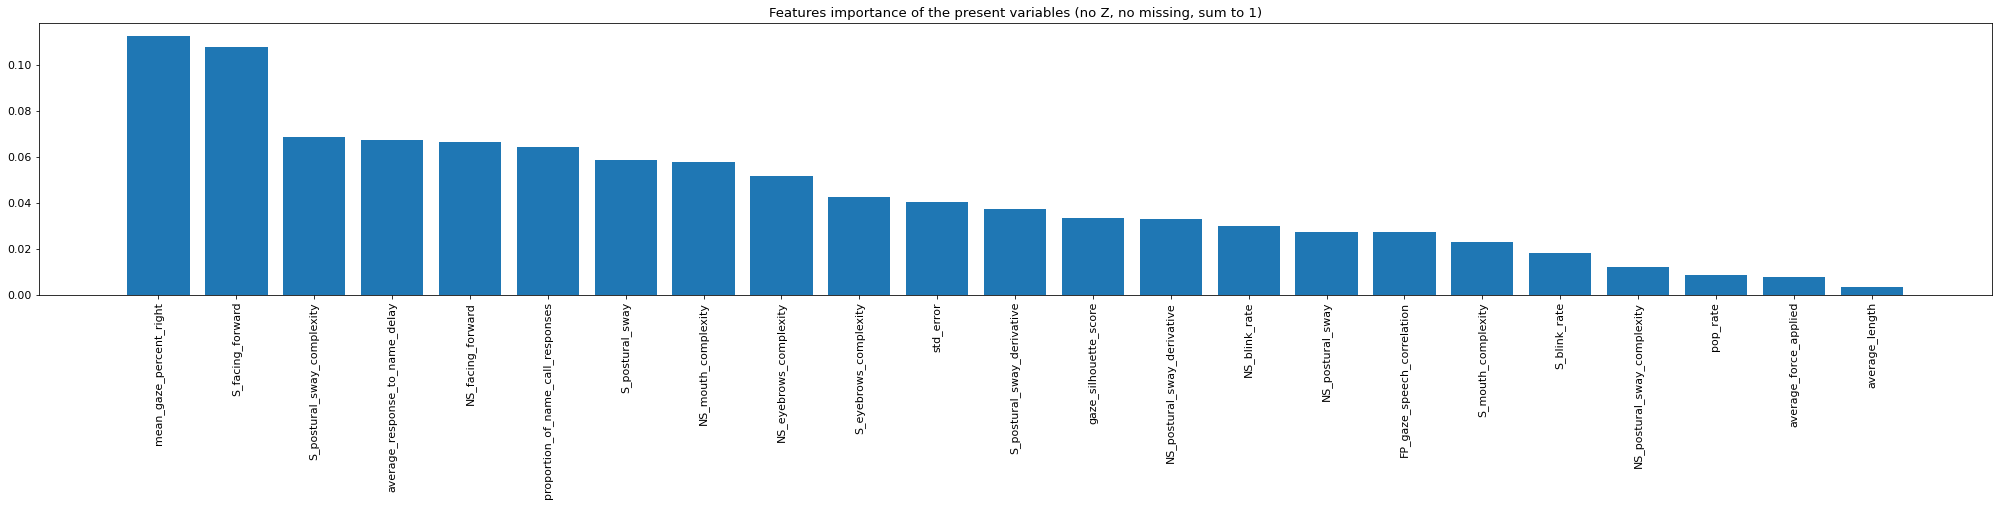

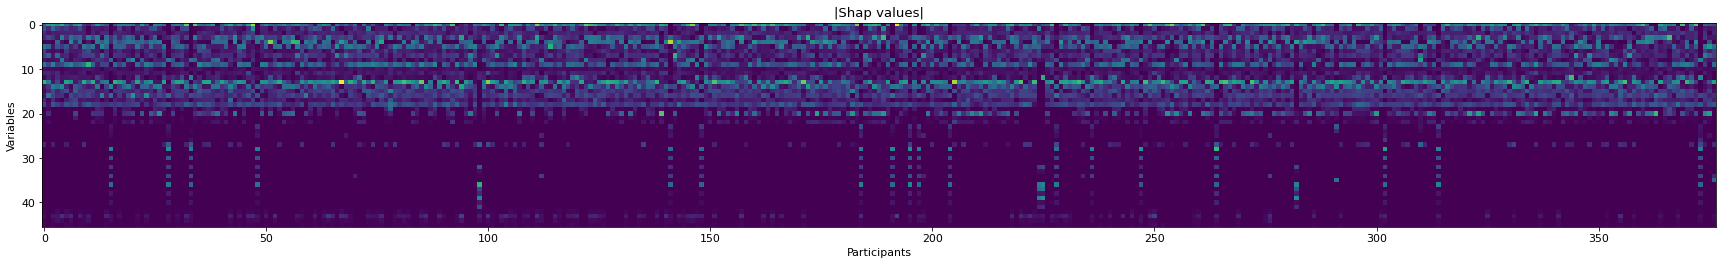

In [91]:
idx_ordered = list(reversed(np.argsort(features_importance_present_n)))

fi(35, 5)
plt.title("Features importance of the present variables (no Z, no missing, sum to 1)")
for i, (idx, feat) in enumerate(zip(idx_ordered, np.array(exp.features_name[:23])[idx_ordered])):
    plt.bar(i, features_importance_present_n[idx], color='tab:blue')
plt.xticks(ticks = np.arange(features_importance_present_n.shape[0]), labels=np.array(exp.features_name[:23])[idx_ordered], rotation =90)
None


fi(30, 35)
plt.title("|Shap values|")
plt.imshow(general_shap_values_normalized.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

# Snipet code to get the Shap values 

In [213]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/multimodal_paper_final/SenseToKnow/'

json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)
shap_values = shap_interactions.sum(axis=2)
shap_values_n = shap_values / np.abs(shap_values).sum(axis=2)[:, :, np.newaxis]
shap_values_averaged = shap_values_n.mean(axis=0)
shap_values_averaged_n = shap_values_averaged / np.abs(shap_values_averaged).sum(axis=1)[:, np.newaxis]

mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_averaged_n, mask_shap_present)
shap_missing = np.multiply(shap_values_averaged_n, (mask_shap_present==0).astype(int))

general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)
general_shap_values_normalized = np.abs(general_shap_values)/ np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]
features_importances_extended = general_shap_values_normalized.sum(axis=0)/general_shap_values_normalized.sum()


percent_missing_importance_mean = general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).mean()*100
percent_missing_importance_std = general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).std()*100

print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

shap_present_real_variables = shap_present[:, :23]
shap_present_normalized = np.abs(shap_present_real_variables) / np.abs(shap_present_real_variables).sum(axis=1)[:, np.newaxis] 
features_importance_present_n = np.abs(shap_present_normalized).sum(axis=0)/ np.abs(shap_present_normalized).sum()


(100, 377, 23, 23)

In [116]:
df

id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking        age timestamp        date time study stimuli_version  sex            ethnicity                race  primary_education  asd_yn  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay valid_name_calls  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  \
0      810051        NaN  English         1.0  <Subject.S2KSubject object at 0x7fead90e0290>  <Administration.S2KAdministration object at 0x...                   1              1  20.557377    Admin1  2018-12-18  NaN   ARC       Preschool    F  Not Hispanic/Latino  More than one race                5.0     NaN       33.0       43.0       20.0       36.0            68.0         7.0       7.0      7.0              88.0                         74.0                          84.0                16.0            23.0          4.0          4.0           1.0               0.483420                  0.559985              0.503797                 0.656863                    0.056406                  0.612839                           0.666667                        2.469133        [1, 1, 1]          2.226411                     0.016067            1.508462                       0.007390              3.493001                         0.017531          0.985949                     0.004048   
1      810068        NaN  English         2.0  <Subject.S2KSubject object at 0x7feafd5e3790>  <Administration.S2KAdministration object at 0x...                   1              1  25.114754    Admin1  2019-05-16  NaN   ARC       Preschool    M  Not Hispanic/Latino     White/Caucasian                6.0     NaN       30.0       30.0       20.0       30.0            59.0        10.0      10.0      9.0              63.0                         63.0                          57.0                 4.0             8.0          7.0          6.0           1.0               0.507230                  0.369734              0.415168                 0.578584                    0.154801                  0.419953                           0.333333                        0.800800        [1, 1, 1]          0.784235                     0.002854            0.807797                       0.002658              0.651890                         0.002205          0.749728                     0.002636   
2      810087        NaN  English         2.0  <Subject.S2KSubject object at 0x7fead90ea590>  <Administration.S2KAdministration object at 0x...                   1              1  25.737705    Admin1  2019-06-13  NaN   ARC       Preschool    M  Not Hispanic/Latino     White/Caucasian                5.0     NaN       32.0       46.0       23.0       47.0            75.0         9.0       9.0      9.0              65.0                         74.0                          49.0                 4.0             8.0          2.0          2.0           0.0               0.538741                  0.432138              0.302989                 0.597103                    0.182122                  0.539988                           0.666667                        1.735067        [1, 1, 1]          5.638023                     0.025742            1.377433                       0.005383              3.747147                         0.017349          0.717635                     0.003045   
3      810108        NaN  English      

In [ ]:
index_subgroup = np.array(exp.dataset.df[exp.dataset.df['mchat_final'].isnull()].index)